# Bias-Aware Clustering
In this notebook, we experiment with the Bias-Aware Clustering algorithm to identify which of the clustering algorithms (K-Means, DBSCAN or MeanShift) perform best in identifying discriminated clusters. The experiment is conducted with the German Credit Risk dataset.

To obtain the appropriate input for the Bias-Aware Clustering algorithm, we have preprocessed the dataset such that:
- It contains the errors obtained from a random forest classifier on the test set.
- The categorical attributes have been one-hot encoded
- We also have the predicted class and true class attributes. If your dataset doesn't contain these columns, please use the "synthetic data" notebook. 

### Init


In [134]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import warnings
warnings.filterwarnings('ignore')

## 1. Importing the Dataset

In [139]:
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
raw_data = pd.read_csv(r'..\Preprocessed_datasets\final_preprocessed_german_credit2.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

# Number of errors
raw_data.loc[raw_data['errors']==1]

# raw_data.head()


0.6413043478260869

In [146]:
dataset = initialize_dataset(raw_data)
# dataset.loc[dataset['errors']==1]



### Utils
The required functions for Bias-Aware Computing 

In [159]:
def pca_plot(data):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'PCA - 1st'}, inplace=True )
    temp_dataset.rename( columns={1 :'PCA - 2nd'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='PCA - 1st', y='PCA - 2nd', hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title('HBAC-KMeans on German Credit')
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Bias-Aware KMeans Clustering 

In [160]:
full_data = initialize_dataset(raw_data)
full_data.head()


Age       Job  Credit amount  Duration  Purpose_car  \
136 -0.829278  0.235354       2.140240  0.517353     1.637071   
76  -0.246248  0.235354       0.292574  1.725386    -0.610847   
280 -1.162437  0.235354       0.055255 -0.449073     1.637071   
174 -0.912567  0.235354       0.073541  0.034140    -0.610847   
210 -0.329538  0.235354      -0.061615 -0.932286    -0.610847   

     Purpose_domestic appliances  Purpose_education  \
136                          0.0          -0.286972   
76                           0.0          -0.286972   
280                          0.0          -0.286972   
174                          0.0           3.484660   
210                          0.0          -0.286972   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  ...  \
136                    -0.493197         -0.594089        -0.104828  ...   
76                     -0.493197          1.683251        -0.104828  ...   
280                    -0.493197         -0.594089        -0.104828  ...   
174                    -0.493197         -0.594089        -0.104828  ...   
210                    -0.493197          1.683251        -0.104828  ...   

     Check_rich  Age_cat_Young  Age_cat_Adult  Age_cat_Senior  scaled_errors  \
136   -0.149071       1.402762       -0.83887       -0.239732            0.0   
76    -0.149071       1.402762       -0.83887       -0.239732            0.8   
280   -0.149071      -0.712879       -0.83887       -0.239732            0.0   
174   -0.149071       1.402762       -0.83887       -0.239732            0.8   
210   -0.149071       1.402762       -0.83887       -0.239732            0.0   

     predicted_class  true_class  errors  clusters  new_clusters  
136                0         0.0     0.0         0            -1  
76                 0         1.0     1.0         0            -1  
280                0         0.0     0.0         0            -1  
174                0         1.0     1.0         0            -1  
210                0         0.0     0.0         0            -1  

[5 rows x 30 columns]

In [150]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 10,
}

In [152]:
round(0.03 * len(full_data))

3

Minimal splittable cluster size & minimal acceptable cluster size: 5% of the dataset


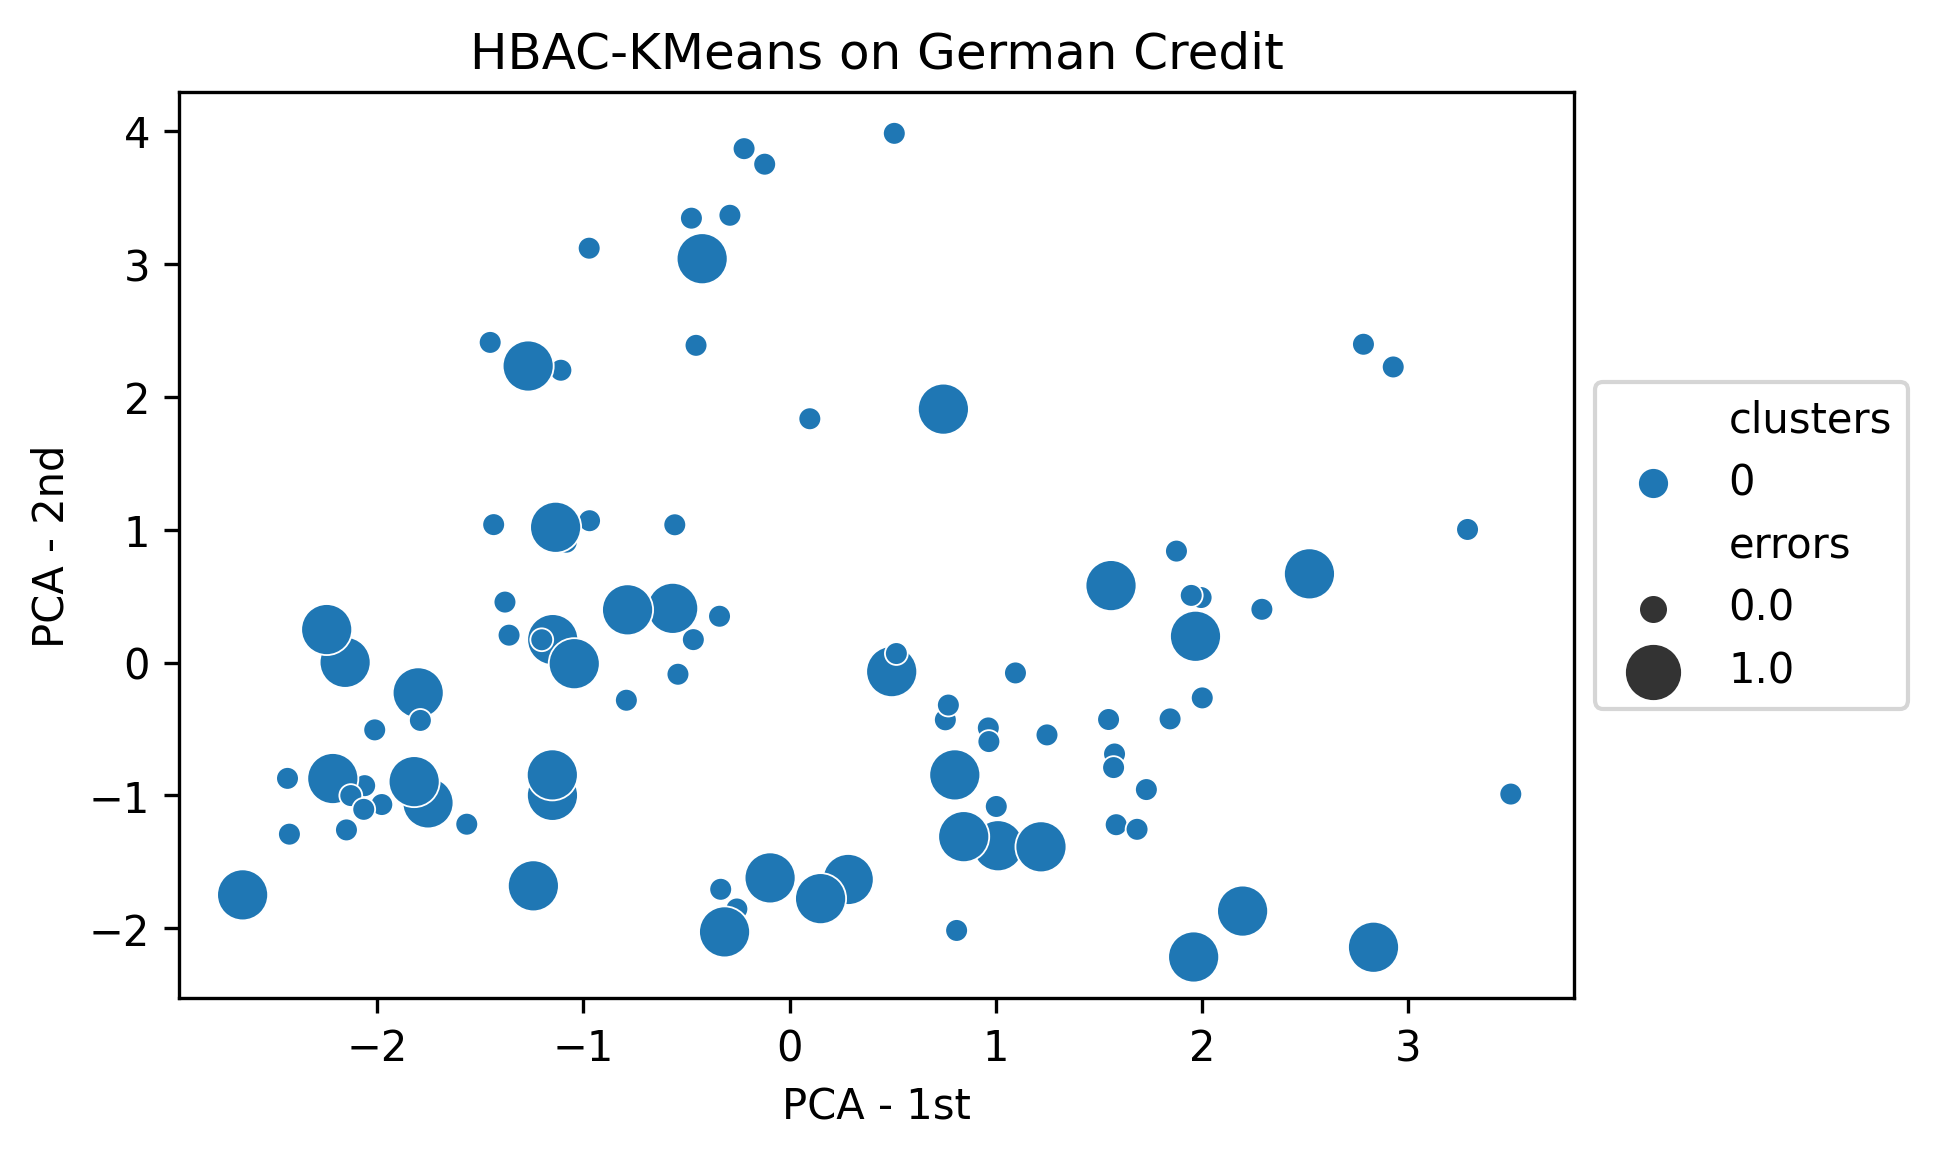

average_accuracy is:  0.6413043478260869


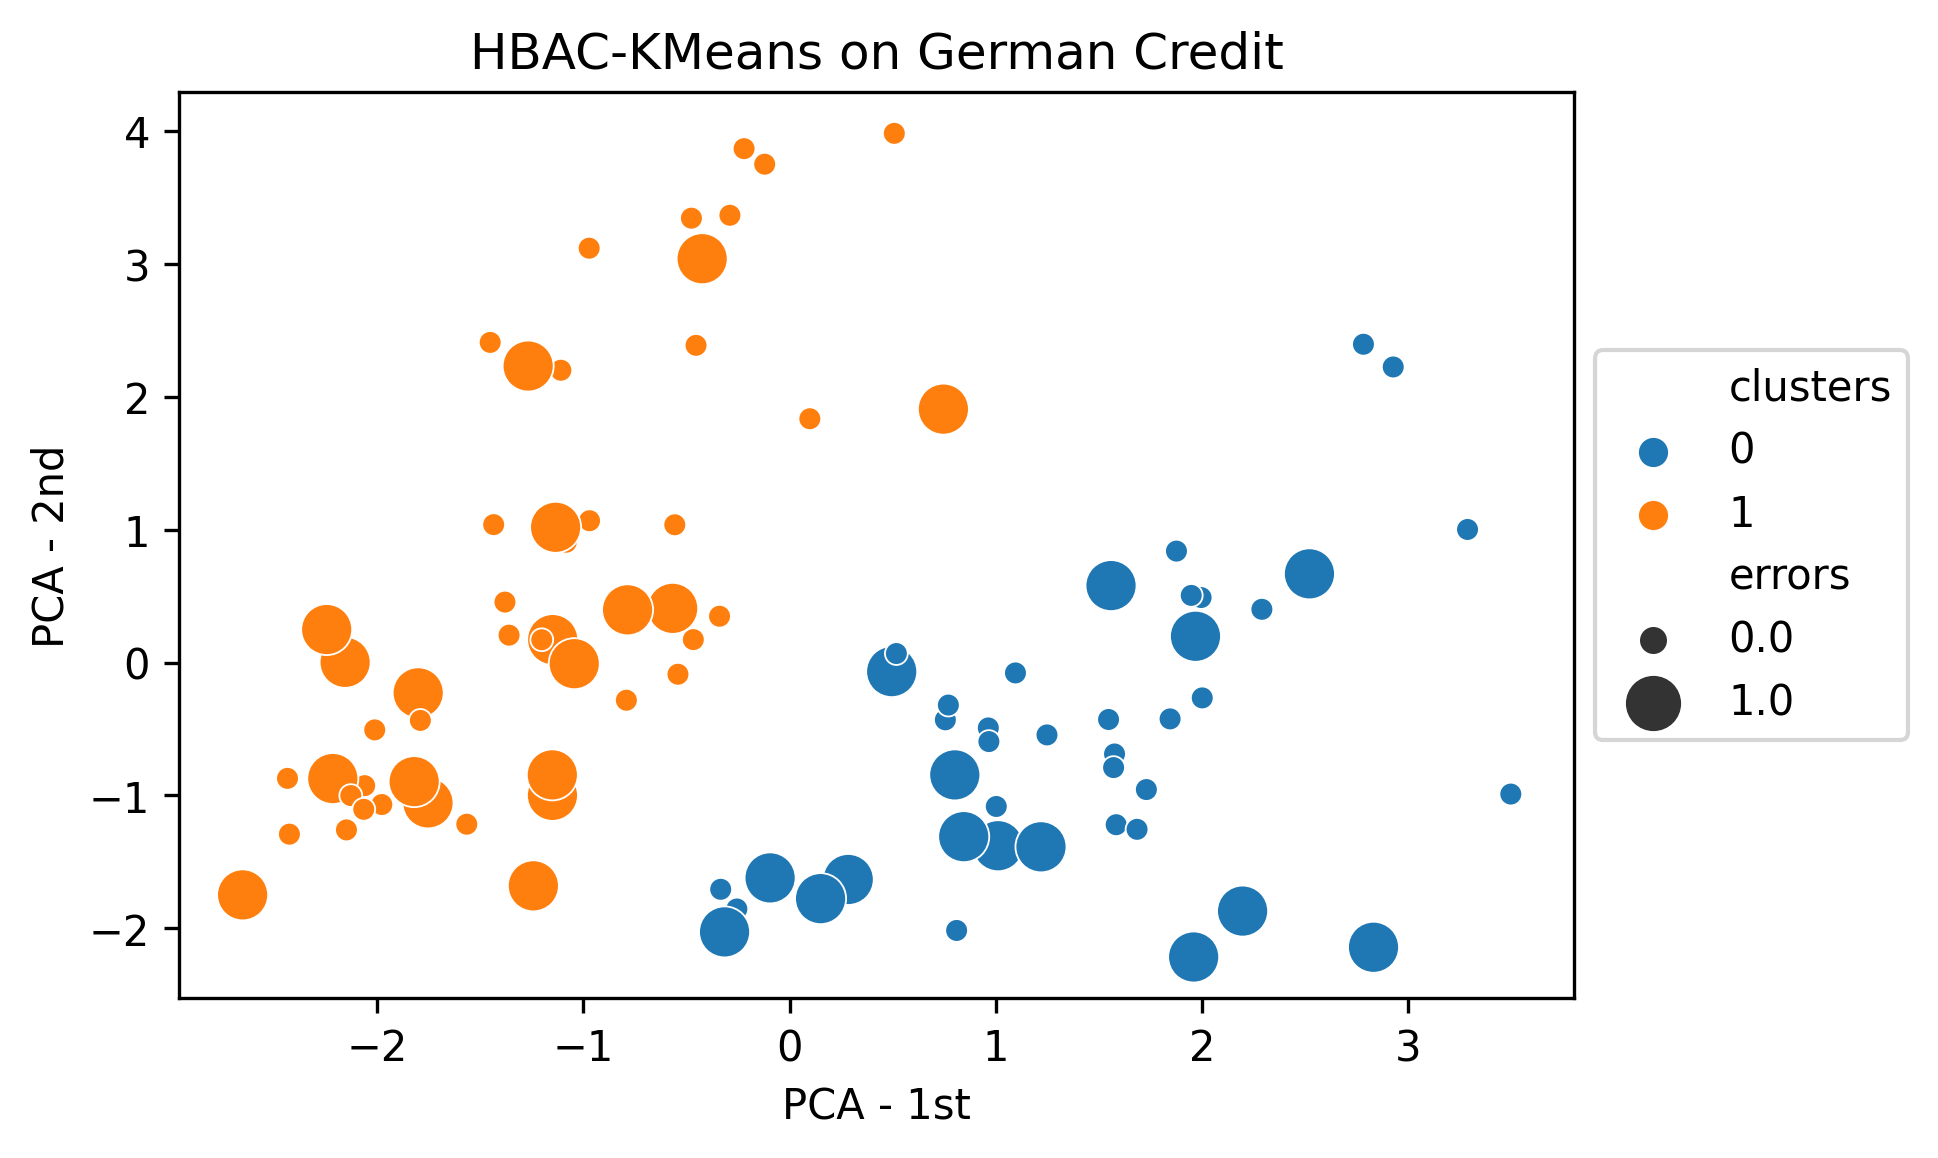

--> Cluster with the highest variance: 1


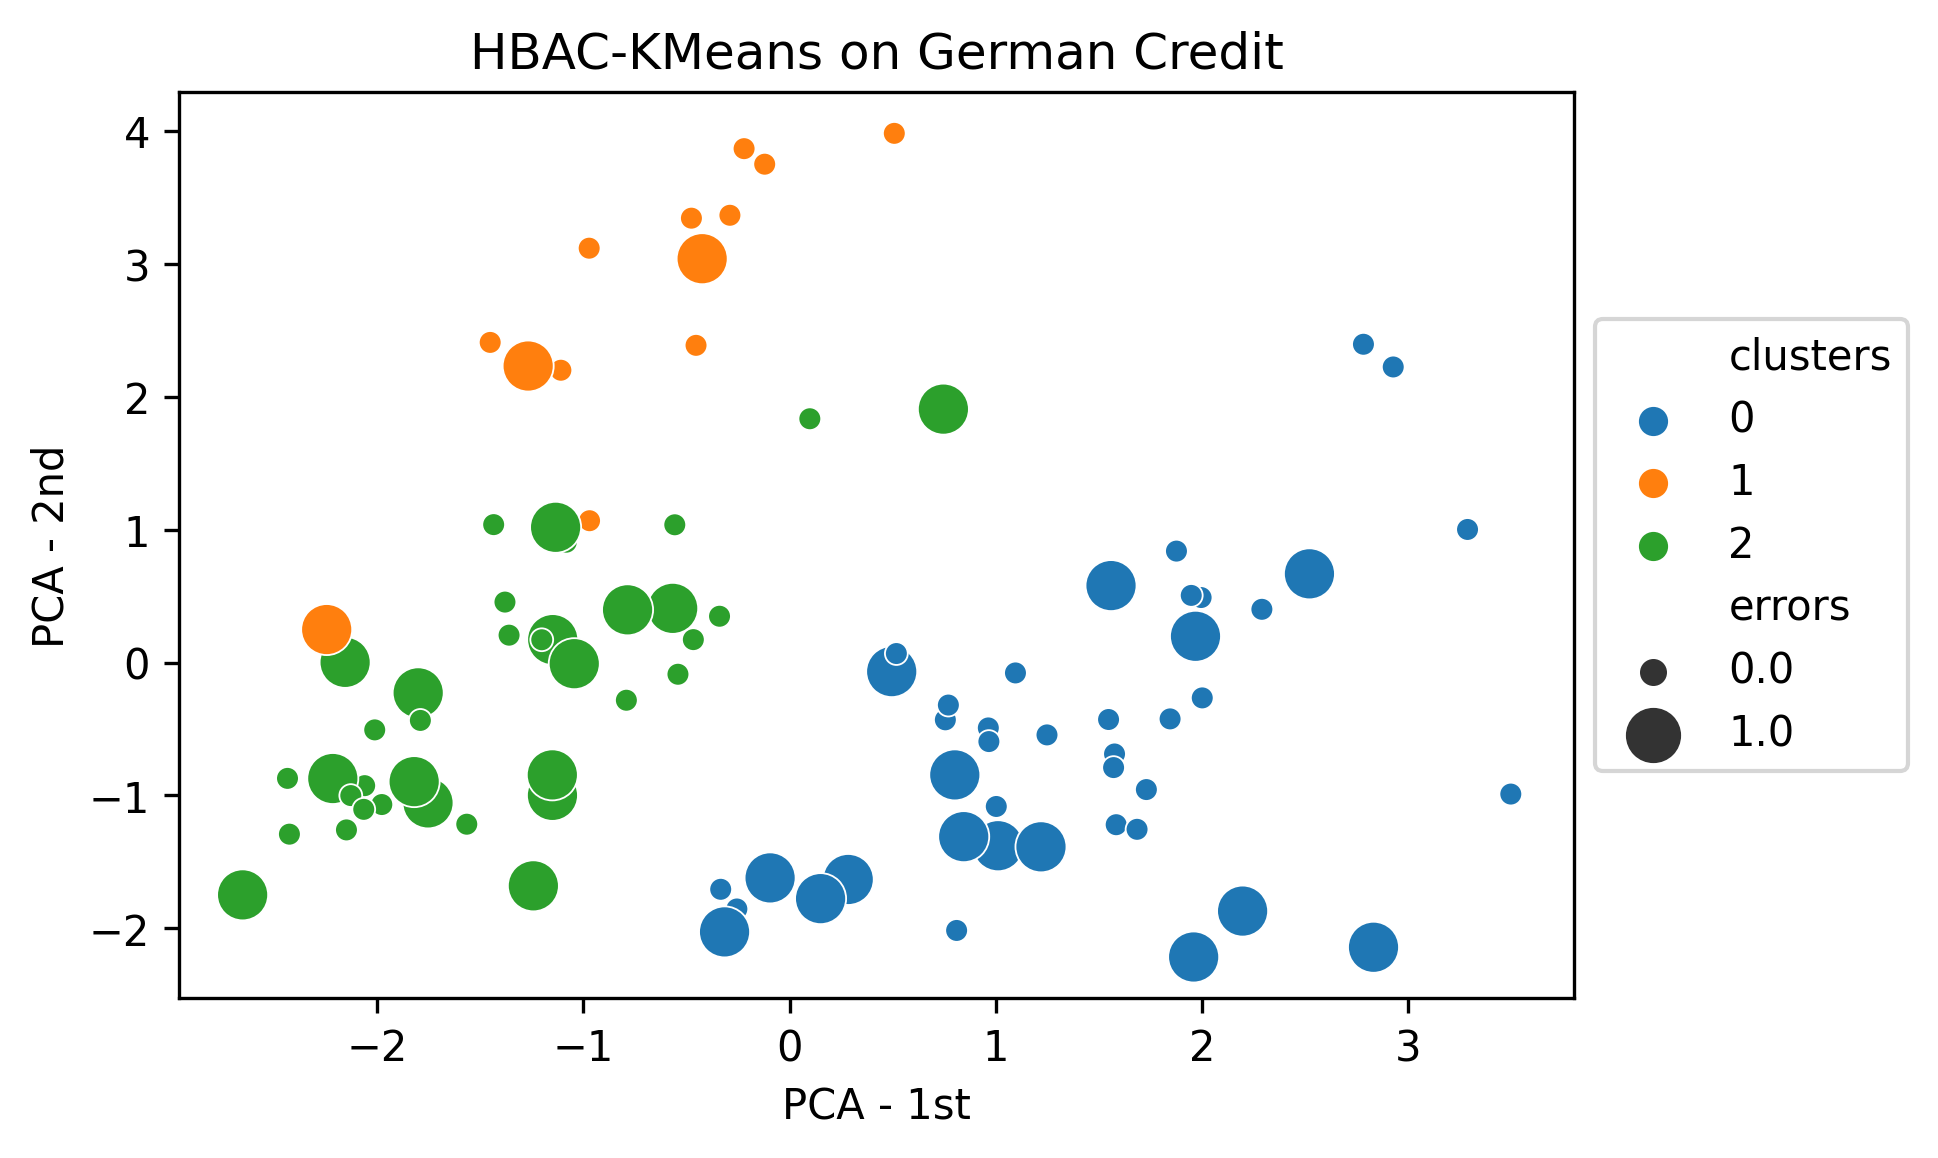

--> Cluster with the highest variance: 2


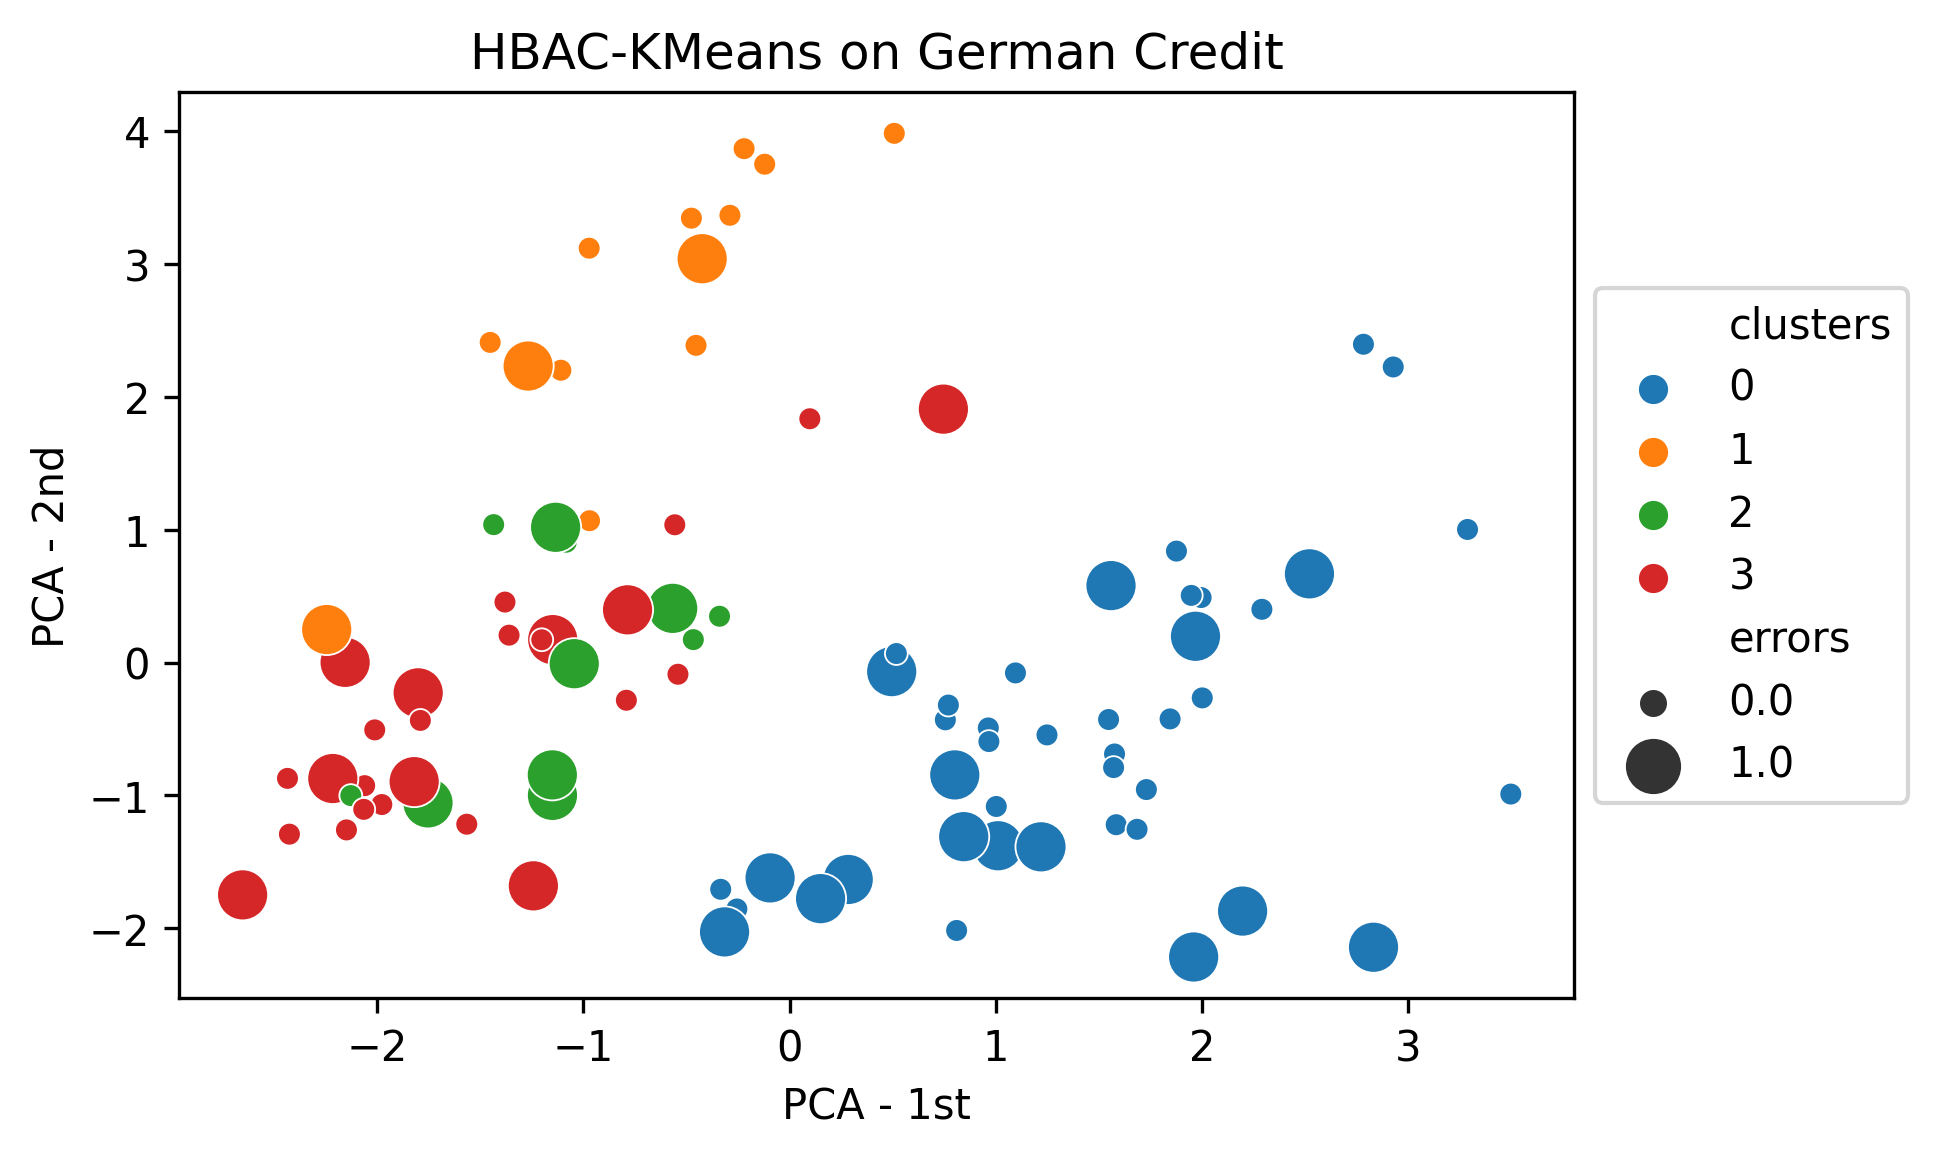

--> Cluster with the highest variance: 3
--> Cluster with the highest variance: 2


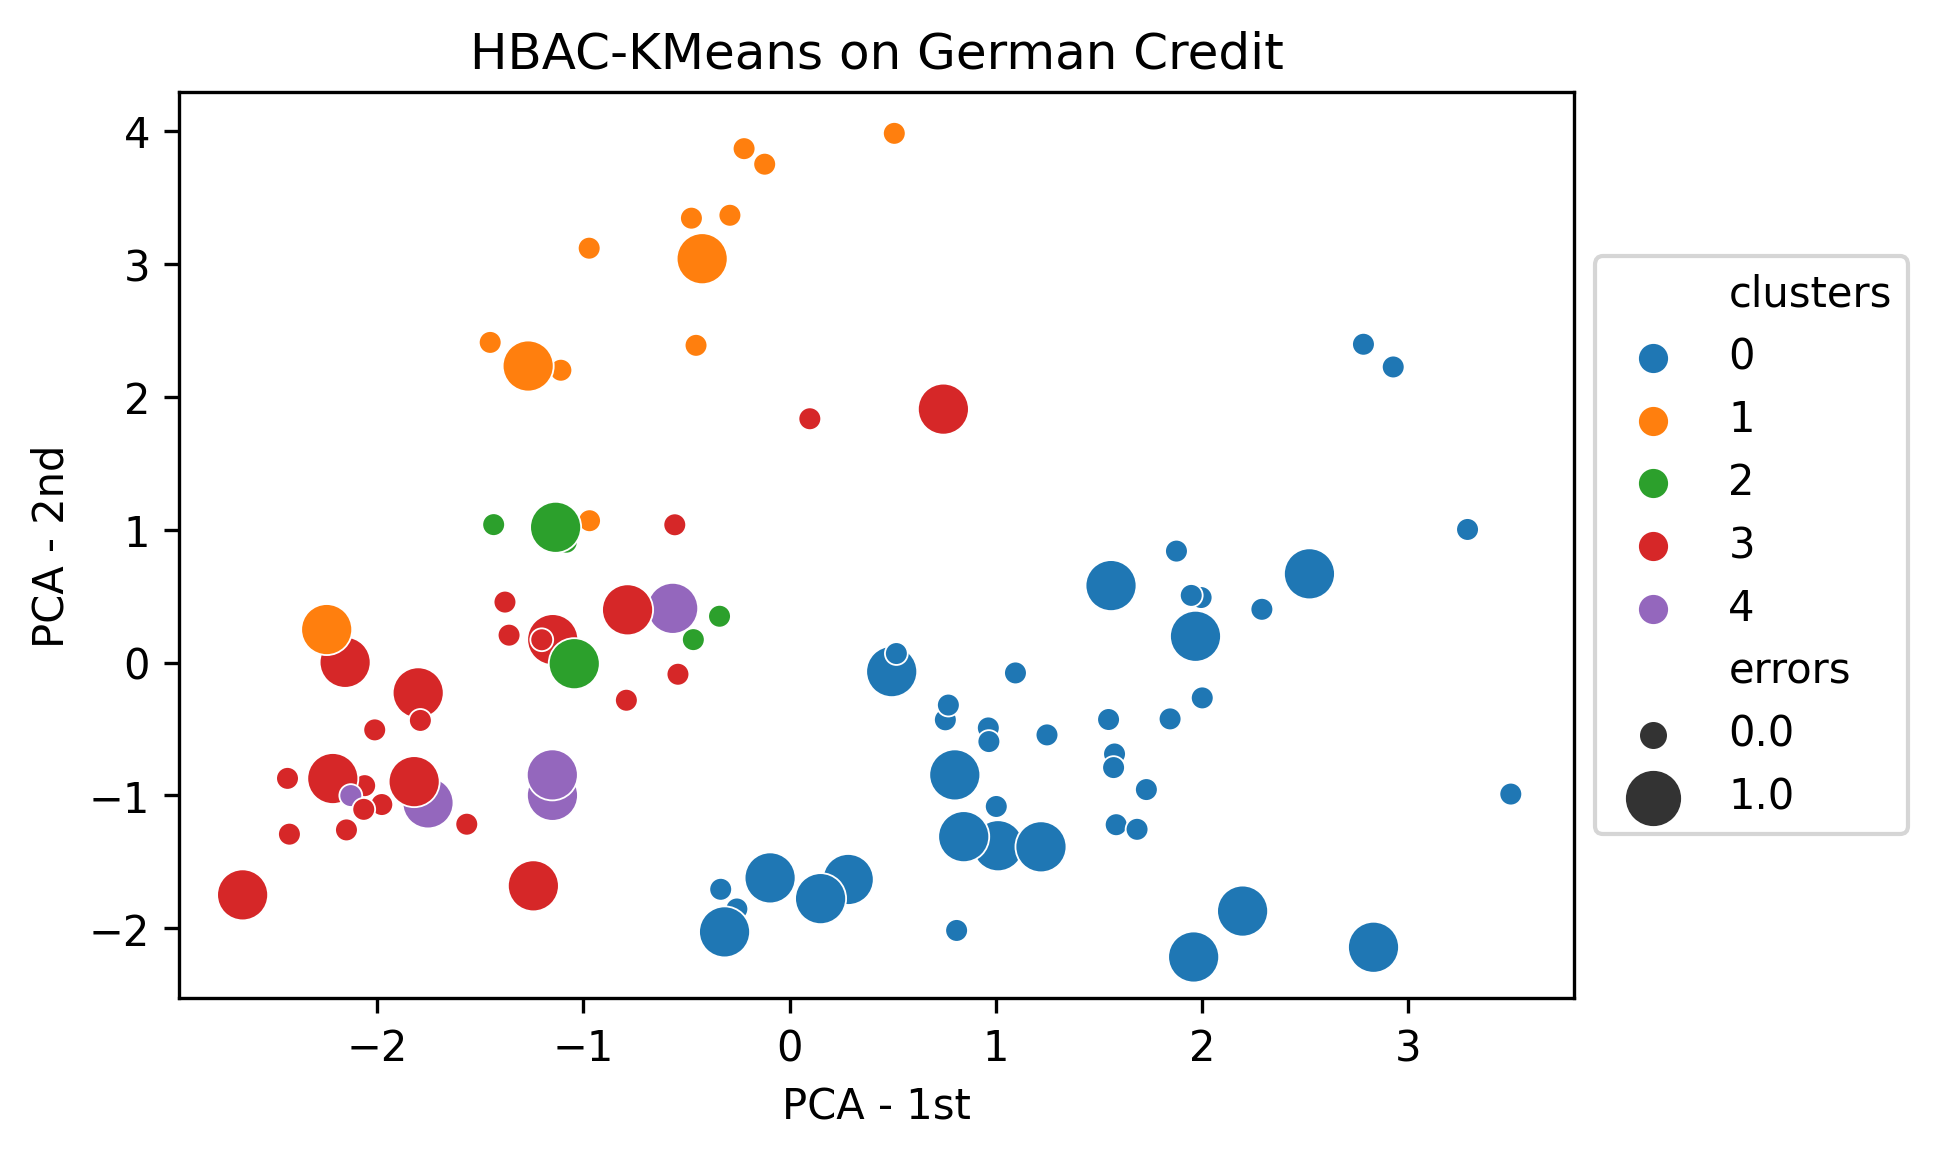

--> Cluster with the highest variance: 3


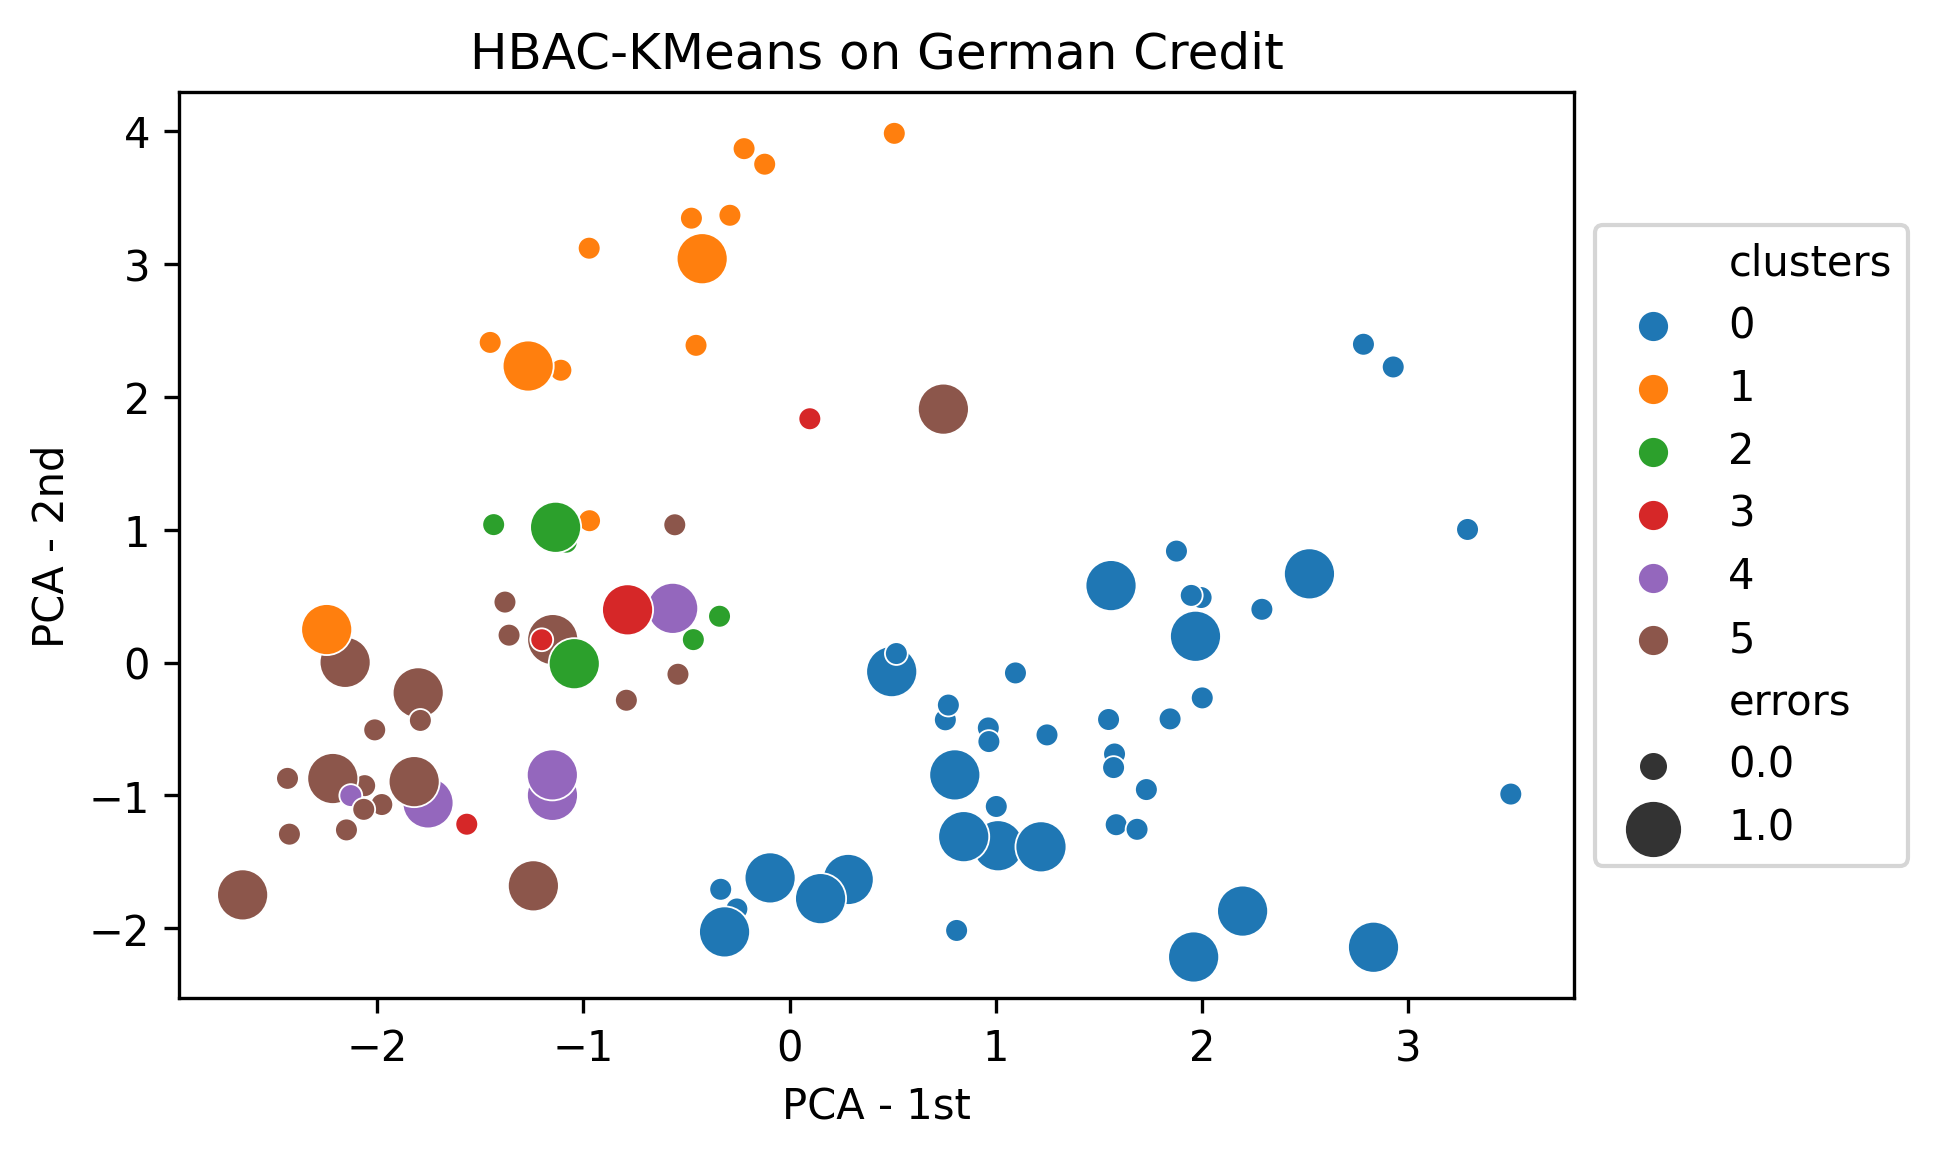

--> Cluster with the highest variance: 5


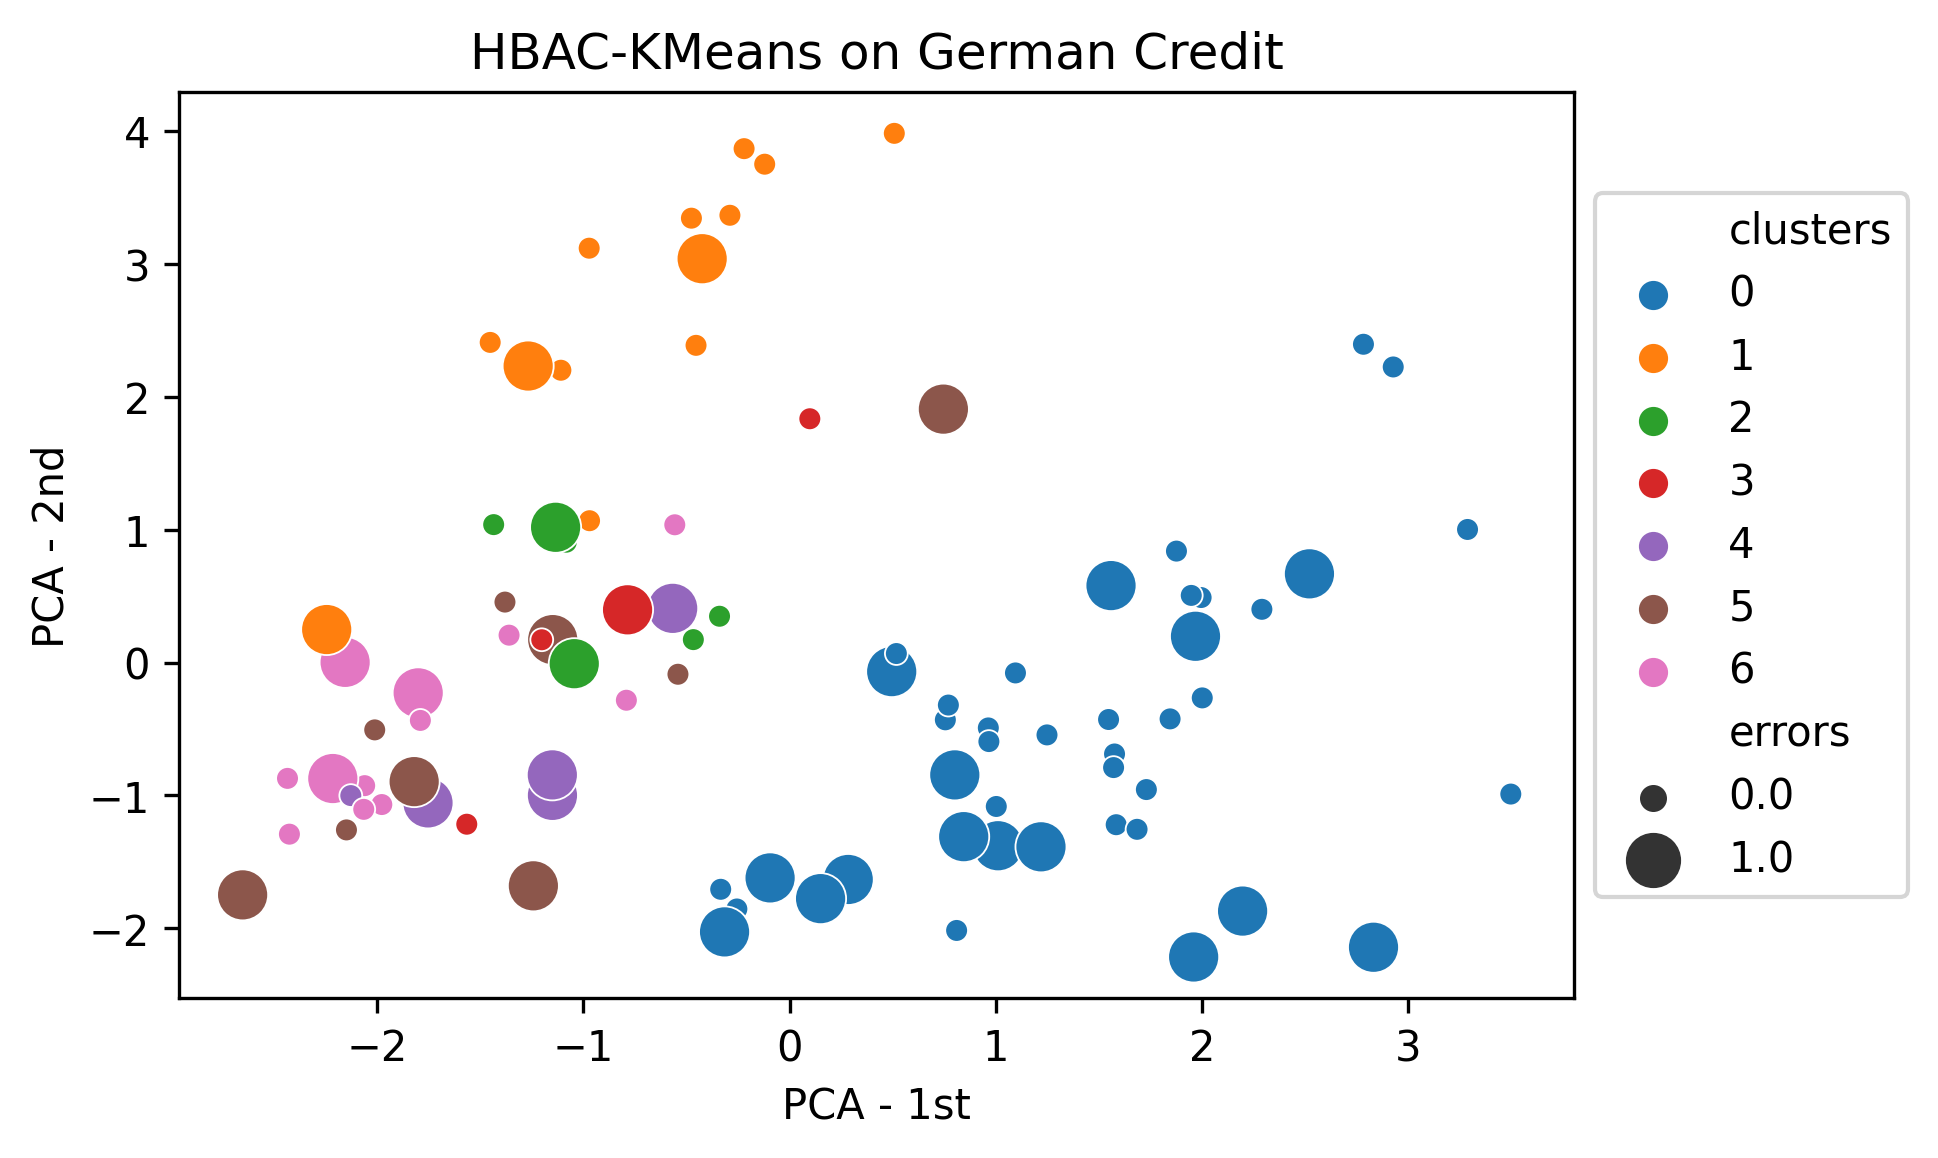

--> Cluster with the highest variance: 5


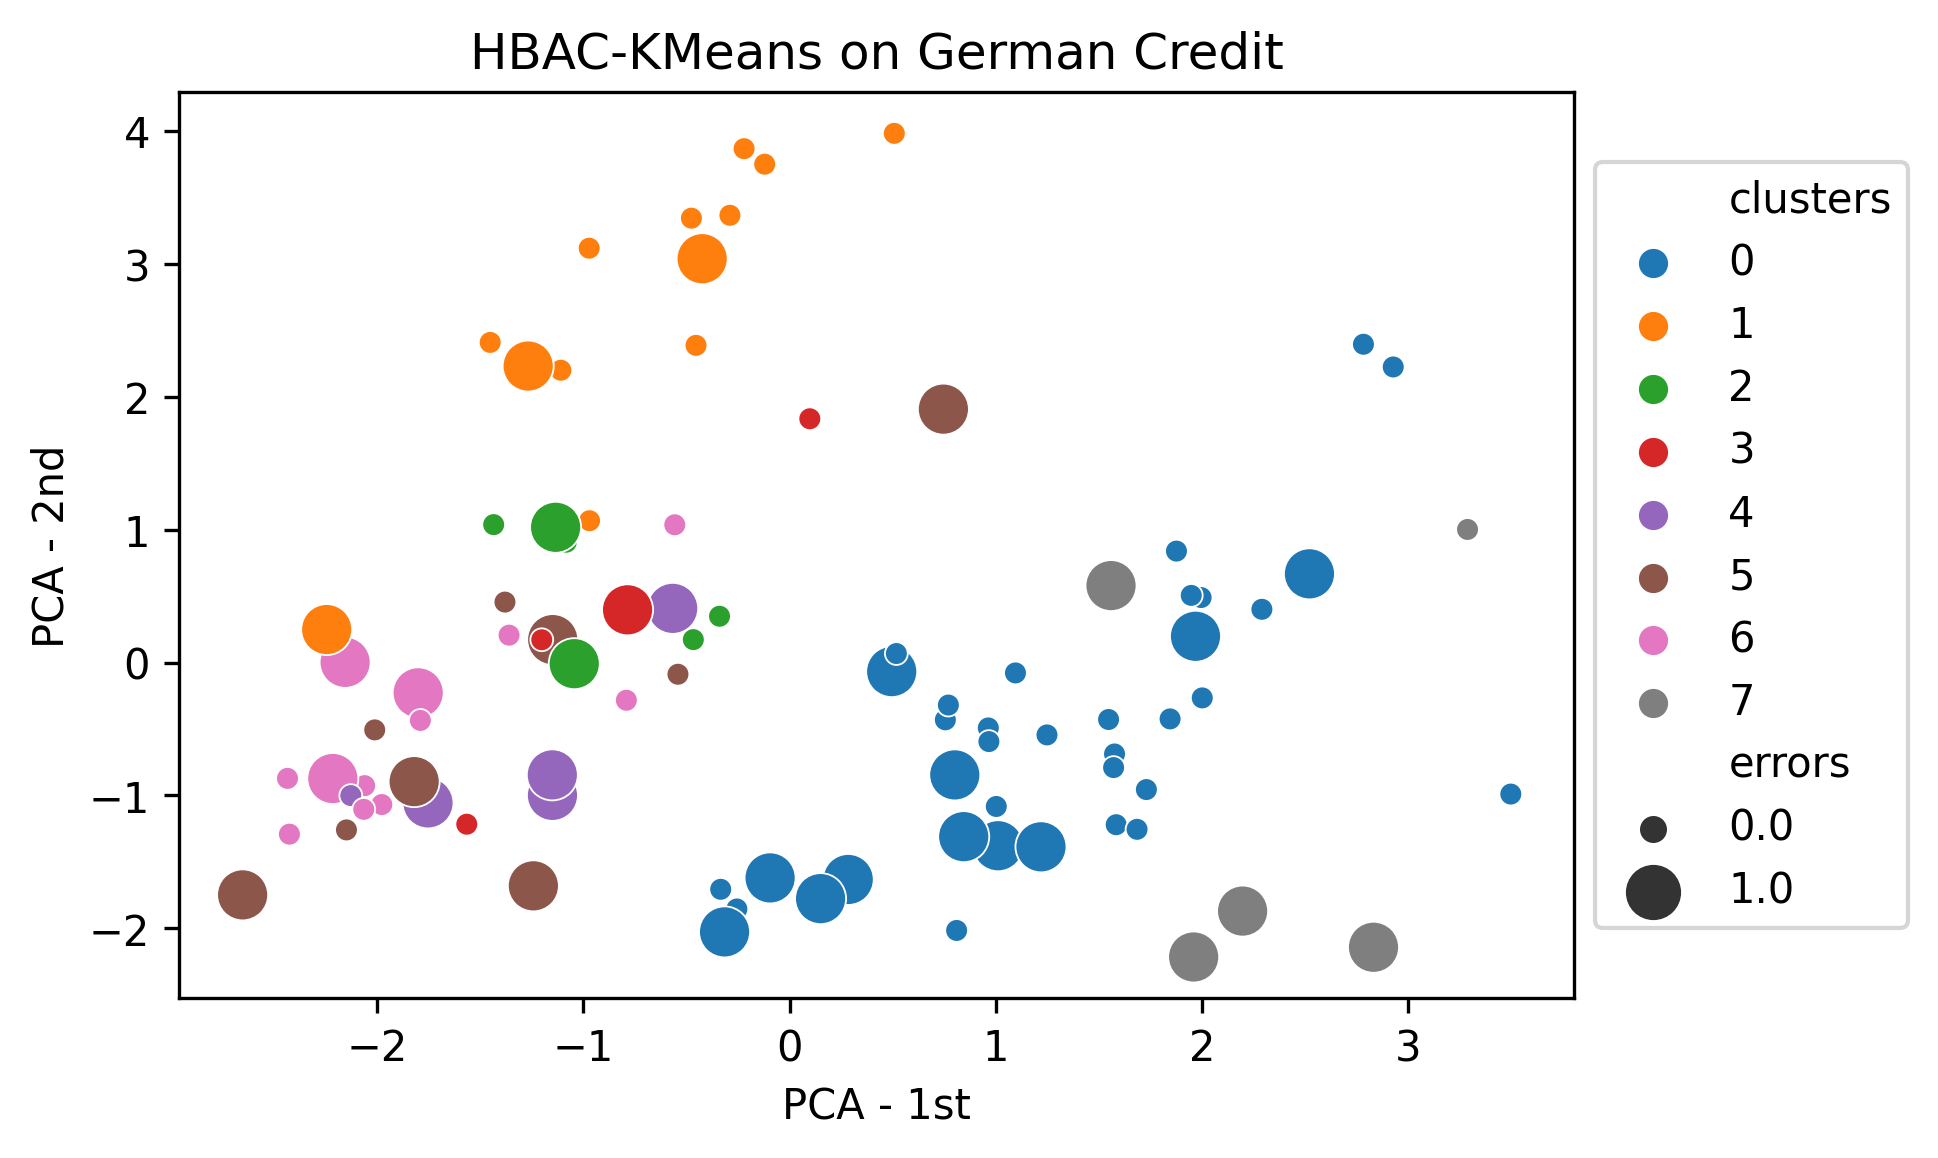

--> Cluster with the highest variance: 5


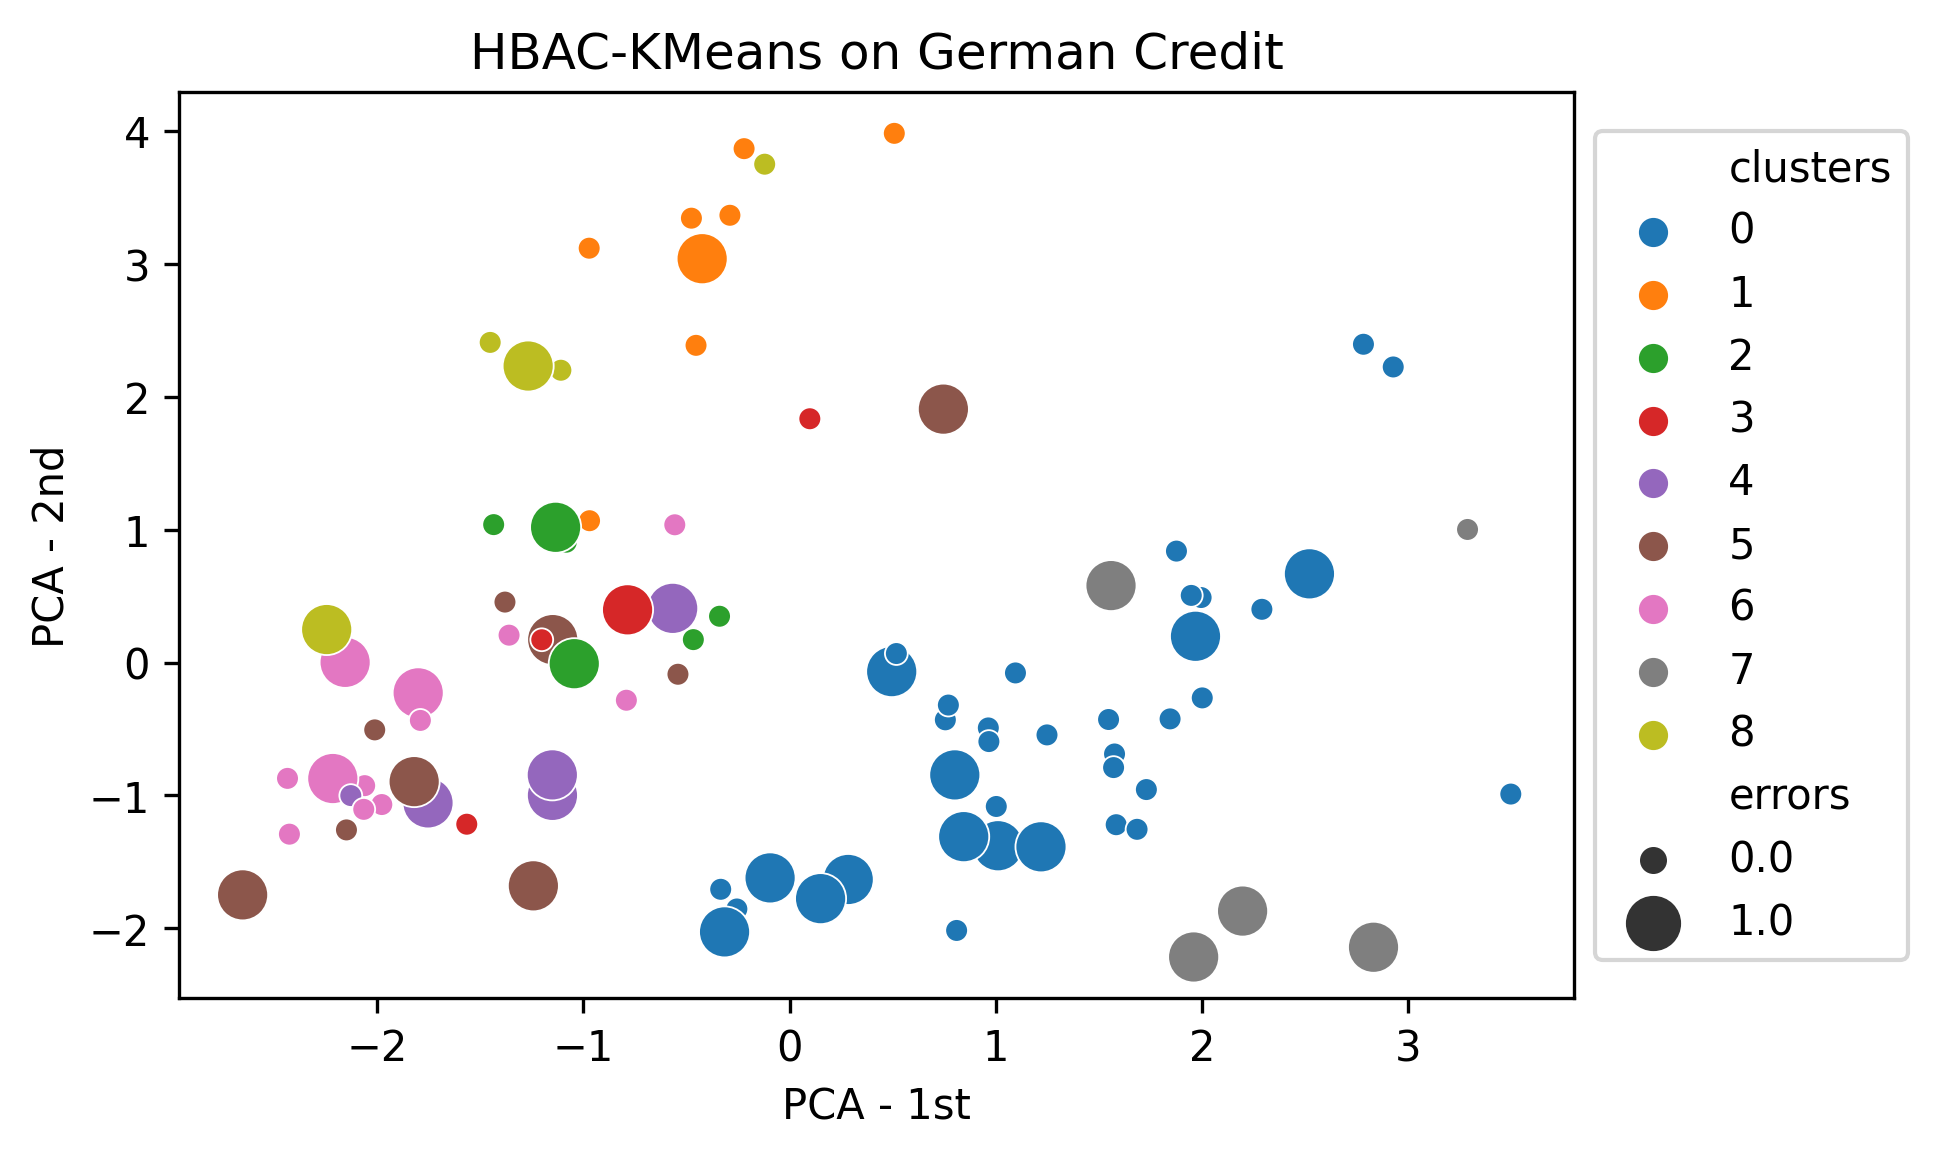

--> Cluster with the highest variance: 5
MAX_ITER
[0.00034261008517047986, 0.009955749129930412, 0.016749183722396064, 0.04521130817867498, 0.041491997317071795, 0.04402264700551146, 0.04402264700551146, 0.04402264700551146, 0.04402264700551146, 0.06258413305261654, 0.06258413305261654, 0.06258413305261654, 0.06258413305261654, 0.06258413305261654, 0.06216412048744392, 0.06216412048744392, 0.06216412048744392, 0.06216412048744392]


In [161]:
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

### 1. Analysing the clustering results


In [162]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

5 has bias -0.21820615796519416
4 has bias -0.4666666666666666
8 has bias -0.04367816091954024
2 has bias 0.02713178294573637
1 has bias 0.25595238095238093
0 has bias 0.11793372319688111
7 has bias -0.4666666666666666
6 has bias 0.125
3 has bias 0.11363636363636365
General accuracy of classifier on this dataset: 0.6413043478260869
cluster 4 has the highest discrimination bias
-0.4666666666666666


In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

In [ ]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 


In [ ]:
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)


# print('discriminated:', unscaled_discriminated)
# raw_data.loc[!discriminated_cluster.index, :]

# full_data.iloc[: , : 24]
# print(discriminated_cluster.index)


In [ ]:
unscaled_discriminated = unscaled_discriminated.iloc[: , : 13]
# print(unscaled_discriminated.head())
unscaled_remaining = remaining.iloc[: , : 13]

welch = scipy.stats.ttest_ind(unscaled_discriminated, unscaled_remaining, equal_var=False)
welch.pvalue

In [ ]:
# ridge plot
column_names = unscaled_discriminated.iloc[: , : 13].columns
# full_data.iloc[: , : 24]
column_names

# RidgePlot HBAC - KMeans


In [ ]:
# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on Wine: Discriminated Cluster distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

In [ ]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance incl errors").set_title('Variance of Instances')

## Baseline KMeans

In [92]:
full_data = initialize_dataset(raw_data)
full_data.head()

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
118        -0.817815 -1.122366                     -0.664518 -1.130778   
39         -0.049584 -0.293318                      1.298865  0.039721   
176         1.848400 -1.558707                     -1.360753  0.281061   

     scaled_errors  predicted_class  true_class  errors  clusters  \
104            0.0                1           1       0         0   
67             0.0                1           1       0         0   
118            0.8                2           1       1         0   
39             0.0                0           0       0         0   
176            0.0                2           2       0         0   

     new_clusters  
104            -1  
67             -1  
118            -1  
39             -1  
176            -1

In [93]:
# Same number of clusters as the found clusters by the bias-aware clustering algorithm?
baseline_kmeans = KMeans(n_clusters=11, init="k-means++", n_init=10, max_iter=300, random_state=2).fit(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))

full_data['clusters'] = pd.DataFrame(baseline_kmeans.predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',
                    'errors'], axis=1)),index=full_data.index) 


In [94]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinekm = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found discrimination bias:', most_biased_cluster_baselinekm)

4 has bias -0.019354838709677358
5 has bias -0.1875
3 has bias 0.10344827586206895
7 has bias 0.09230769230769231
0 has bias -0.26086956521739135
8 has bias 0.08695652173913049
2 has bias 0.09523809523809523
6 has bias 0.08695652173913049
9 has bias -0.09090909090909083
1 has bias -0.046875
10 has bias 0.08450704225352113
cluster 0 has the highest negative bias
[ 4  5  3  7  0  8  2  6  9  1 10]
Overall accuracy: 0.9166666666666666
Highest found discrimination bias: -0.26086956521739135


In [95]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 3
Number of errors in discriminated clusters:  1


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
131 -0.198656    0.620341  0.257670           0.320862   0.111630   
96  -1.559053   -0.140242  1.410826           0.742434   1.809670   
130 -0.224084   -0.813401 -0.013661          -0.241232   1.130454   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
131      -1.485418   -0.790709             -0.927387        -1.234524   
96       -1.033707   -1.005261             -1.730899        -0.085479   
130      -1.169221   -0.762724             -1.168440        -1.061380   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
131         0.085987 -0.947829                     -1.639247 -0.654132   
96         -1.224526 -0.031514                     -0.469572 -0.367541   
130        -0.501484 -0.860561                     -1.820268 -0.352457   

     scaled_errors  predicted_class  true_class  errors  clusters  \
131            0.0                2           2       0         0   
96             0.0                1           1       0         0   
130            0.8                1           2       1         0   

     new_clusters  
131            -1  
96             -1  
130            -1

In [100]:
# Full dataset ridgeplot

df = raw_data
column_names = raw_data.iloc[: , : 12].columns

df = df[column_names]
df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
104    12.51        1.73  1.98               20.5       85.0           2.20   
67     12.37        1.17  1.92               19.6       78.0           2.11   
118    12.77        3.43  1.98               16.0       80.0           1.63   
39     14.22        3.99  2.51               13.2      128.0           3.00   
176    13.17        2.59  2.37               20.0      120.0           1.65   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
104        1.92                  0.32             1.48             2.94  1.04   
67         2.00                  0.27             1.04             4.68  1.12   
118        1.25                  0.43             0.83             3.40  0.70   
39         3.04                  0.20             2.08             5.10  0.89   
176        0.68                  0.53             1.46             9.30  0.60   

     od280/od315_of_diluted_wines  
104                          3.57  
67                           3.48  
118                          2.12  
39                           3.53  
176                          1.62

In [101]:
# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example
# column_names = ["x", "y", "scaled_errors", "errors"]
# column_names = discriminated_cluster.iloc[: , : 14].columns
# df = df[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="What is the distribution of the highly discriminated cluster?",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

## 2. Bias-Aware DBSCAN

In [56]:
full_data = initialize_dataset(raw_data)
full_data.head()

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
118        -0.817815 -1.122366                     -0.664518 -1.130778   
39         -0.049584 -0.293318                      1.298865  0.039721   
176         1.848400 -1.558707                     -1.360753  0.281061   

     scaled_errors  predicted_class  true_class  errors  clusters  \
104            0.0                1           1       0         0   
67             0.0                1           1       0         0   
118            0.8                2           1       1         0   
39             0.0                0           0       0         0   
176            0.0                2           2       0         0   

     new_clusters  
104            -1  
67             -1  
118            -1  
39             -1  
176            -1

## Determining epsilon

Text(0.5, 1.0, 'Determining Optimal Value Epsilon')

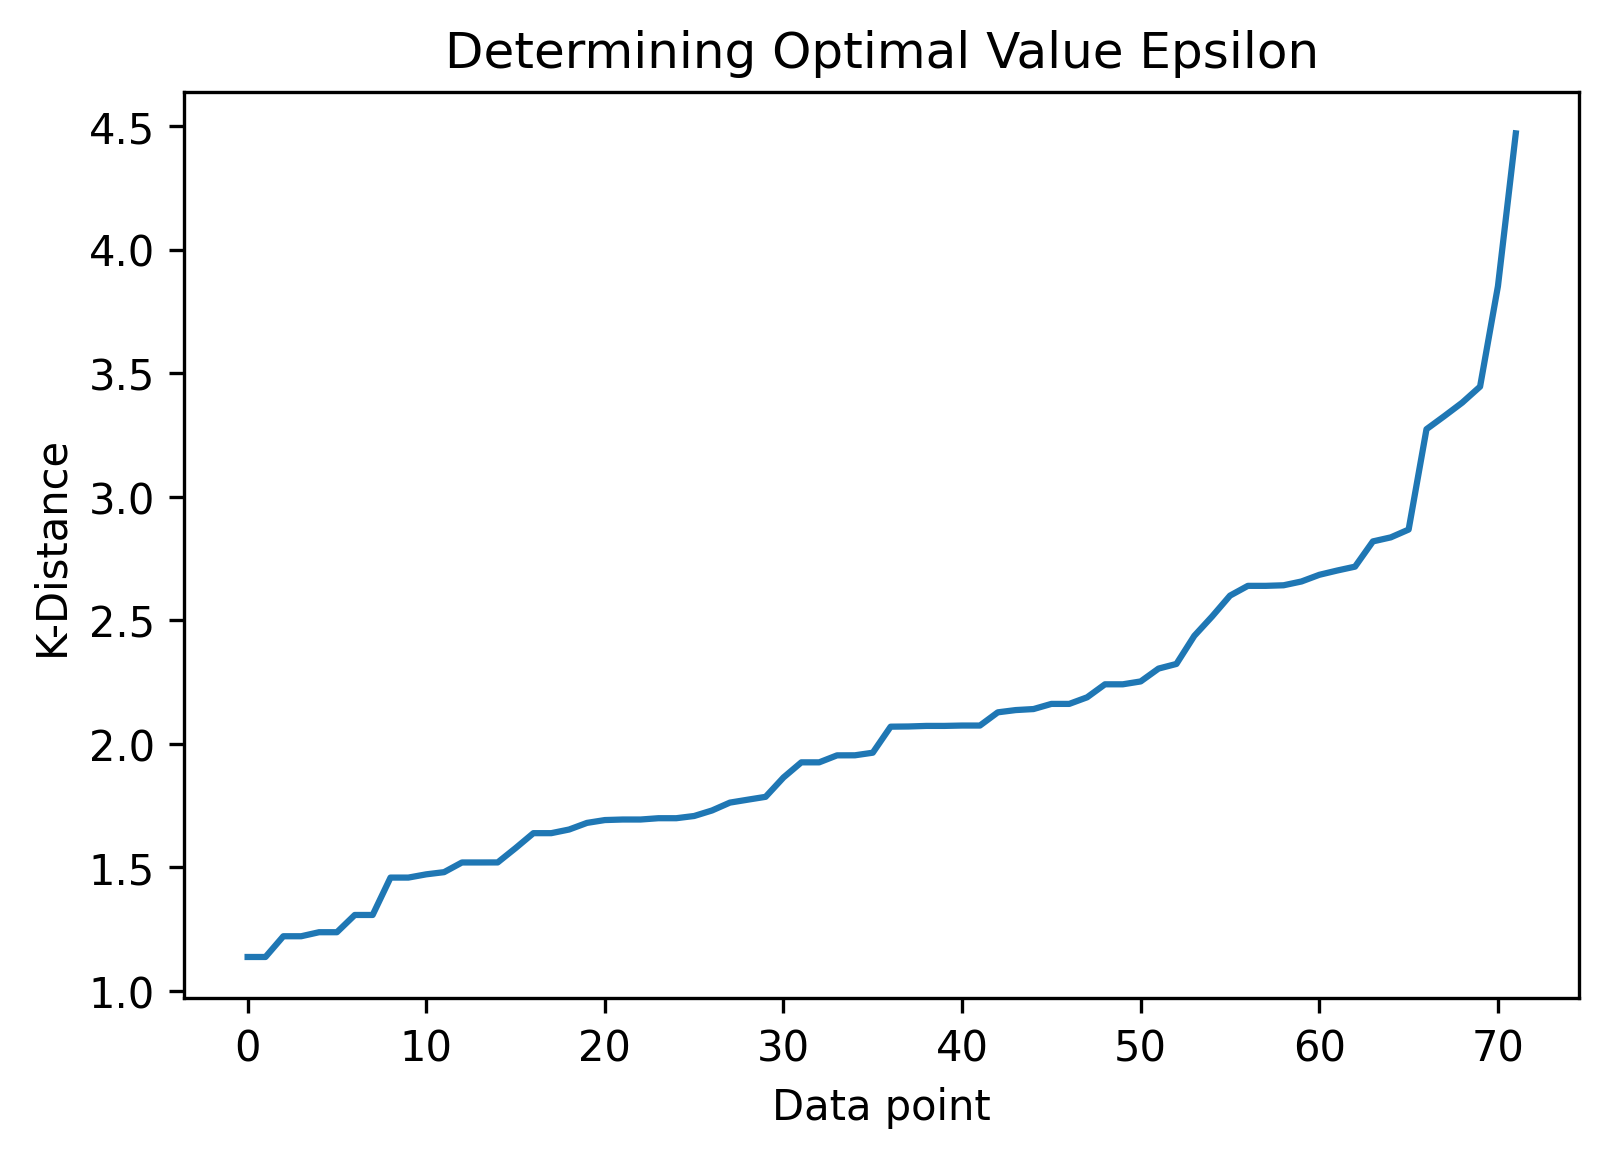

In [57]:
# determining epsilon
from sklearn.neighbors import NearestNeighbors

#for wine dataset
nn_features = full_data.iloc[: , : 14] #wine + including scaled errors
# for german credit:
# nn_features = full_data.iloc[: , : 25]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Determining Optimal Value Epsilon')

# plt.savefig('dbscan_wine_epsilon.png', dpi=300)

In [17]:
round(0.05 * len(full_data))

4

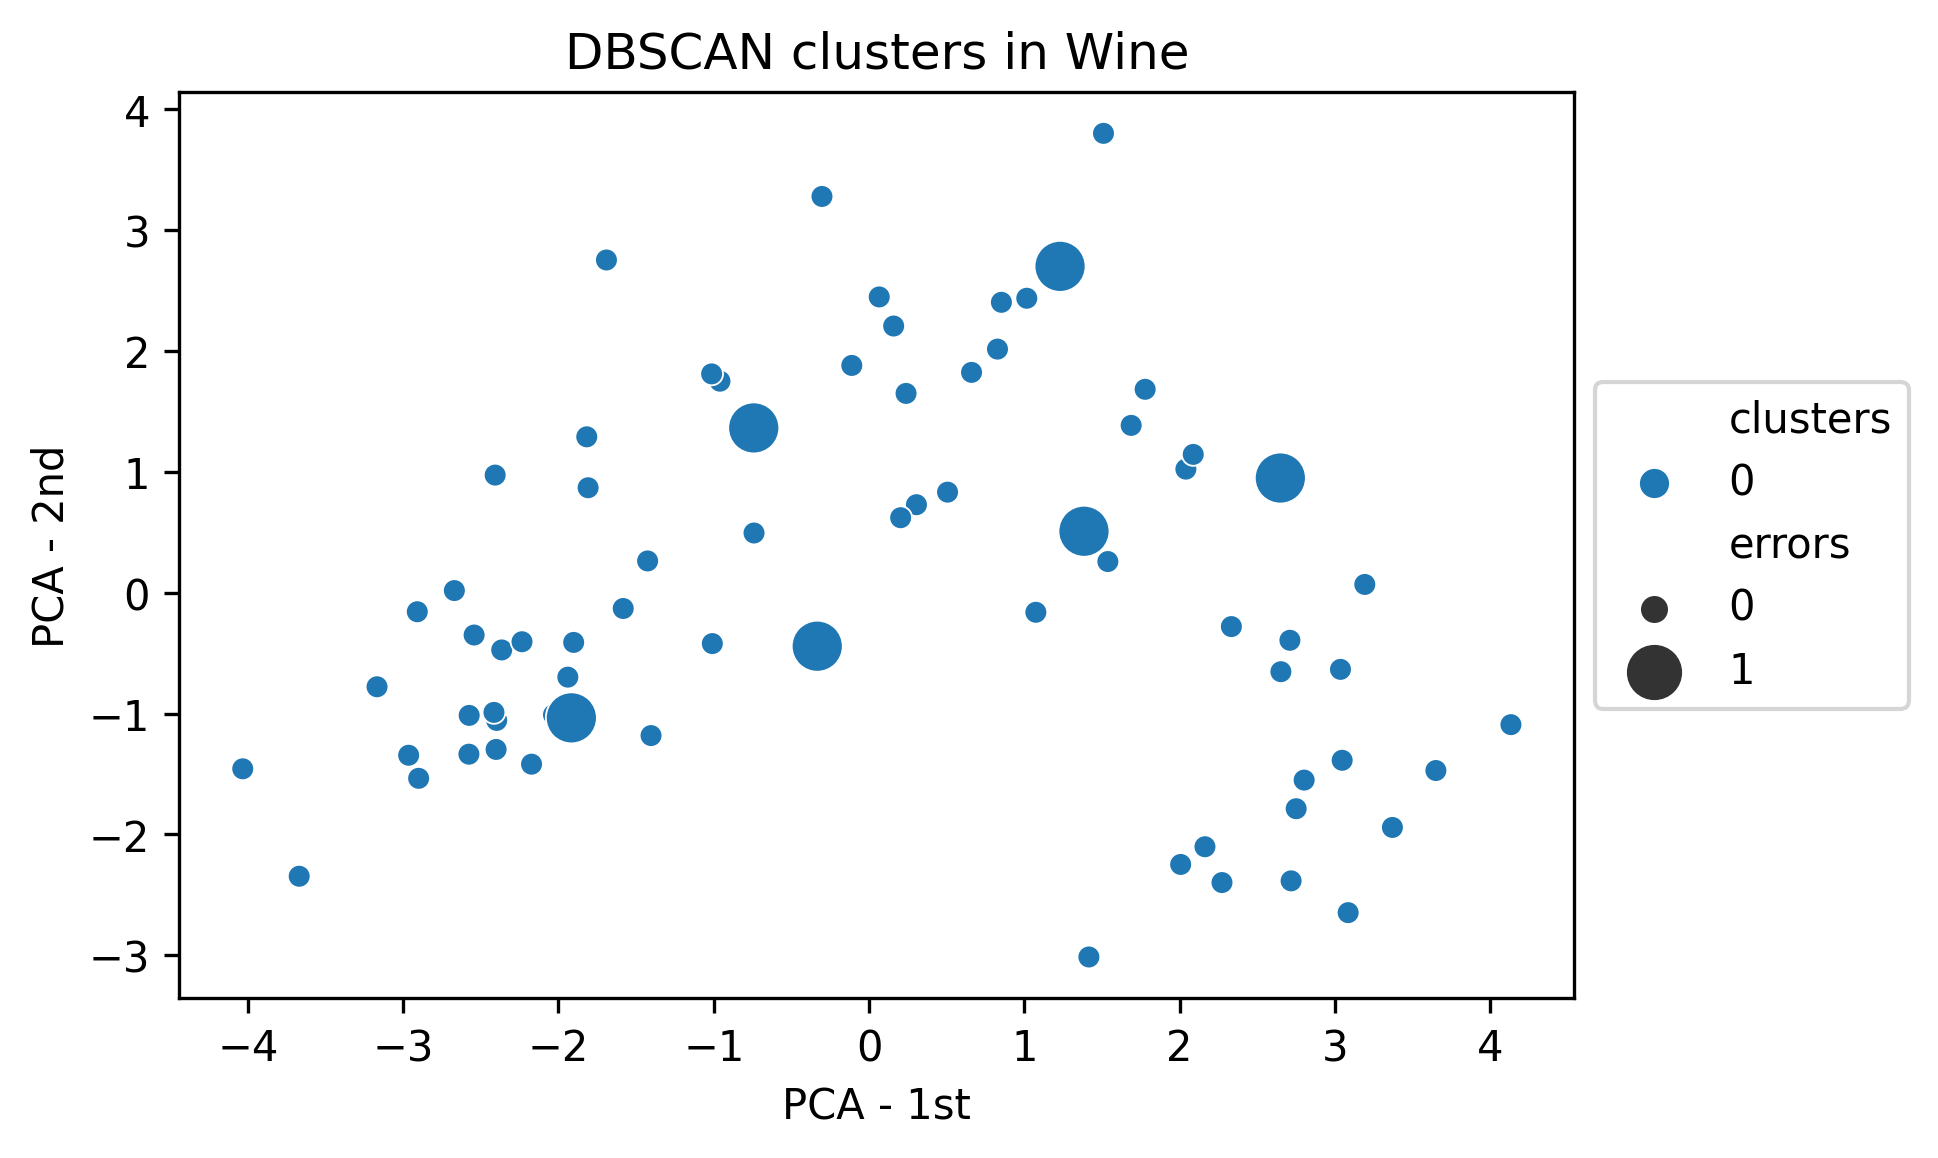

this is the current cluster:  0
smallest cluster:  5


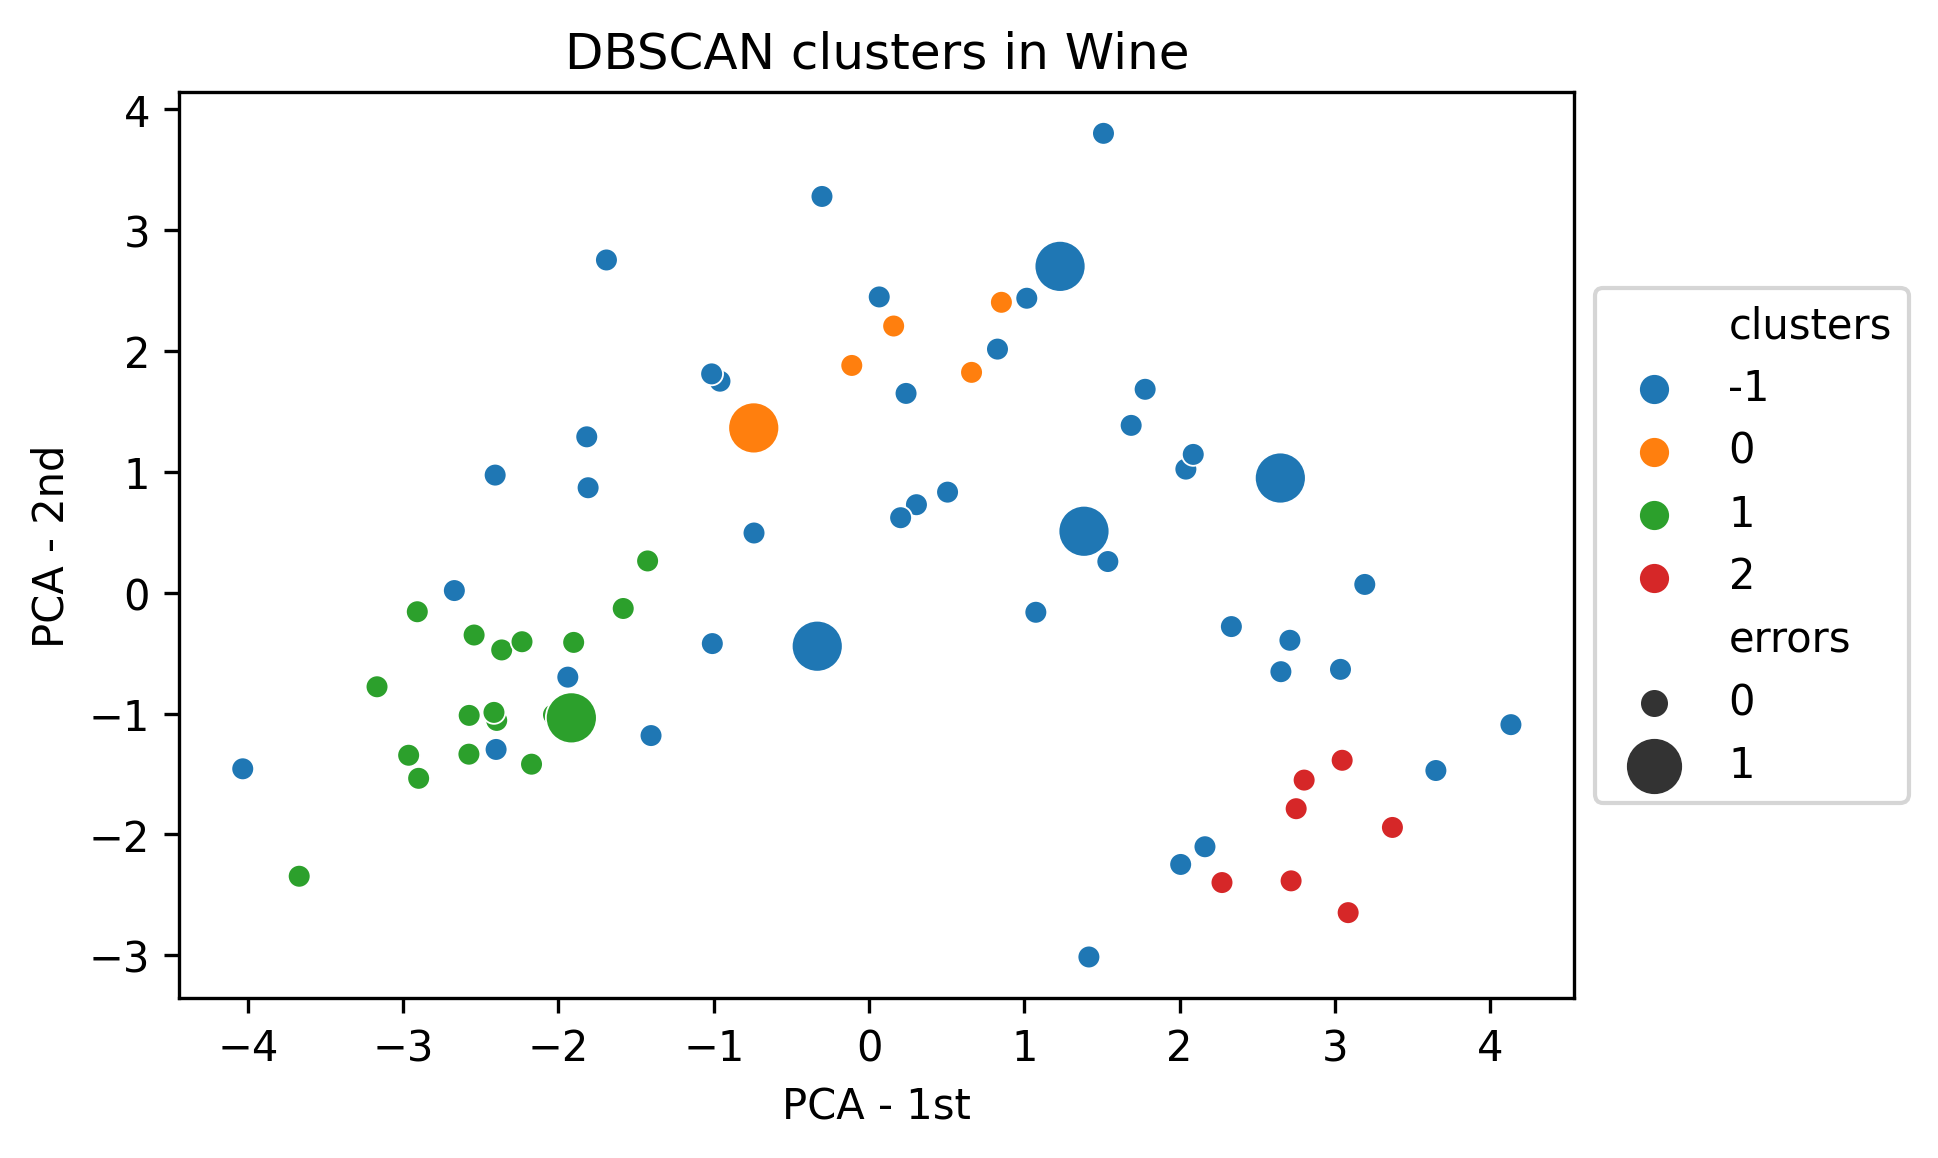

--> Cluster with the highest variance: 0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
MAX_ITER
0.9166666666666666
[0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.

In [58]:
MAX_ITER = 20
epsilon =  2
minimum_samples = 3 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
minimal_splittable_cluster_size = round(0.03 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon + 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

## 2. DBSCAN Results

In [60]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data) #shouldn't this be max_neg_bias_cluster
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

0 has bias -0.12537313432835817
1 has bias 0.03703703703703698
2 has bias 0.09230769230769231
cluster 0 has the highest negative bias
[ 0 -1  1  2]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.12537313432835817


In [61]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



Number of instances in discriminated cluster: 5
Number of errors in discriminated clusters:  1


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
101 -0.554648   -0.822143 -1.438148          -0.100709  -0.793991   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
106 -0.999638   -0.481192 -0.691988           0.039815  -1.246801   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
101      -1.259563   -0.660111             -0.525631        -0.416026   
81       -0.130285    0.431307             -0.766684         0.245068   
106      -0.958422   -0.035111              0.117179         0.024704   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
101        -1.247121  0.361193                      0.240588 -0.557596   
81         -0.591864  0.884802                      0.755802 -0.099050   
106        -0.817815  0.186657                      0.797576 -0.714467   

     scaled_errors  predicted_class  true_class  errors  clusters  \
104            0.0                1           1       0         0   
67             0.0                1           1       0         0   
101            0.0                1           1       0         0   
81             0.8                0           1       1         0   
106            0.0                1           1       0         0   

     new_clusters  
104           0.0  
67            0.0  
101           0.0  
81            0.0  
106           0.0

In [ ]:
full_data = initialize_dataset(raw_data)

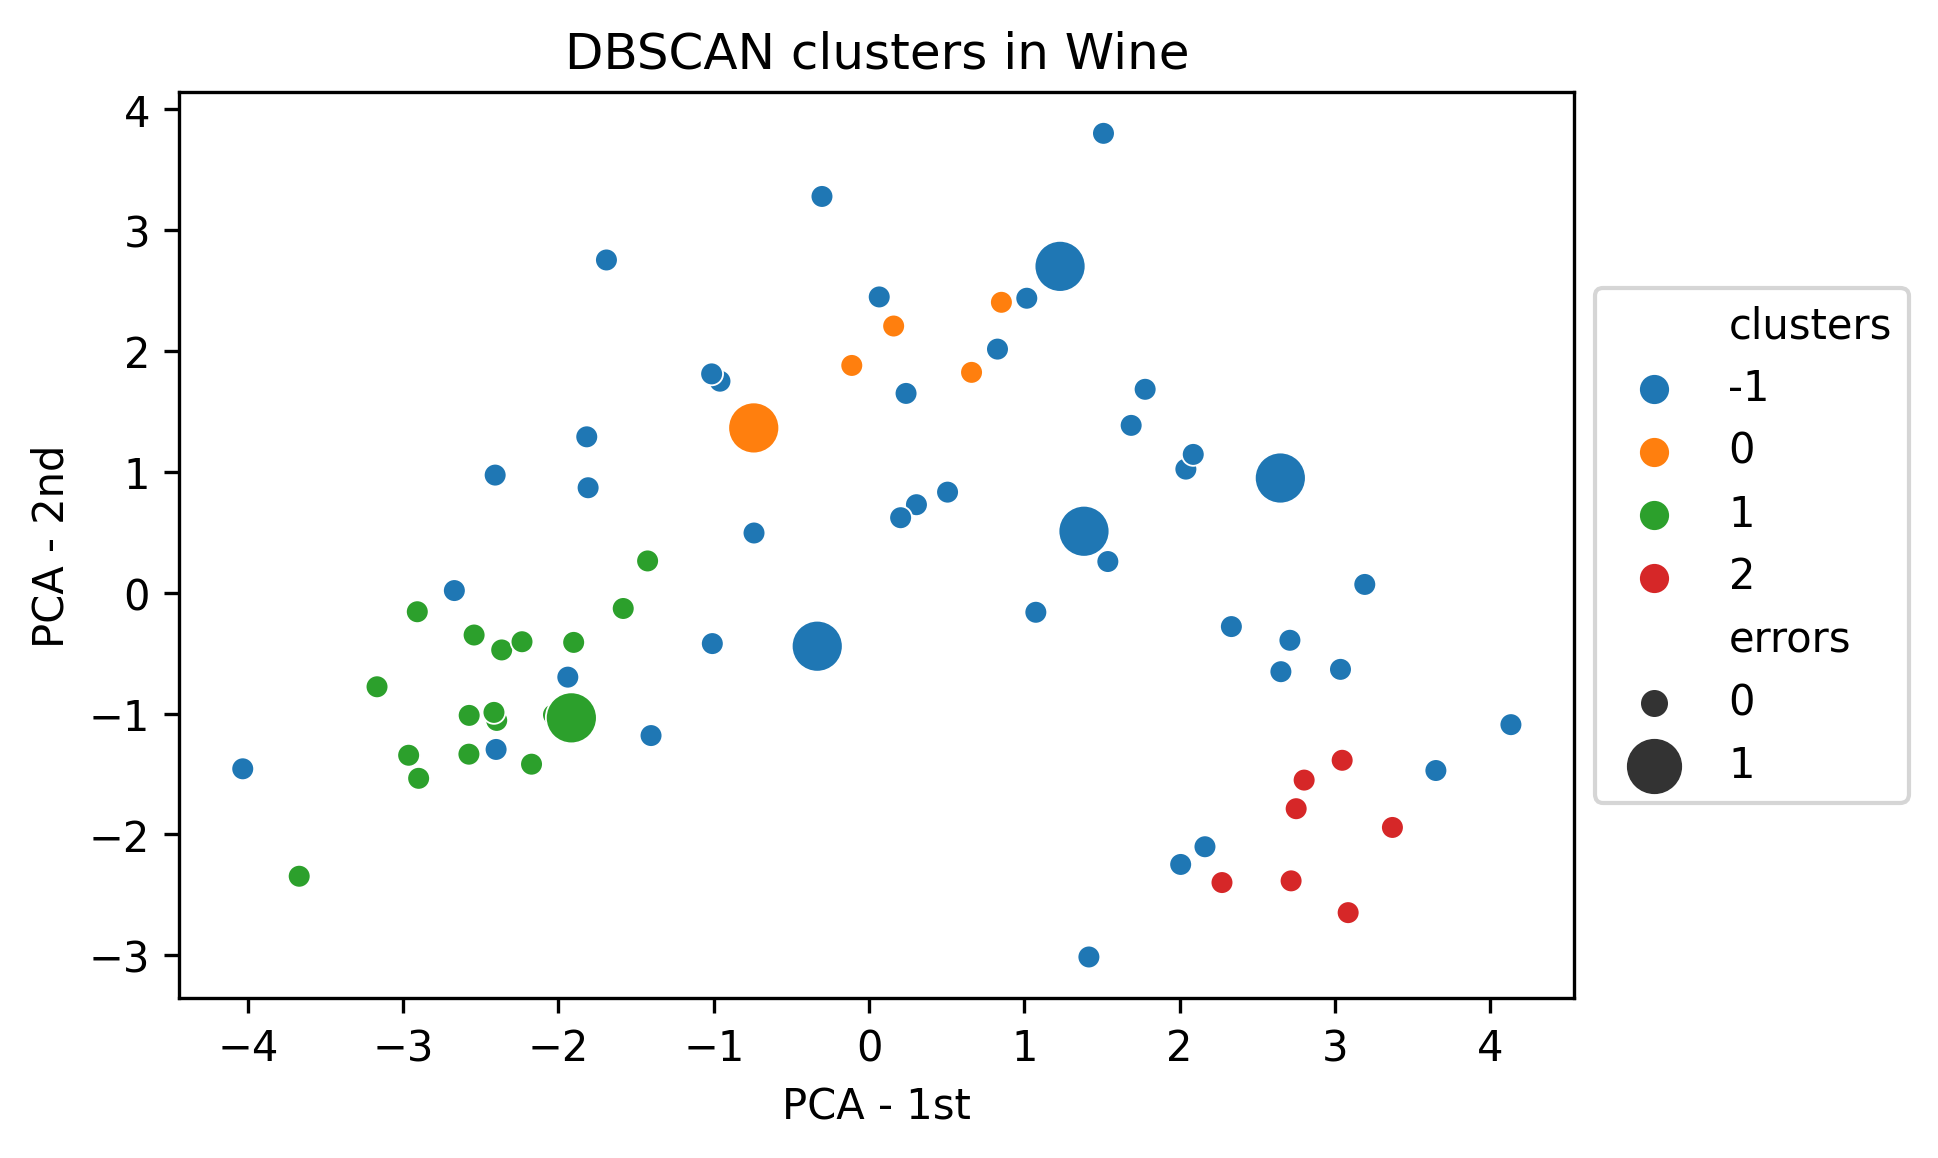

In [62]:
# Baseline DBSCAN

epsilon = 2
min_samples = 3
full_data['clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=3).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)

pca_plot(full_data)

In [107]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

2 has bias -0.09090909090909083
0 has bias -0.007822685788787531
1 has bias 0.09230769230769231
cluster 2 has the highest negative bias
[2 0 1]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.09090909090909083


In [64]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



Number of instances in discriminated cluster: 5
Number of errors in discriminated clusters:  1


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
101 -0.554648   -0.822143 -1.438148          -0.100709  -0.793991   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
106 -0.999638   -0.481192 -0.691988           0.039815  -1.246801   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
101      -1.259563   -0.660111             -0.525631        -0.416026   
81       -0.130285    0.431307             -0.766684         0.245068   
106      -0.958422   -0.035111              0.117179         0.024704   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
101        -1.247121  0.361193                      0.240588 -0.557596   
81         -0.591864  0.884802                      0.755802 -0.099050   
106        -0.817815  0.186657                      0.797576 -0.714467   

     scaled_errors  predicted_class  true_class  errors  clusters  \
104            0.0                1           1       0         0   
67             0.0                1           1       0         0   
101            0.0                1           1       0         0   
81             0.8                0           1       1         0   
106            0.0                1           1       0         0   

     new_clusters  
104           0.0  
67            0.0  
101           0.0  
81            0.0  
106           0.0

## 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [130]:
full_data = initialize_dataset(raw_data)
bandwidth_features = full_data.iloc[: , : 14]
bandwidth_features.head()
# bandwidth_features = full_data.iloc[: , : 24]

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
118 -0.338510    1.005004 -1.166817          -0.803327  -1.246801   
39   1.505019    1.494574  0.630750          -1.590260   1.470062   
176  0.170050    0.270648  0.155921           0.320862   1.017252   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
118      -0.988536   -0.762724              0.599286        -1.234524   
39        1.074278    0.907054             -1.248791         0.733019   
176      -0.958422   -1.294440              1.402798        -0.242882   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
118        -0.817815 -1.122366                     -0.664518 -1.130778   
39         -0.049584 -0.293318                      1.298865  0.039721   
176         1.848400 -1.558707                     -1.360753  0.281061   

     scaled_errors  
104            0.0  
67             0.0  
118            0.8  
39             0.0  
176            0.0

estimated bandwidth:  2


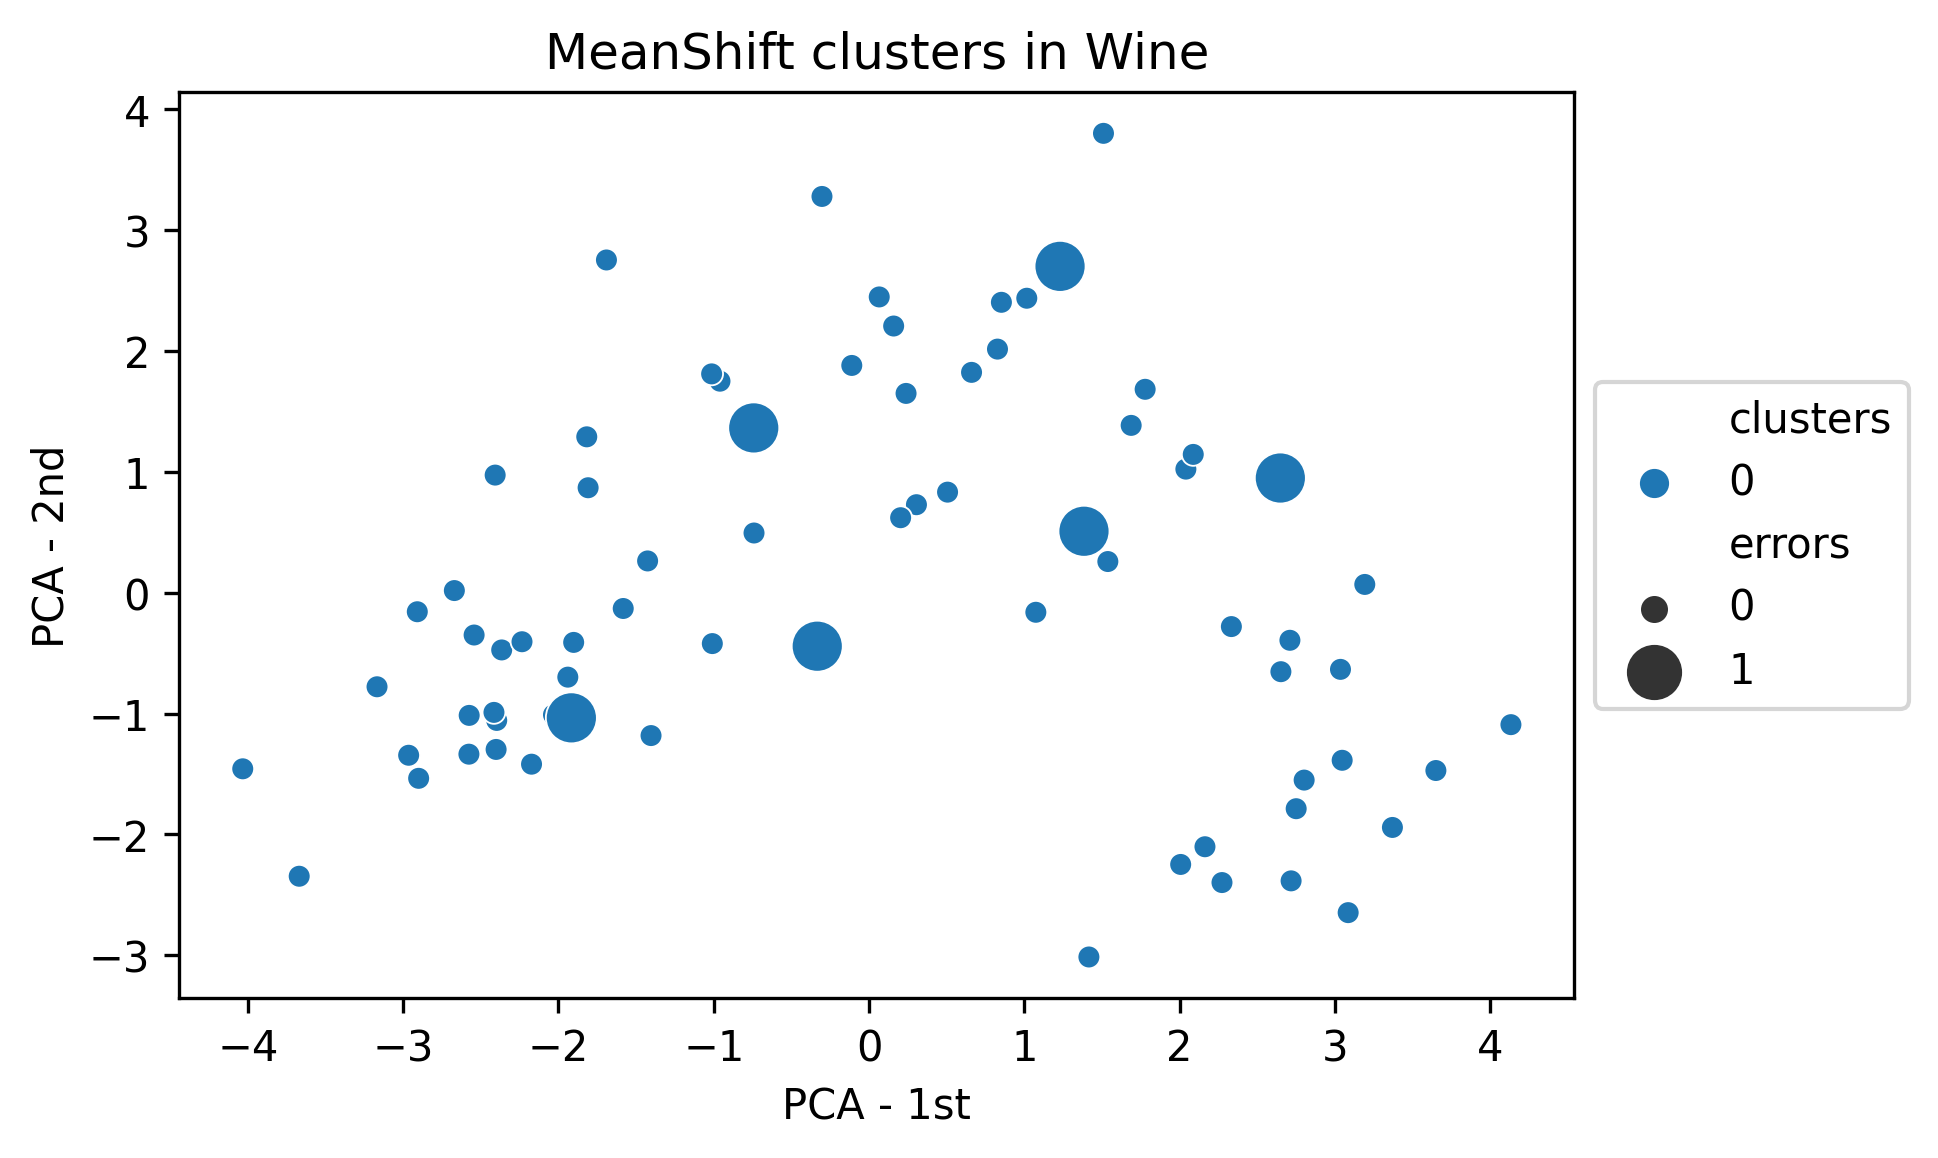

average_accuracy is:  0.9166666666666666
smallest cluster: 1


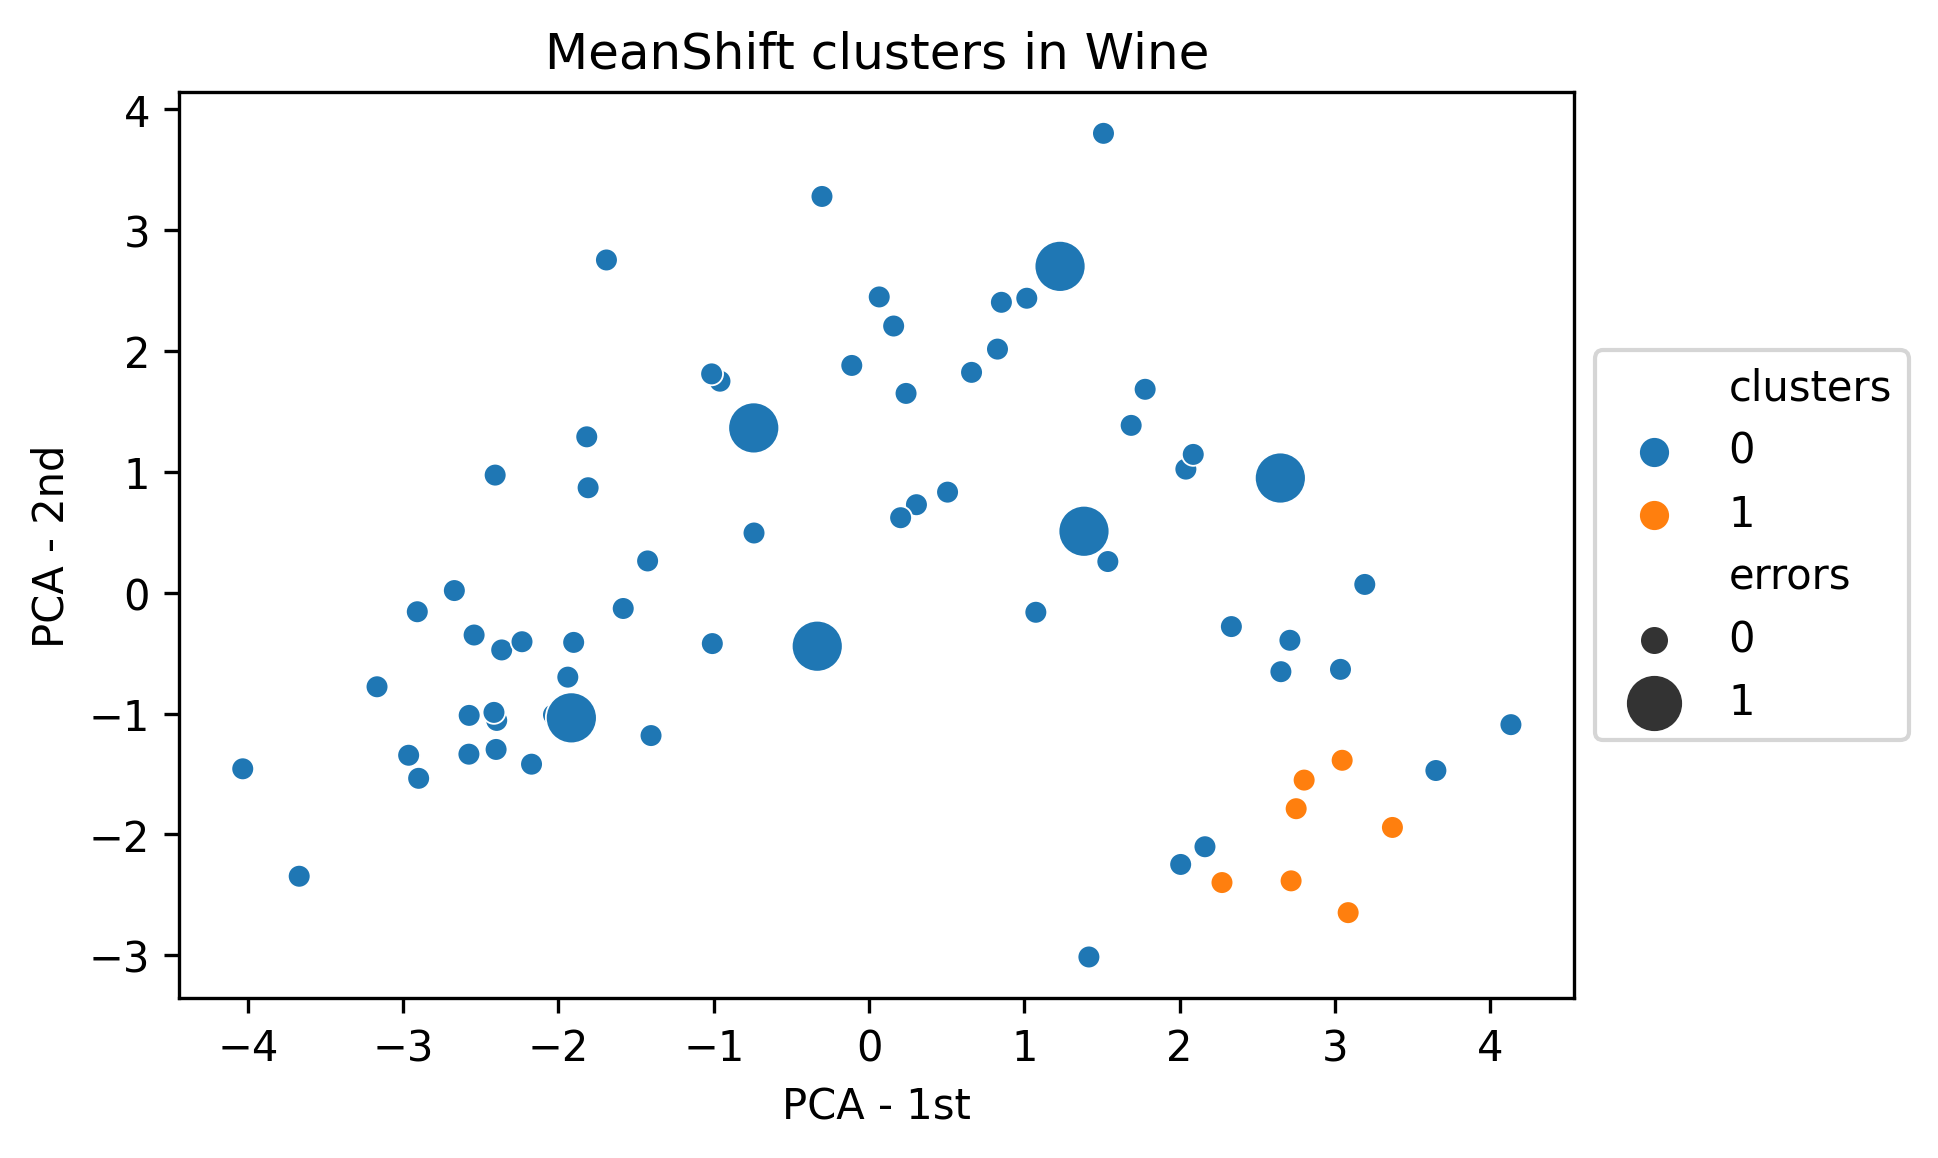

--> Cluster with the highest variance: 0
smallest cluster: 1


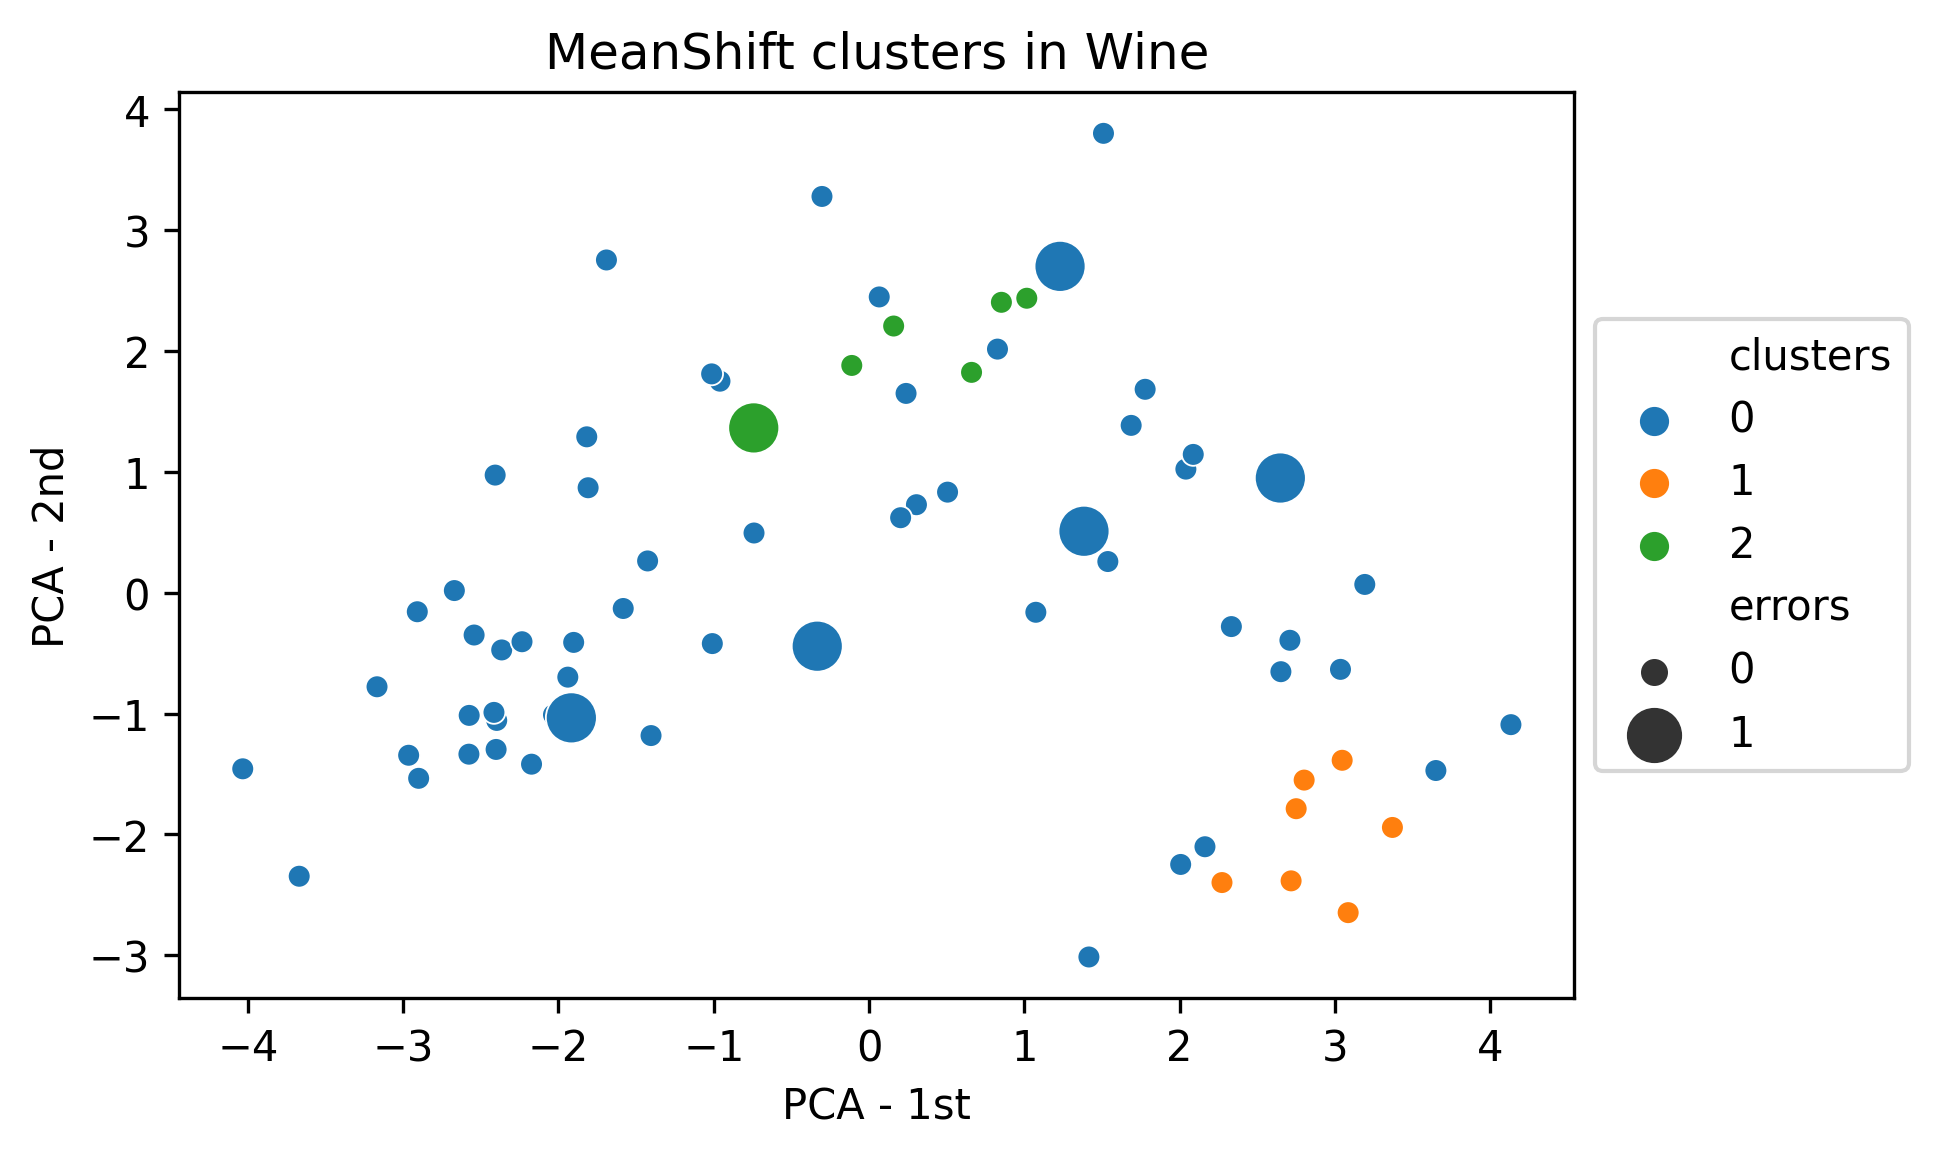

--> Cluster with the highest variance: 2
smallest cluster: 6


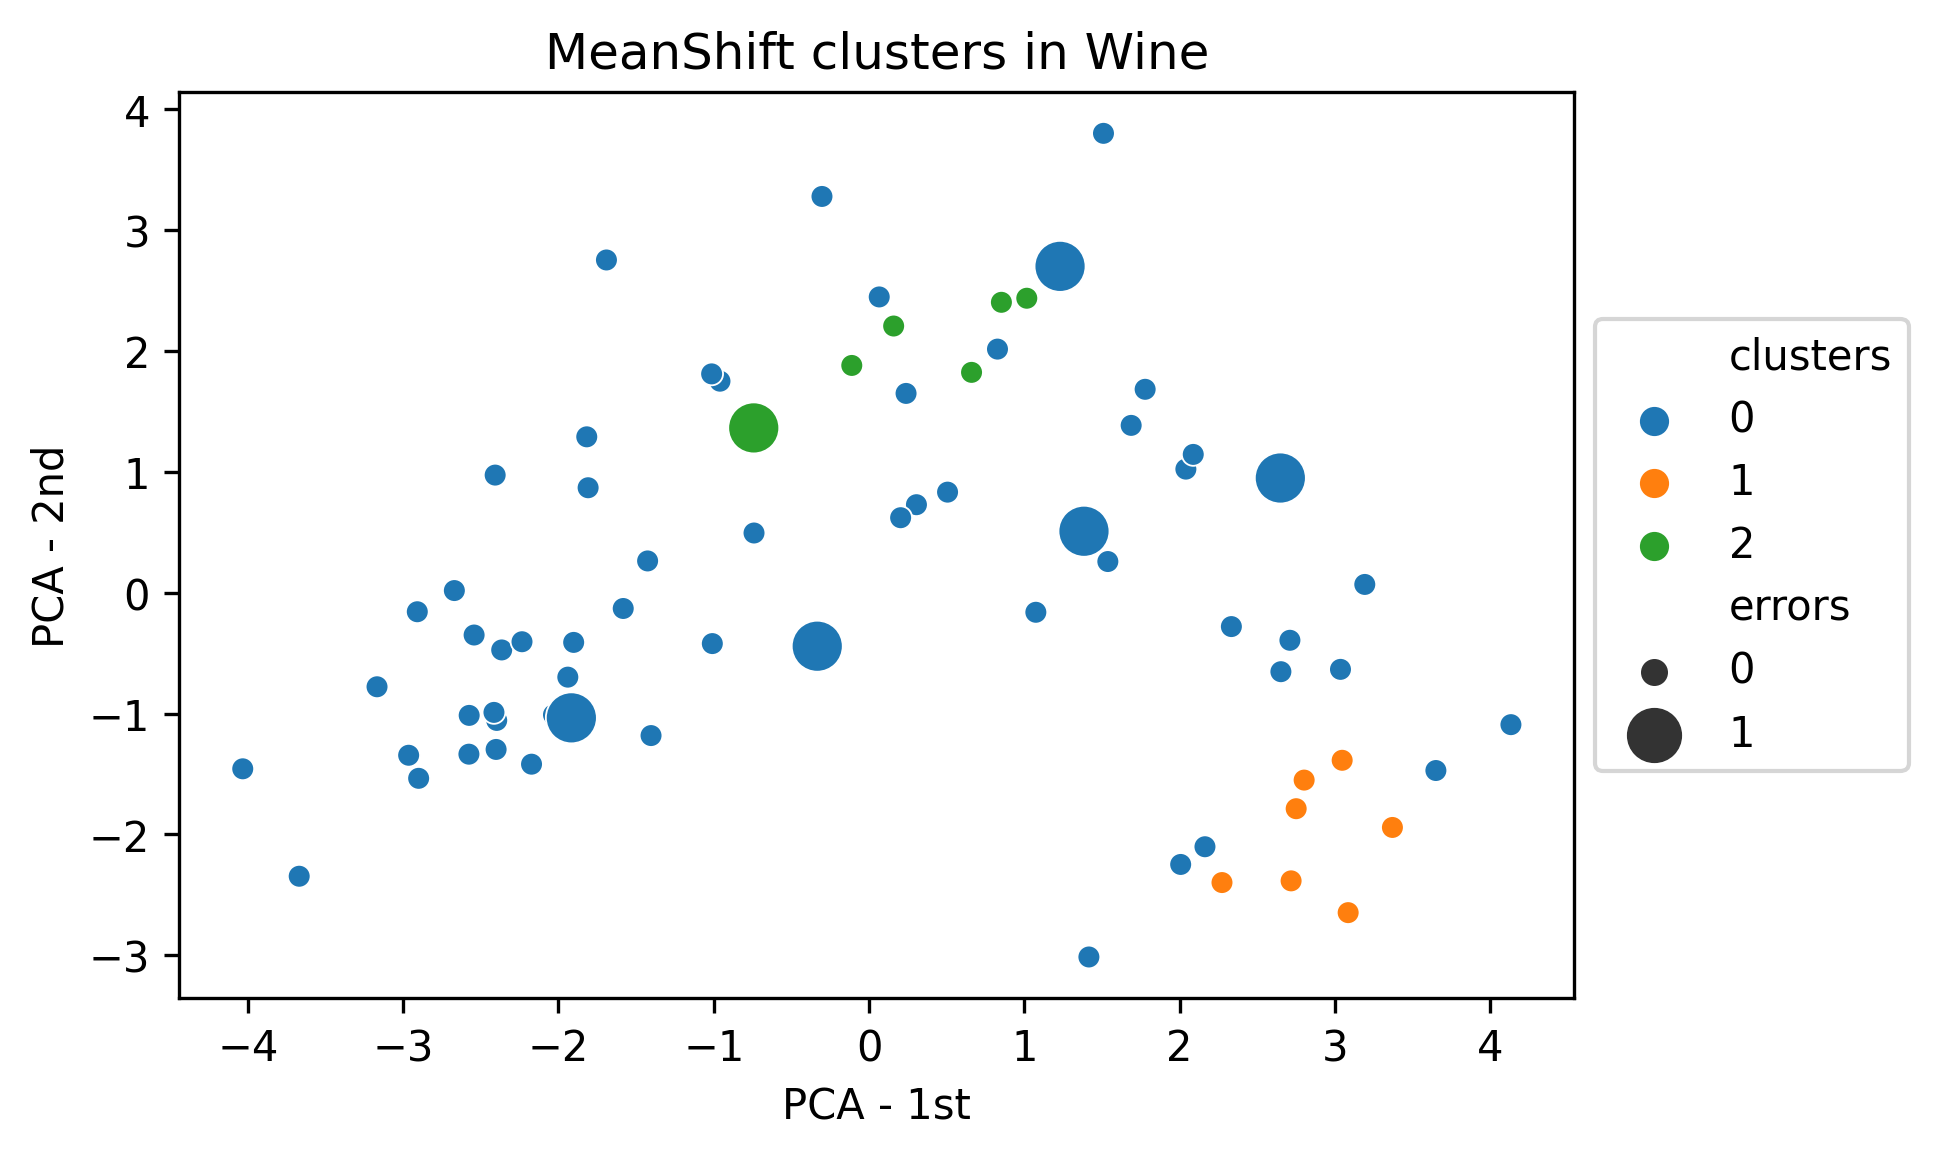

--> Cluster with the highest variance: 2
smallest cluster: 6


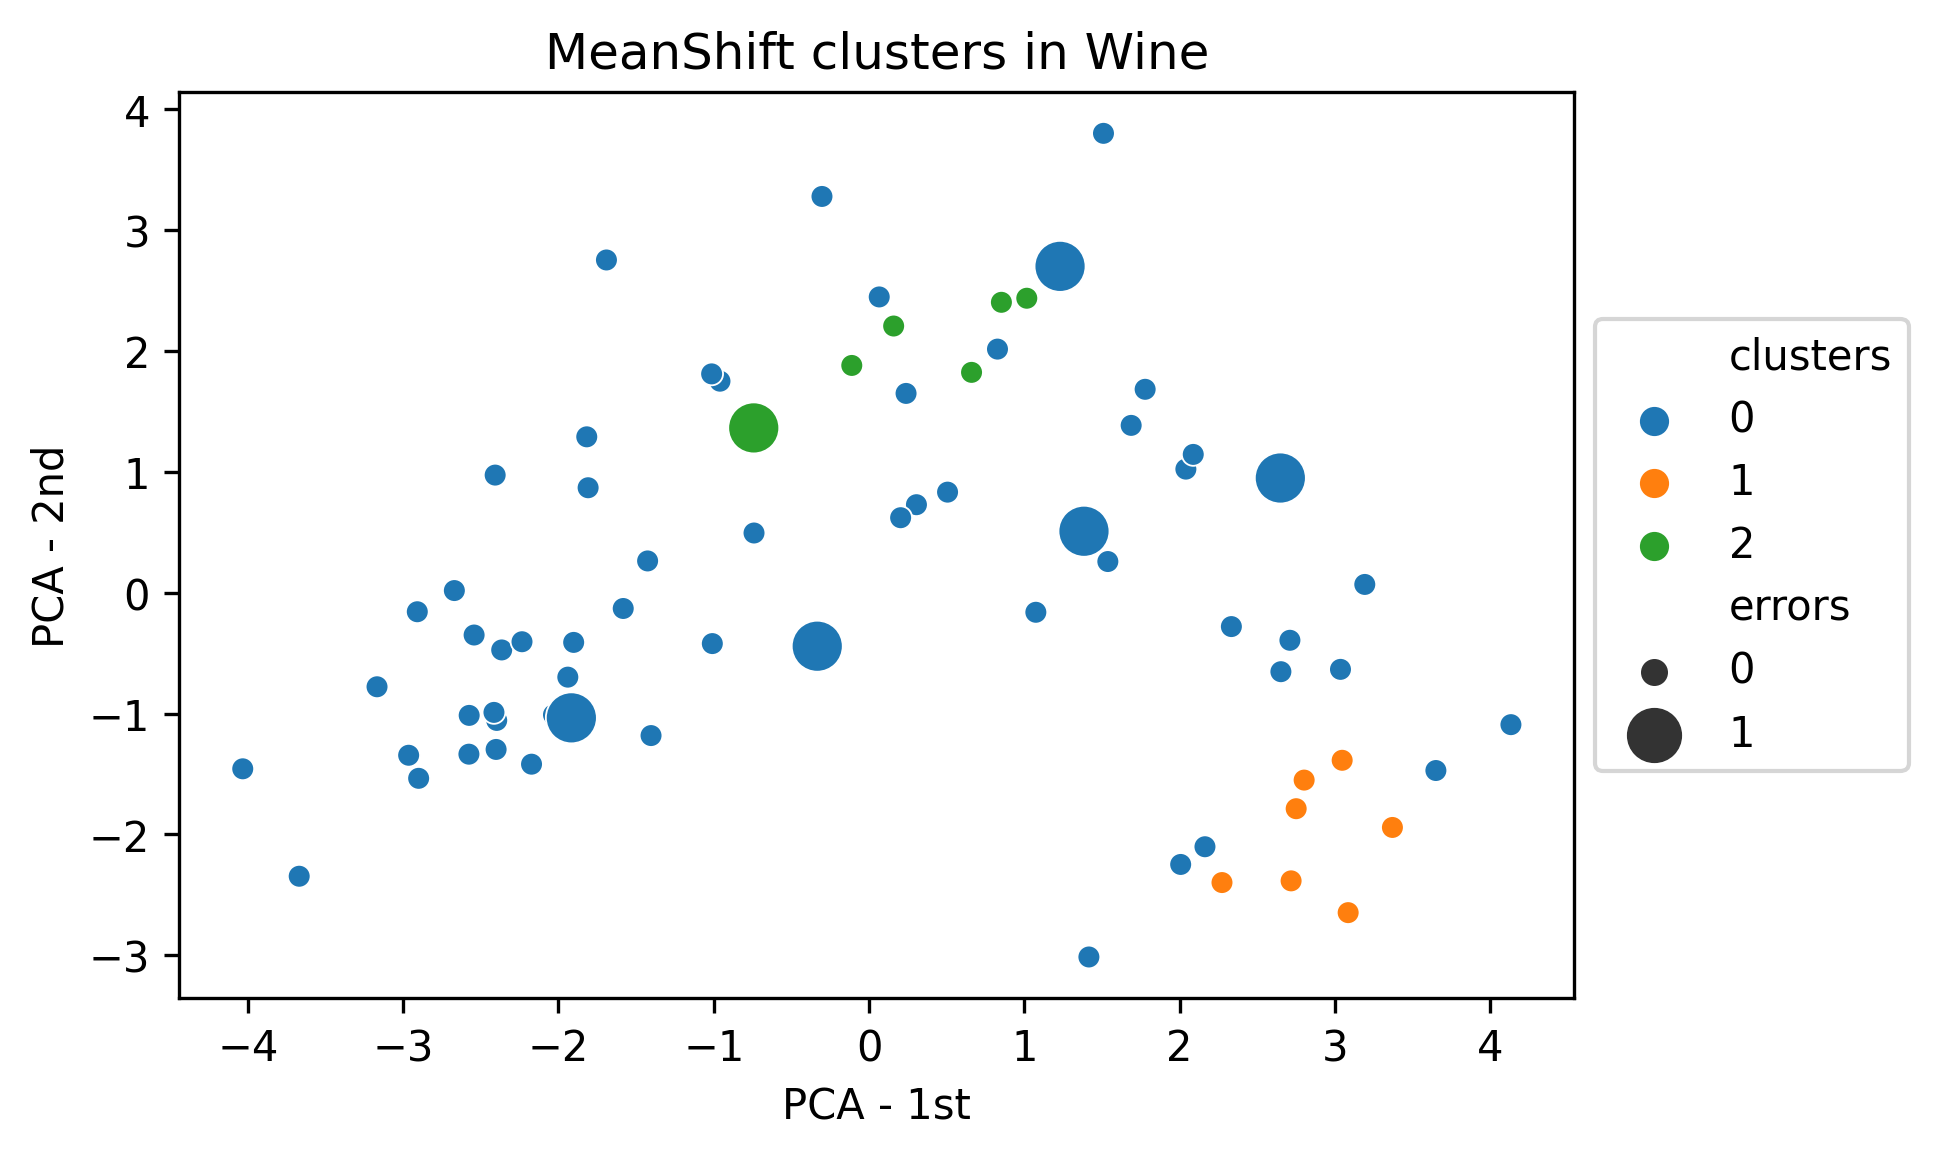

--> Cluster with the highest variance: 2
smallest cluster: 6


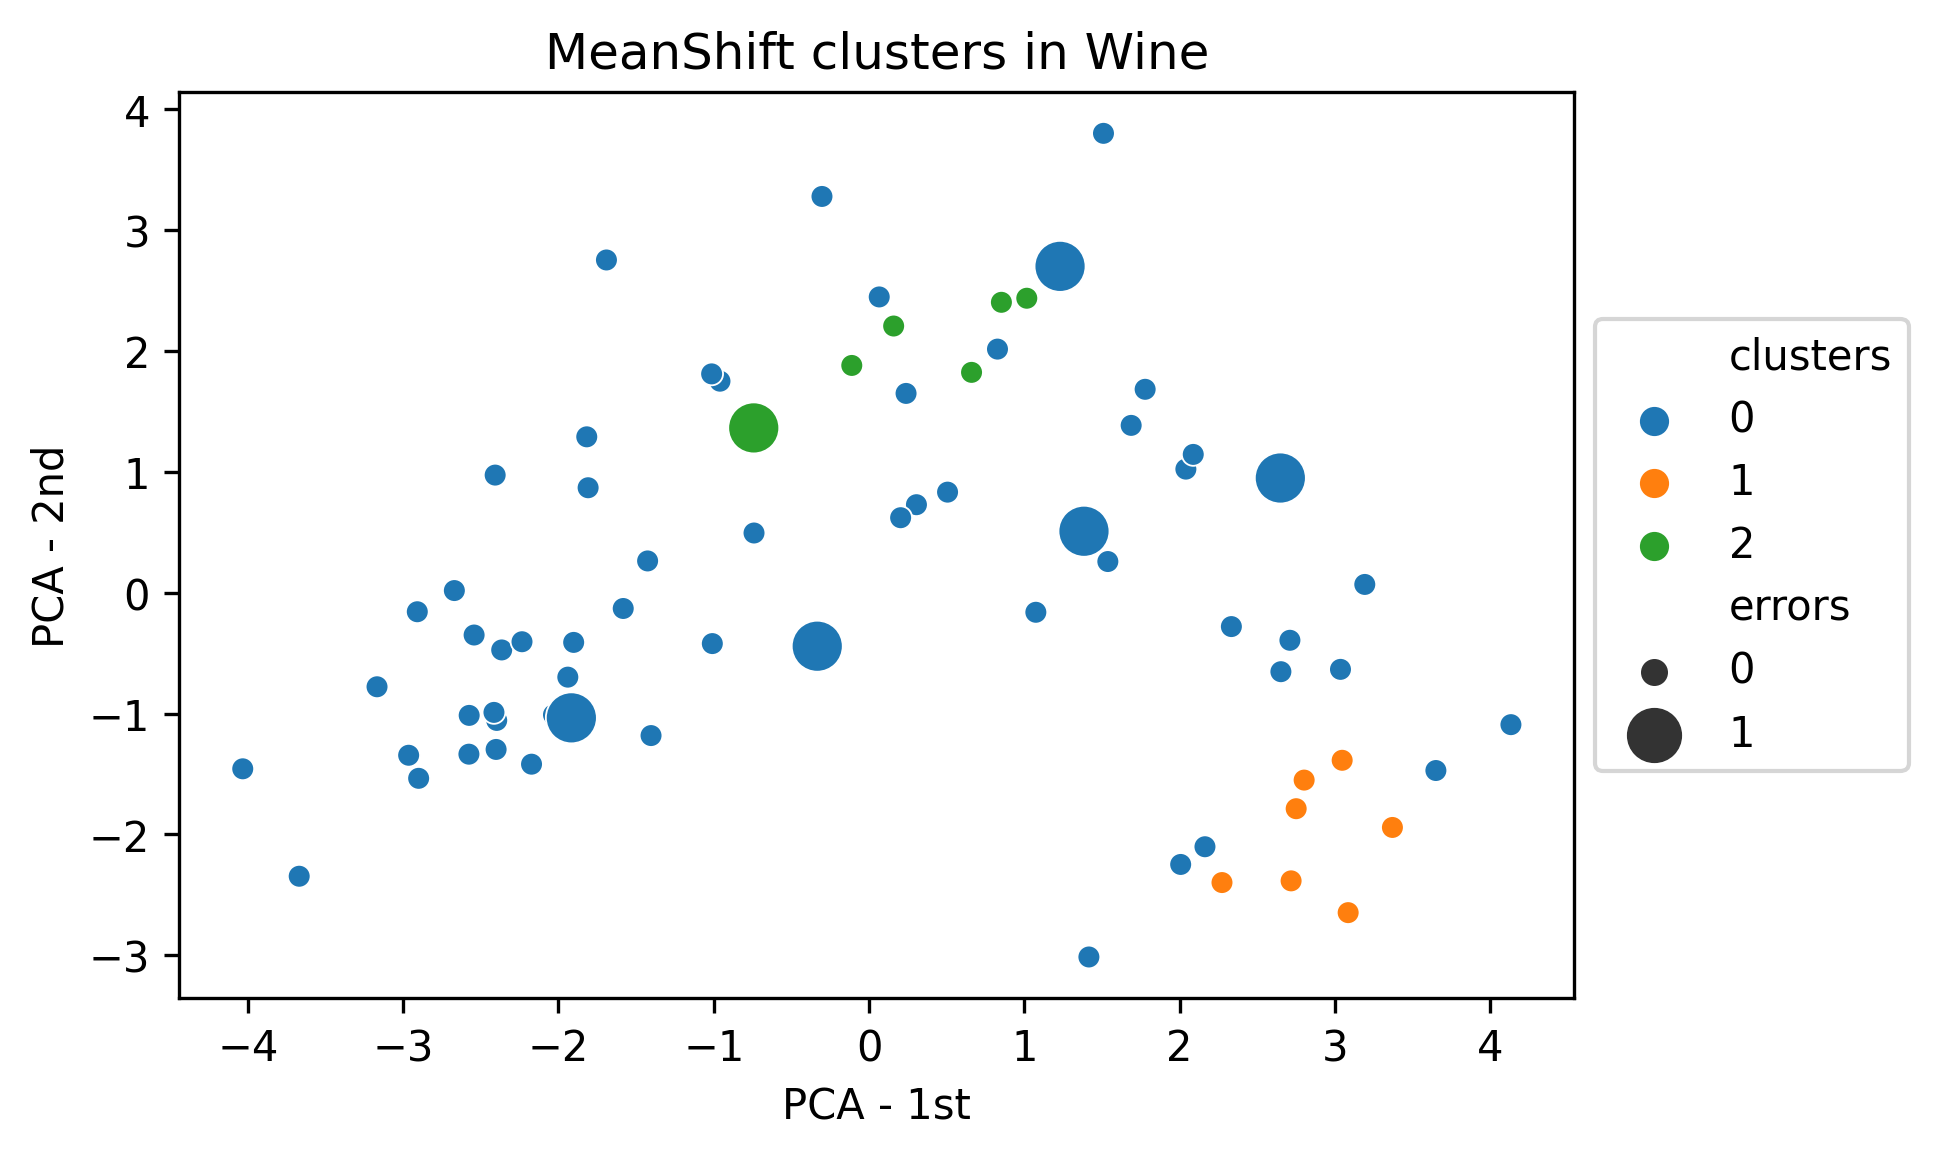

--> Cluster with the highest variance: 2
smallest cluster: 6


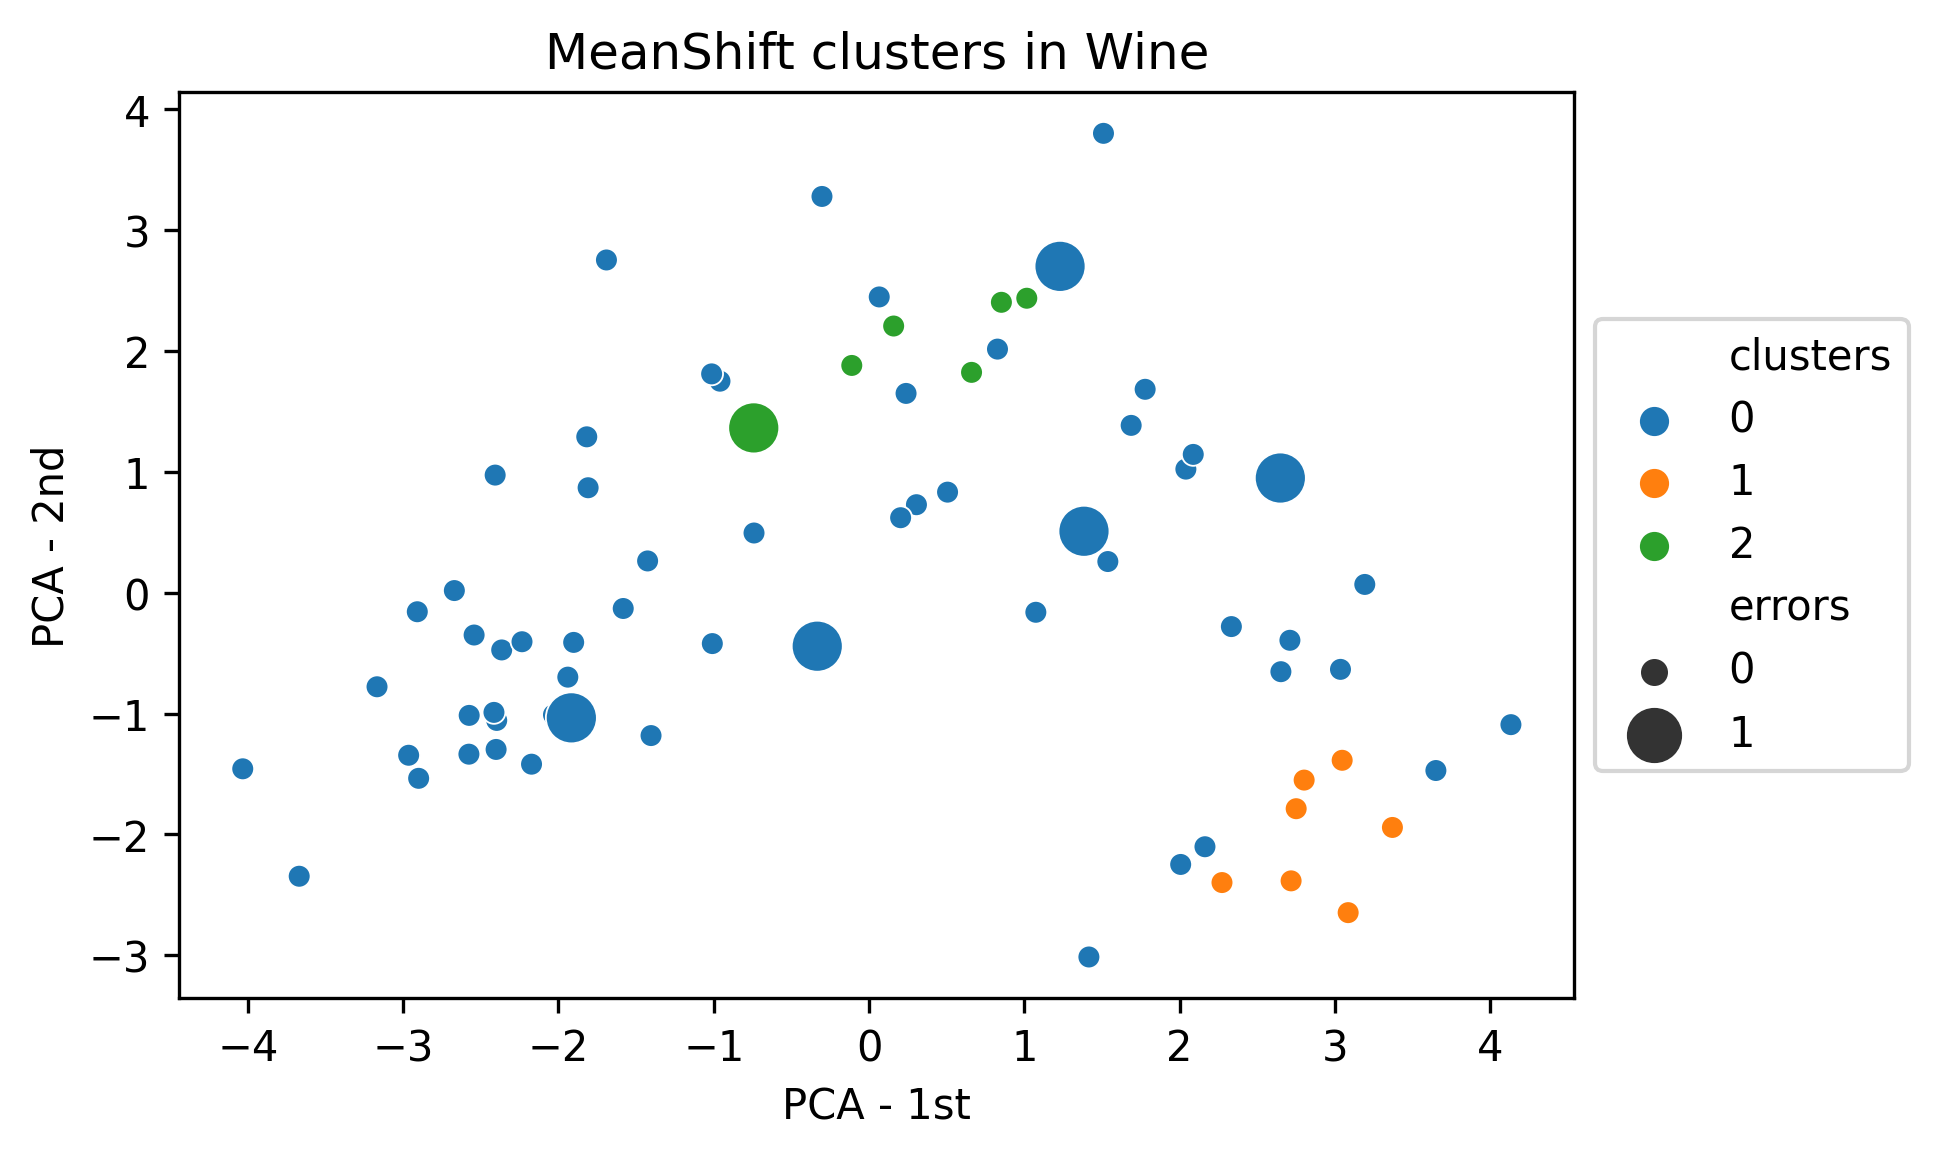

--> Cluster with the highest variance: 2
smallest cluster: 6


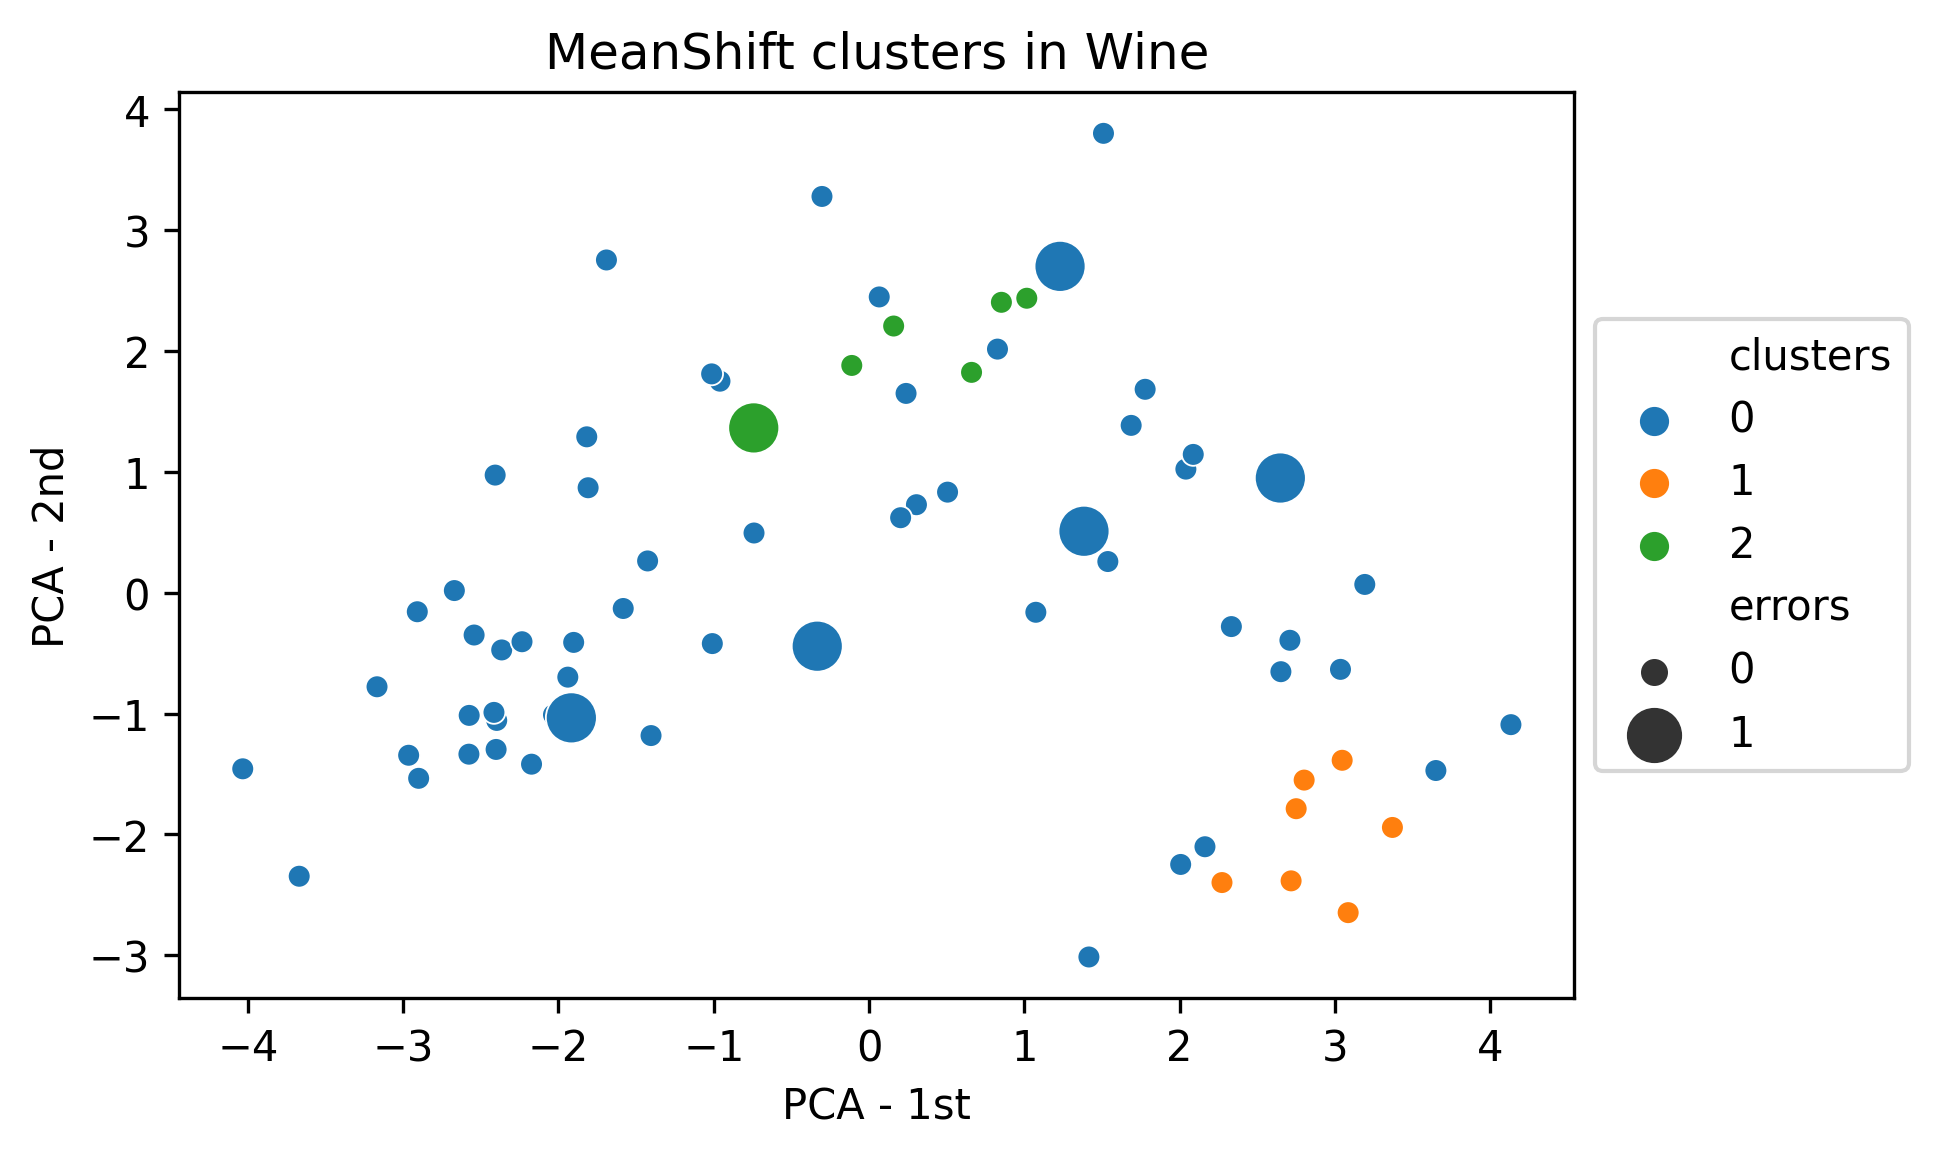

--> Cluster with the highest variance: 2
smallest cluster: 6


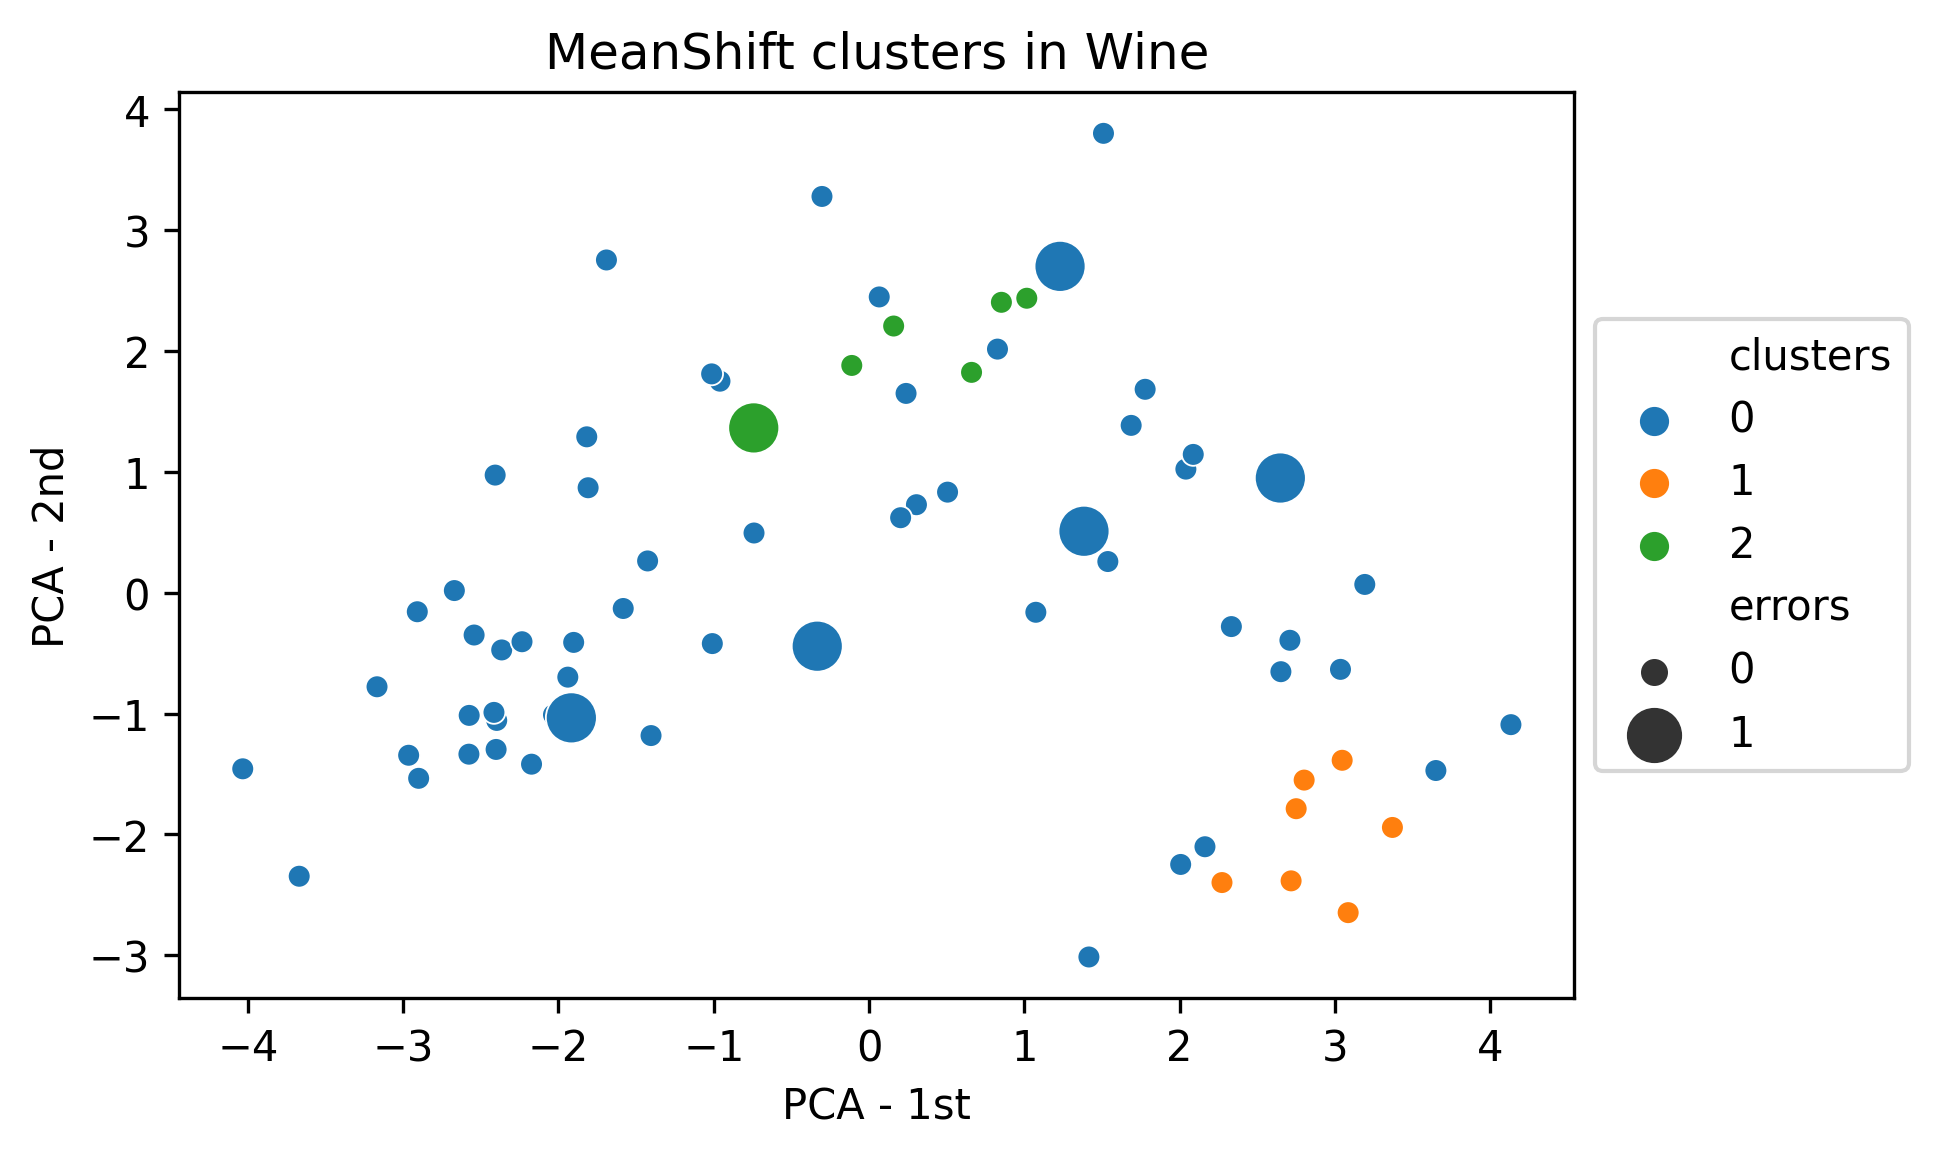

--> Cluster with the highest variance: 2
smallest cluster: 6


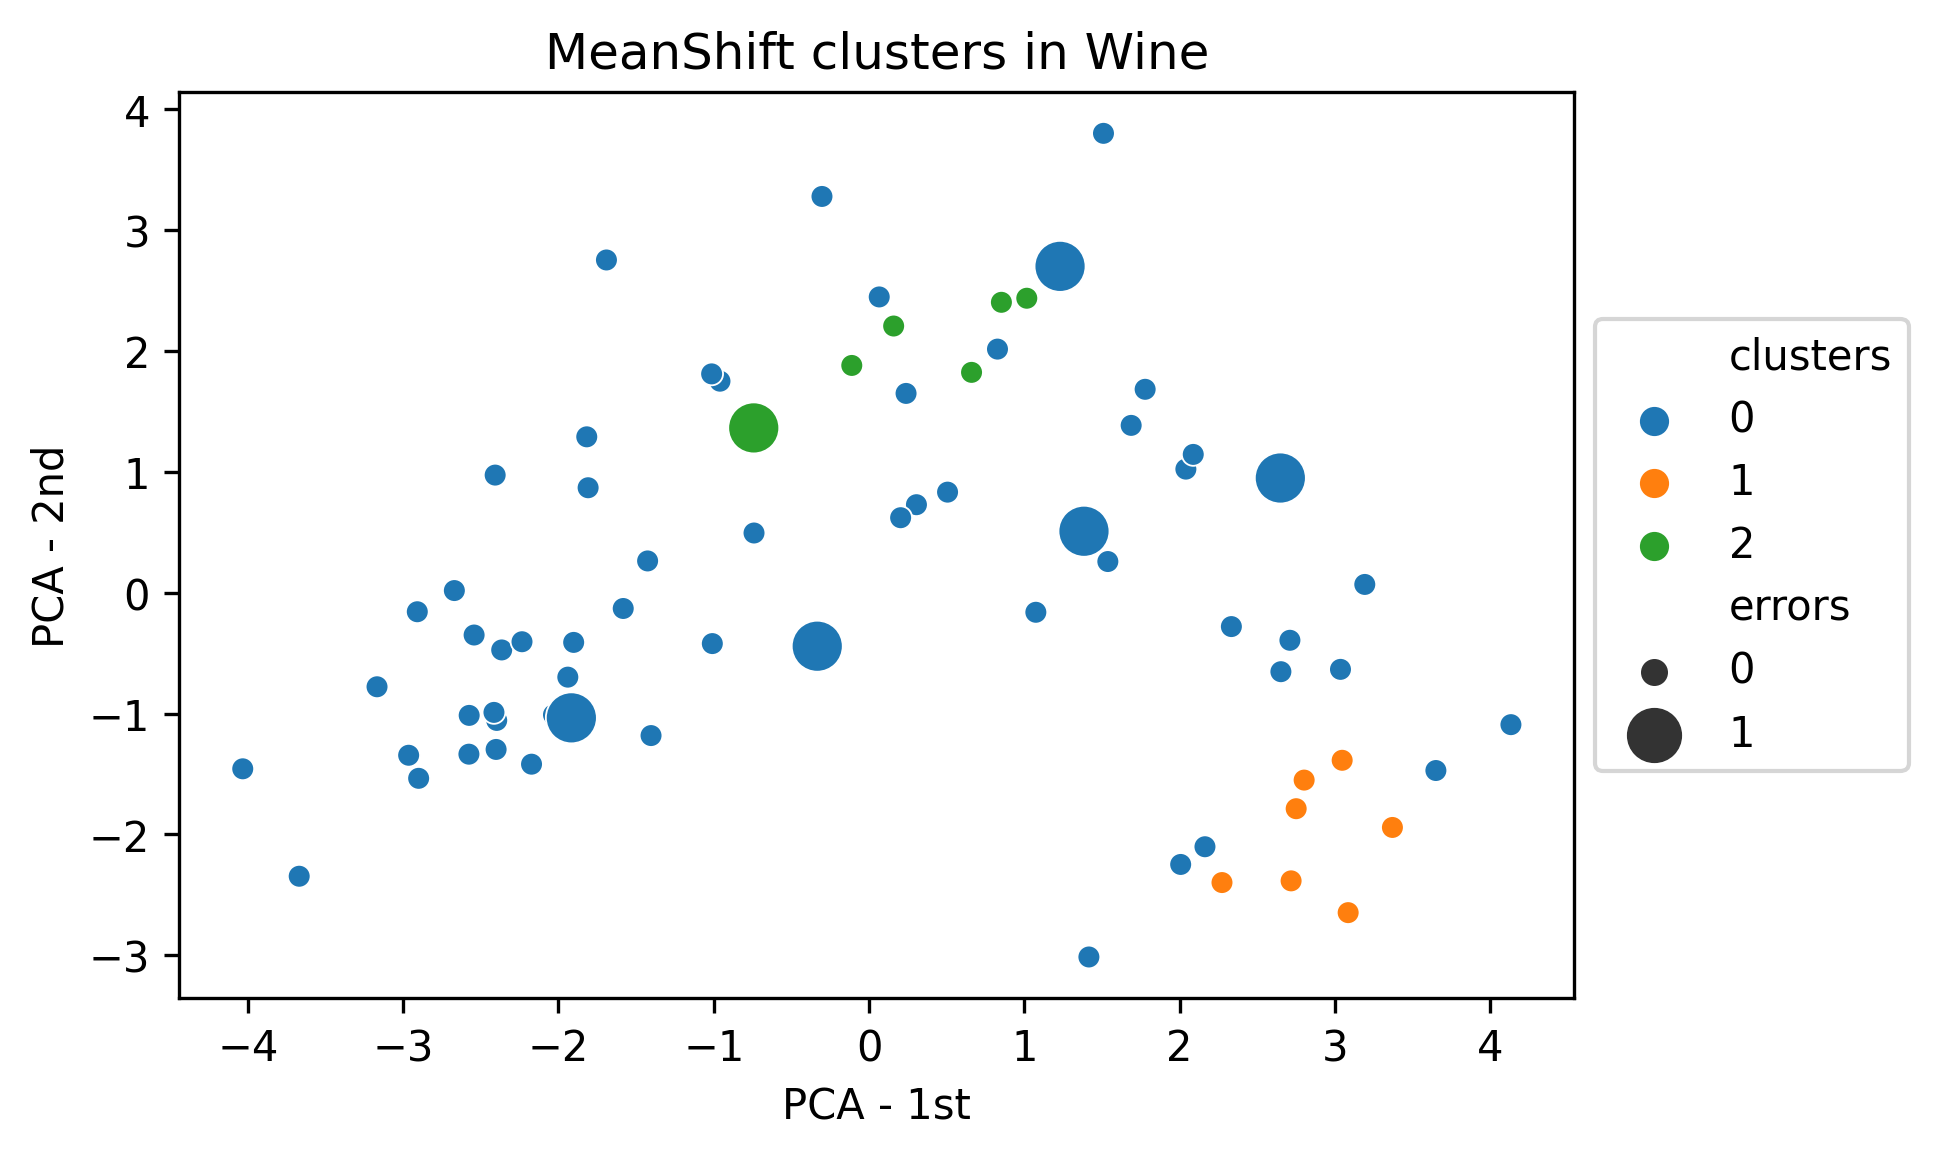

--> Cluster with the highest variance: 2
smallest cluster: 6


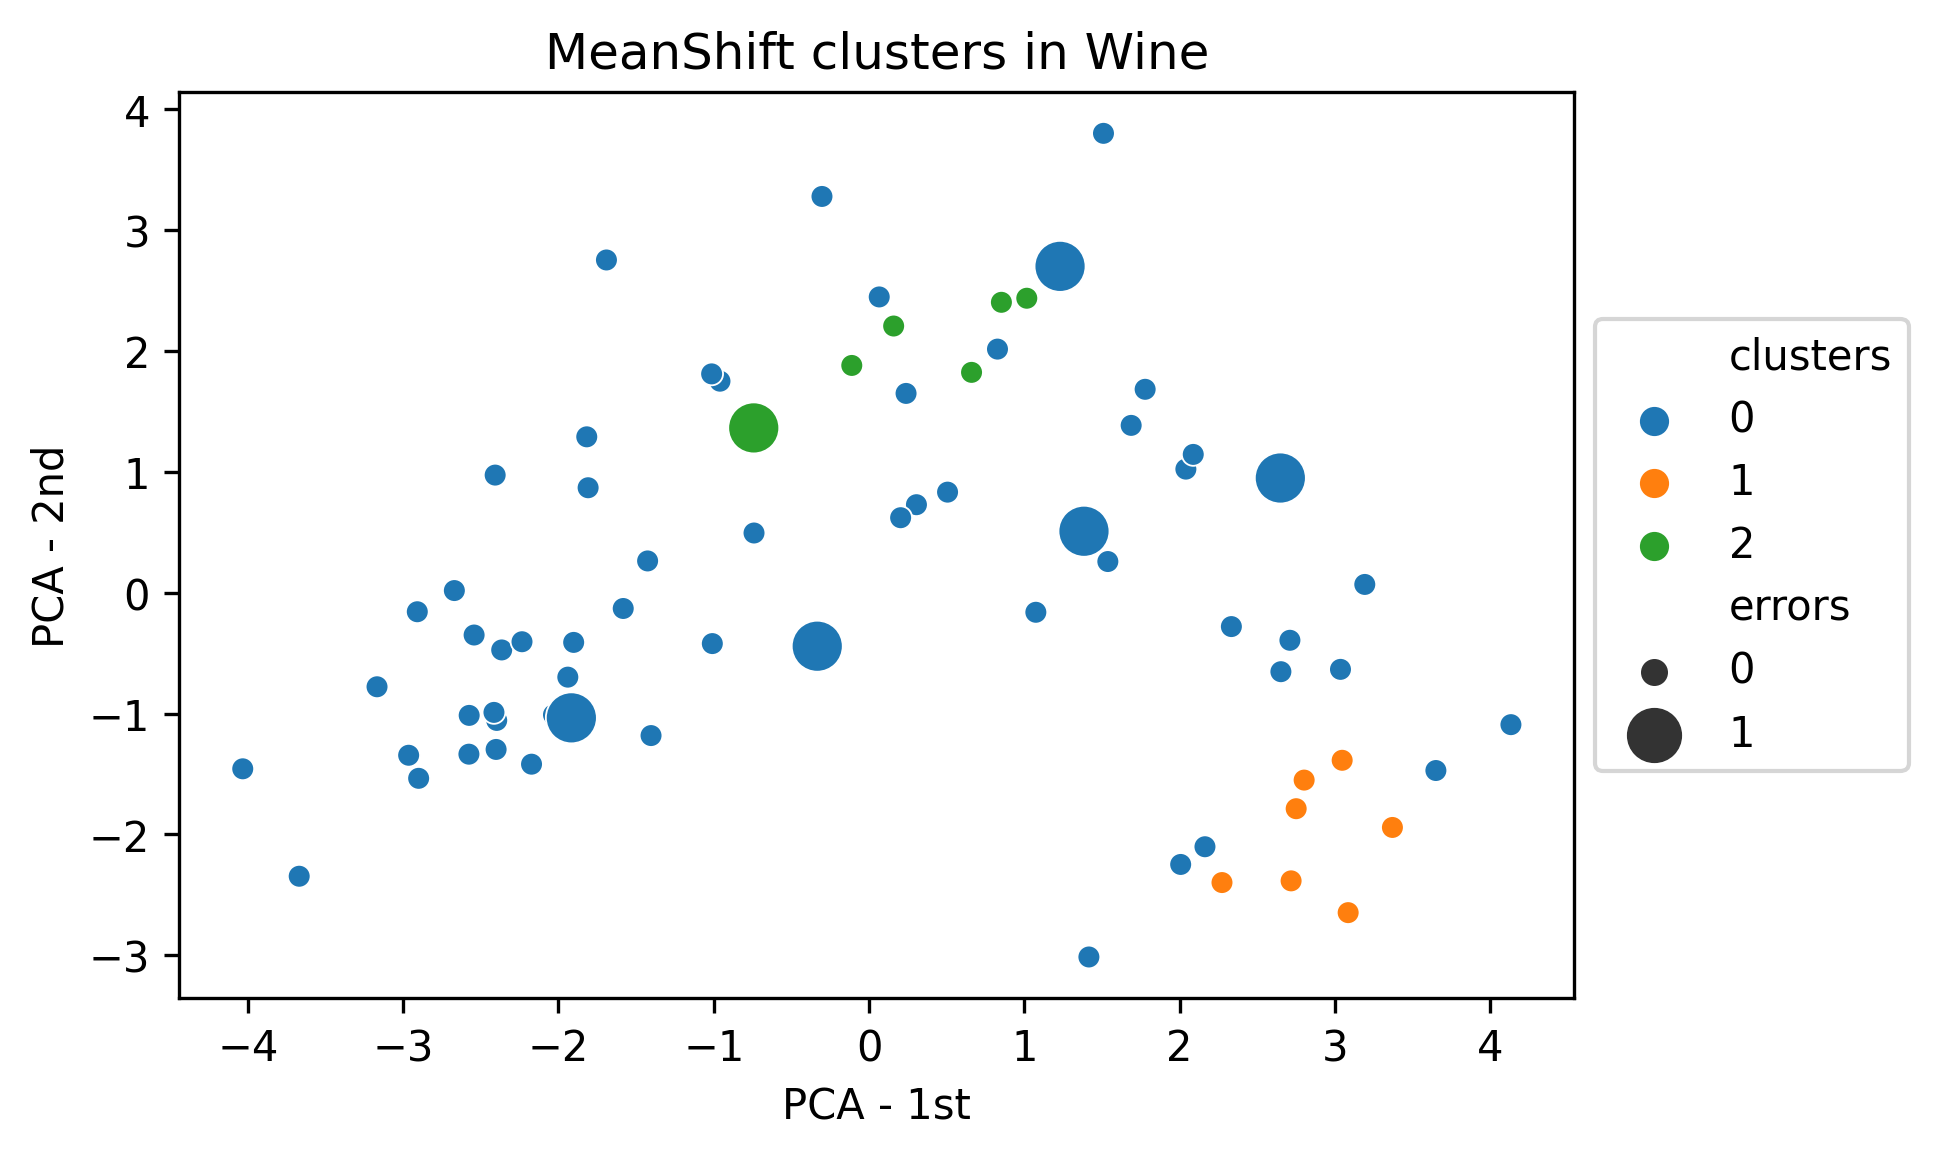

--> Cluster with the highest variance: 2
smallest cluster: 6


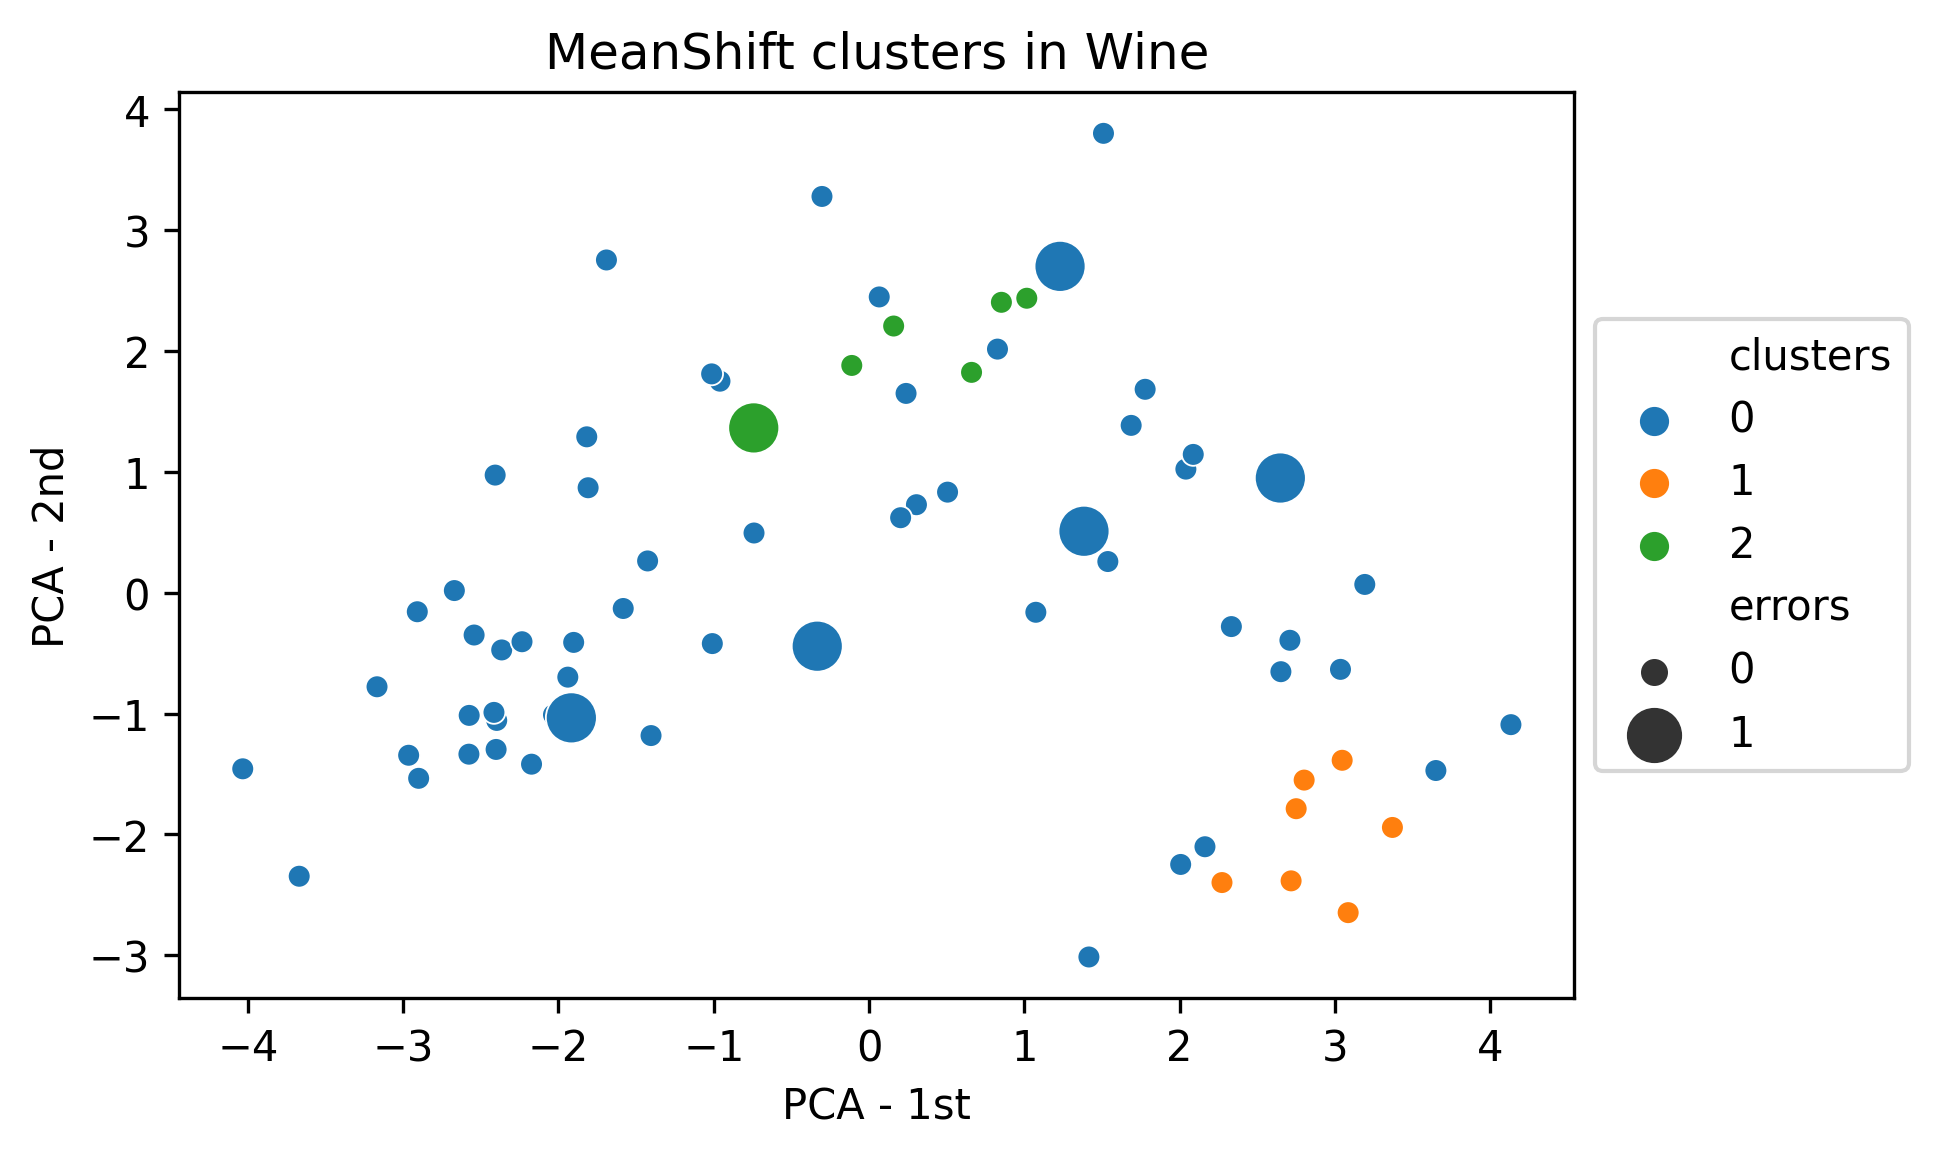

--> Cluster with the highest variance: 2
smallest cluster: 6


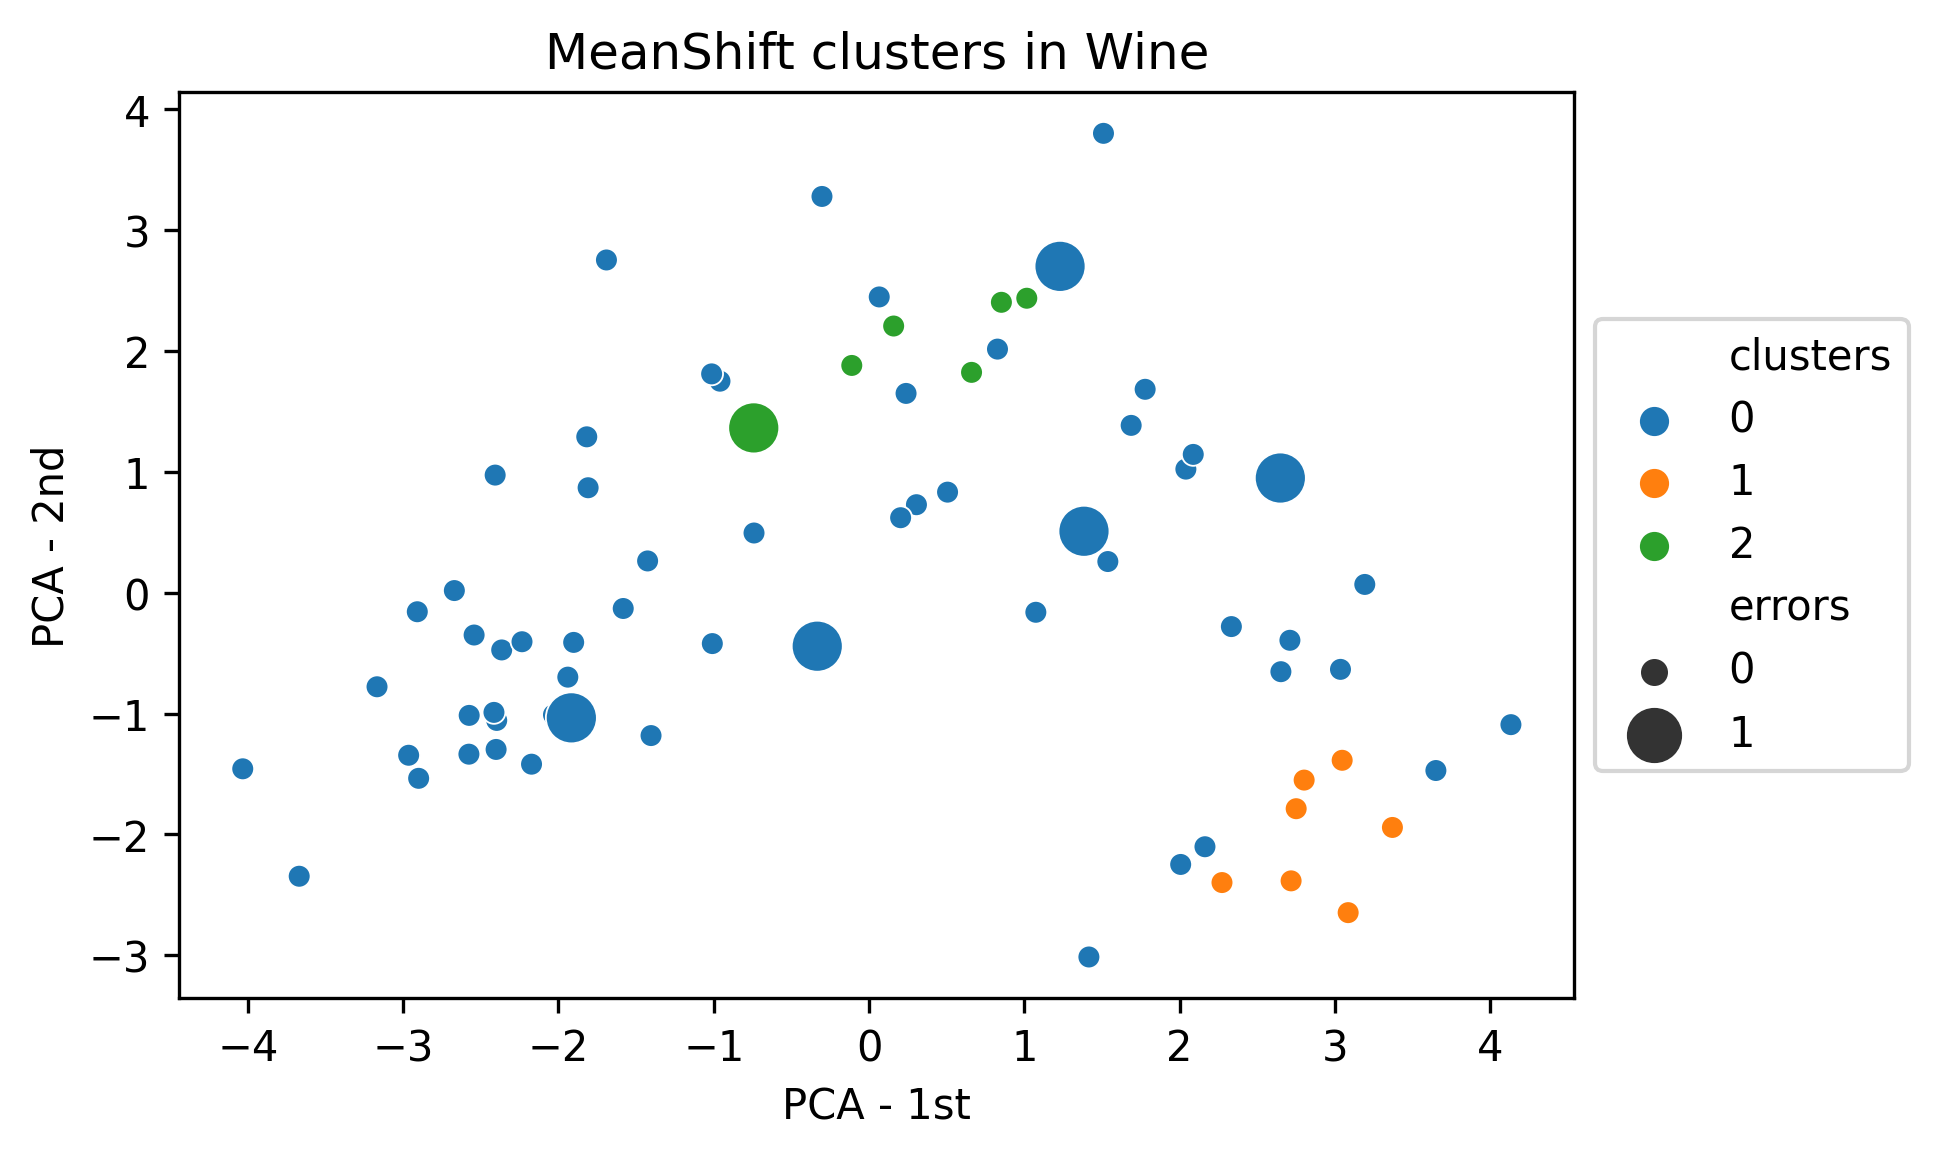

--> Cluster with the highest variance: 2
smallest cluster: 6


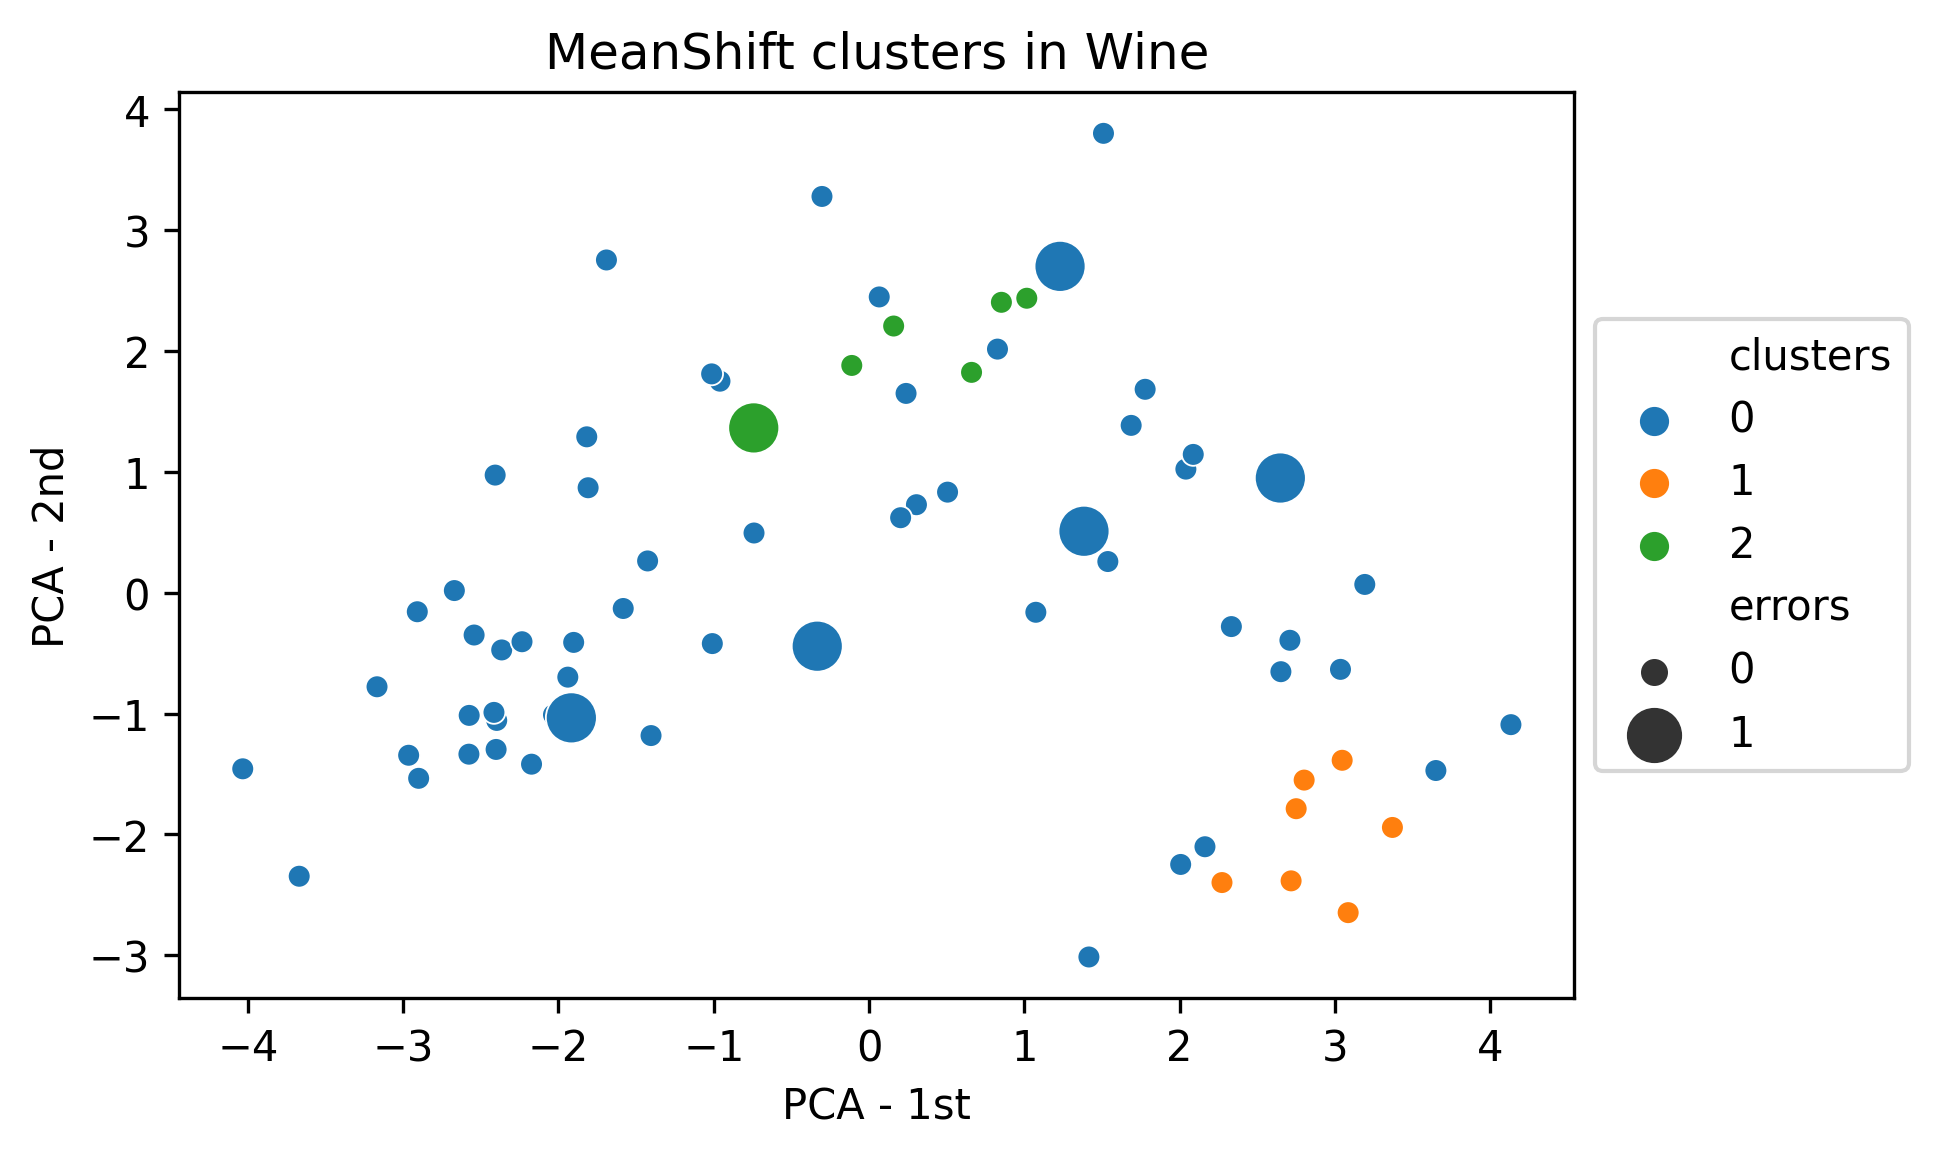

--> Cluster with the highest variance: 2
smallest cluster: 6


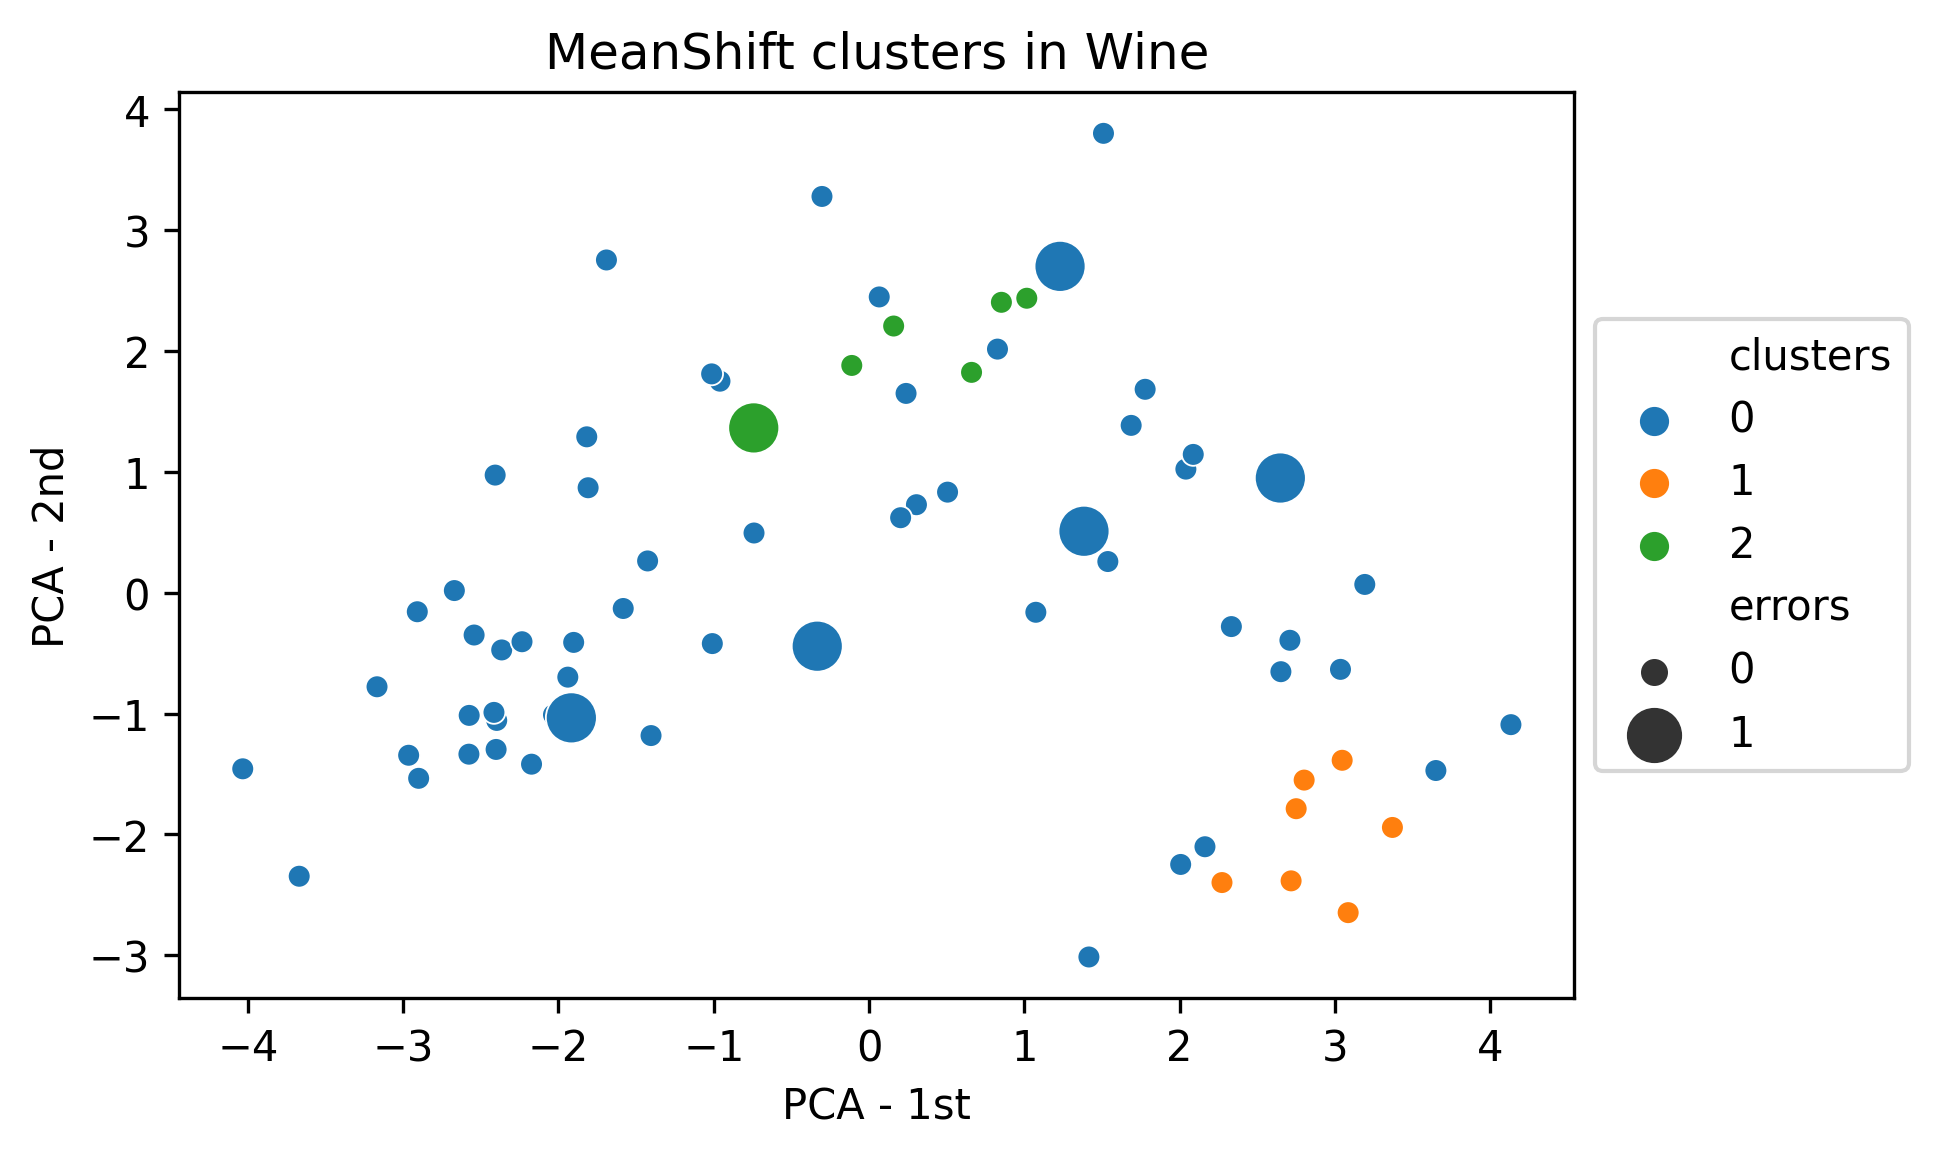

--> Cluster with the highest variance: 2
smallest cluster: 6


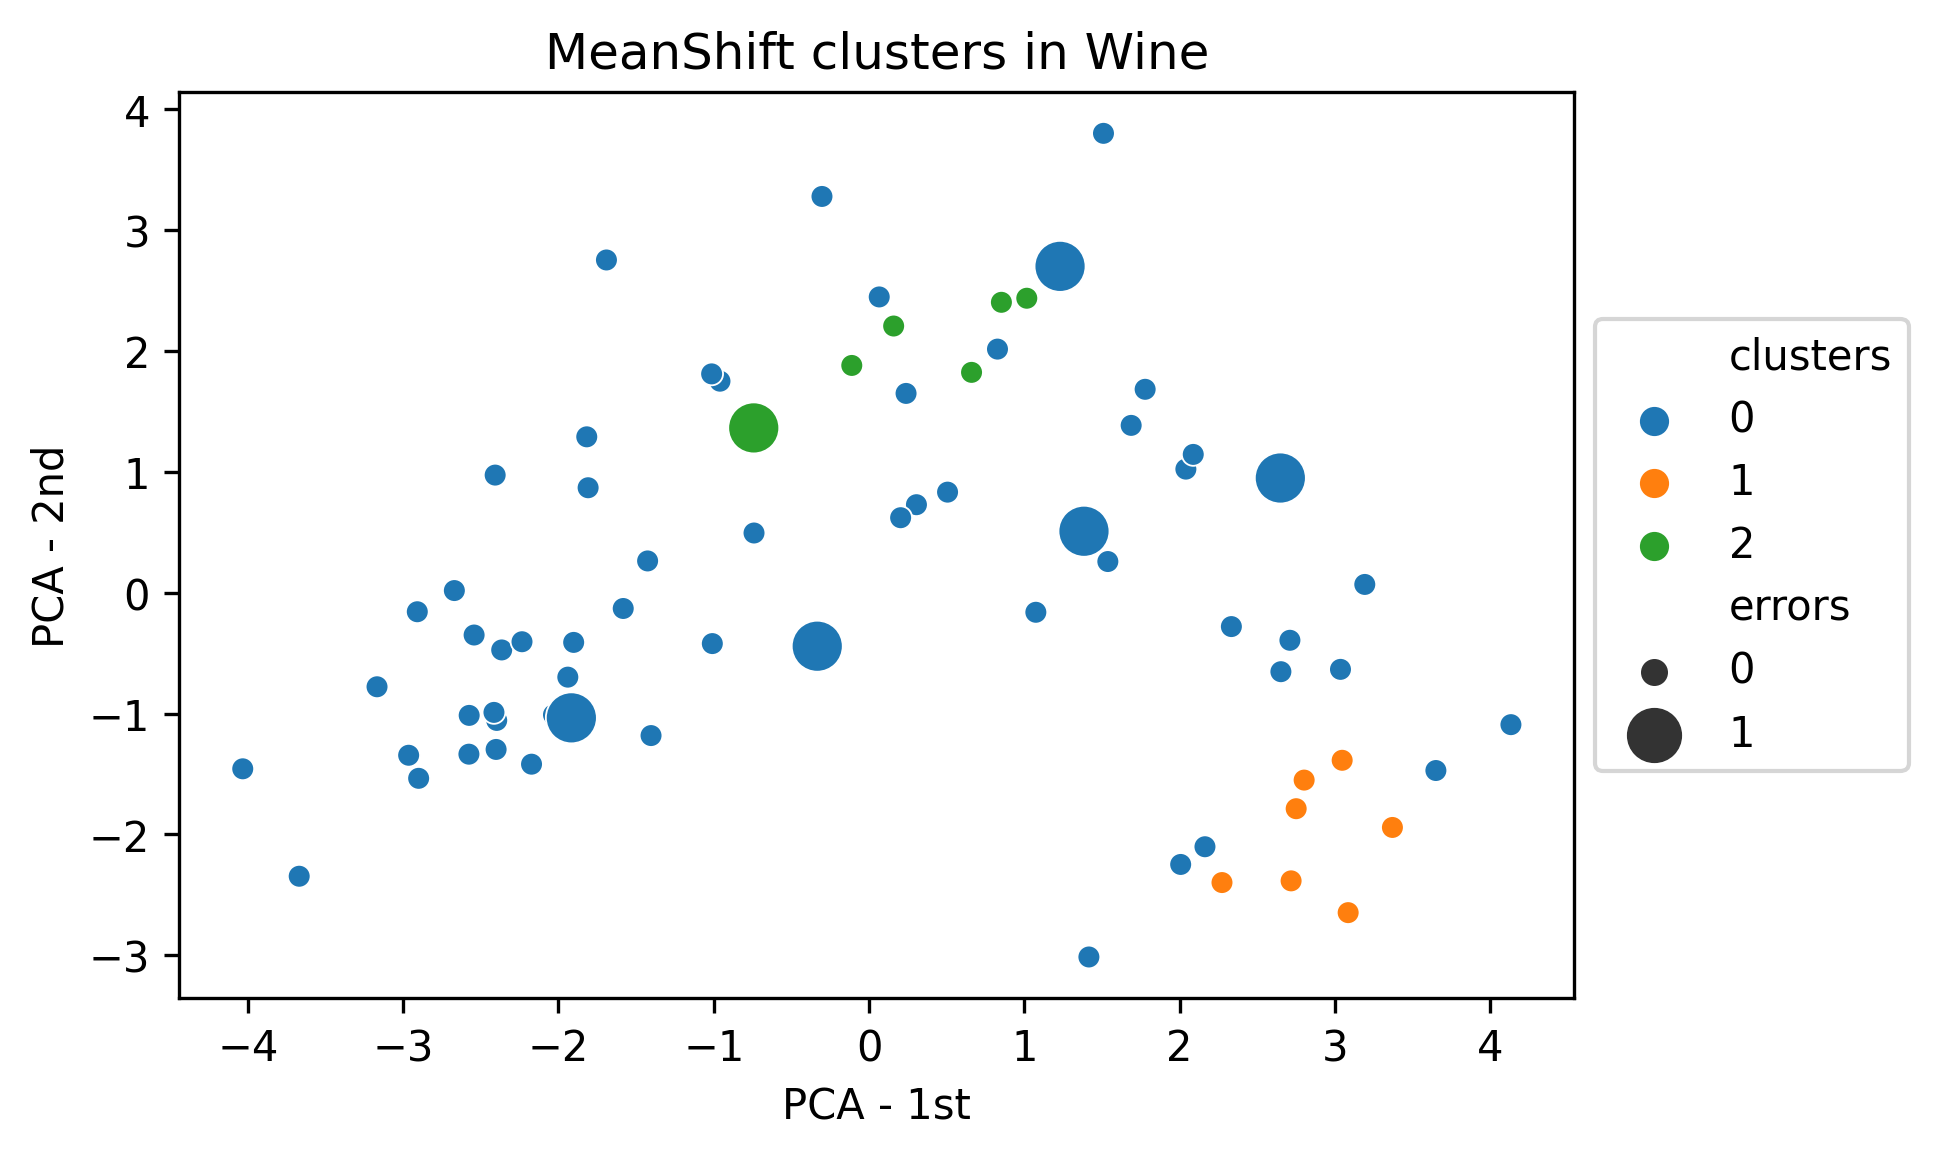

--> Cluster with the highest variance: 2
smallest cluster: 6


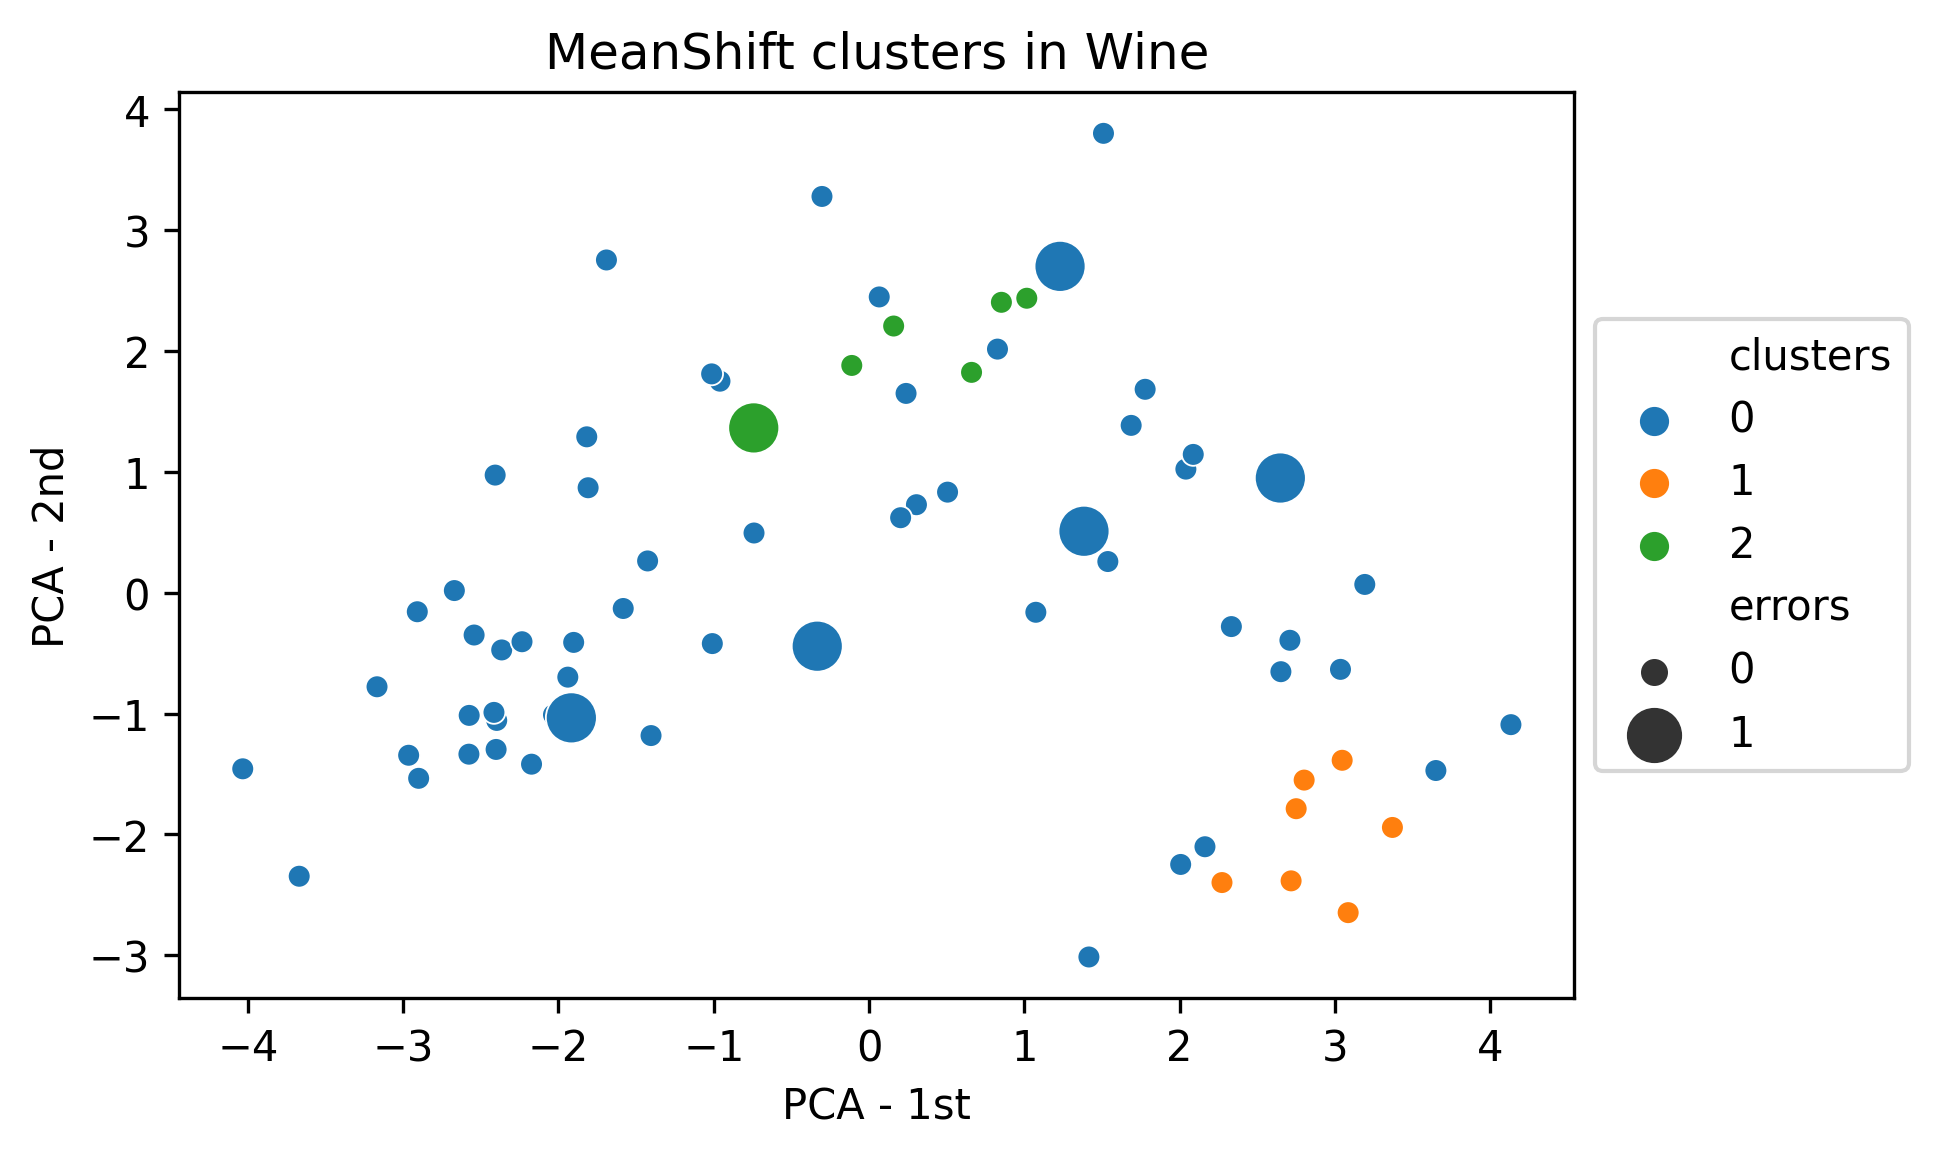

--> Cluster with the highest variance: 2
smallest cluster: 6


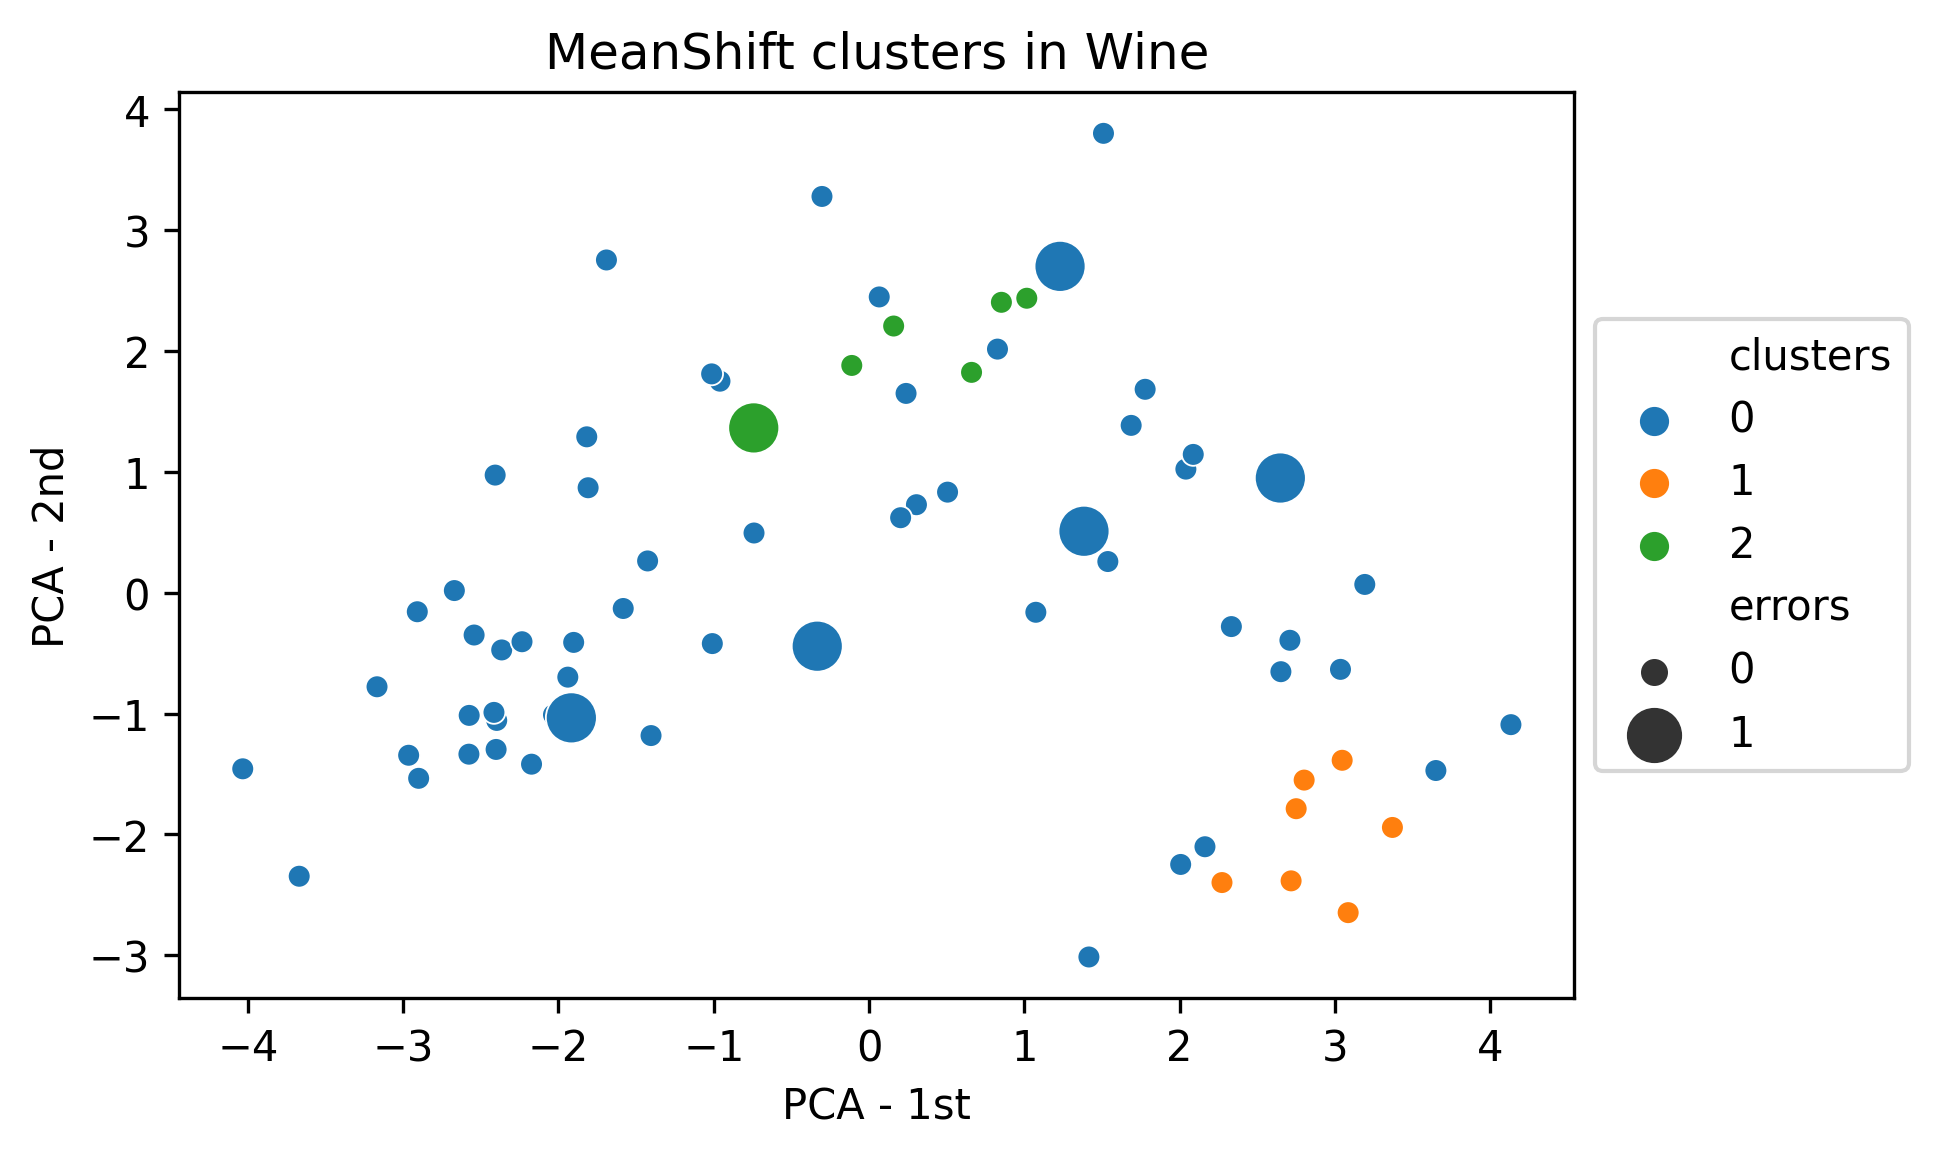

--> Cluster with the highest variance: 2
smallest cluster: 6


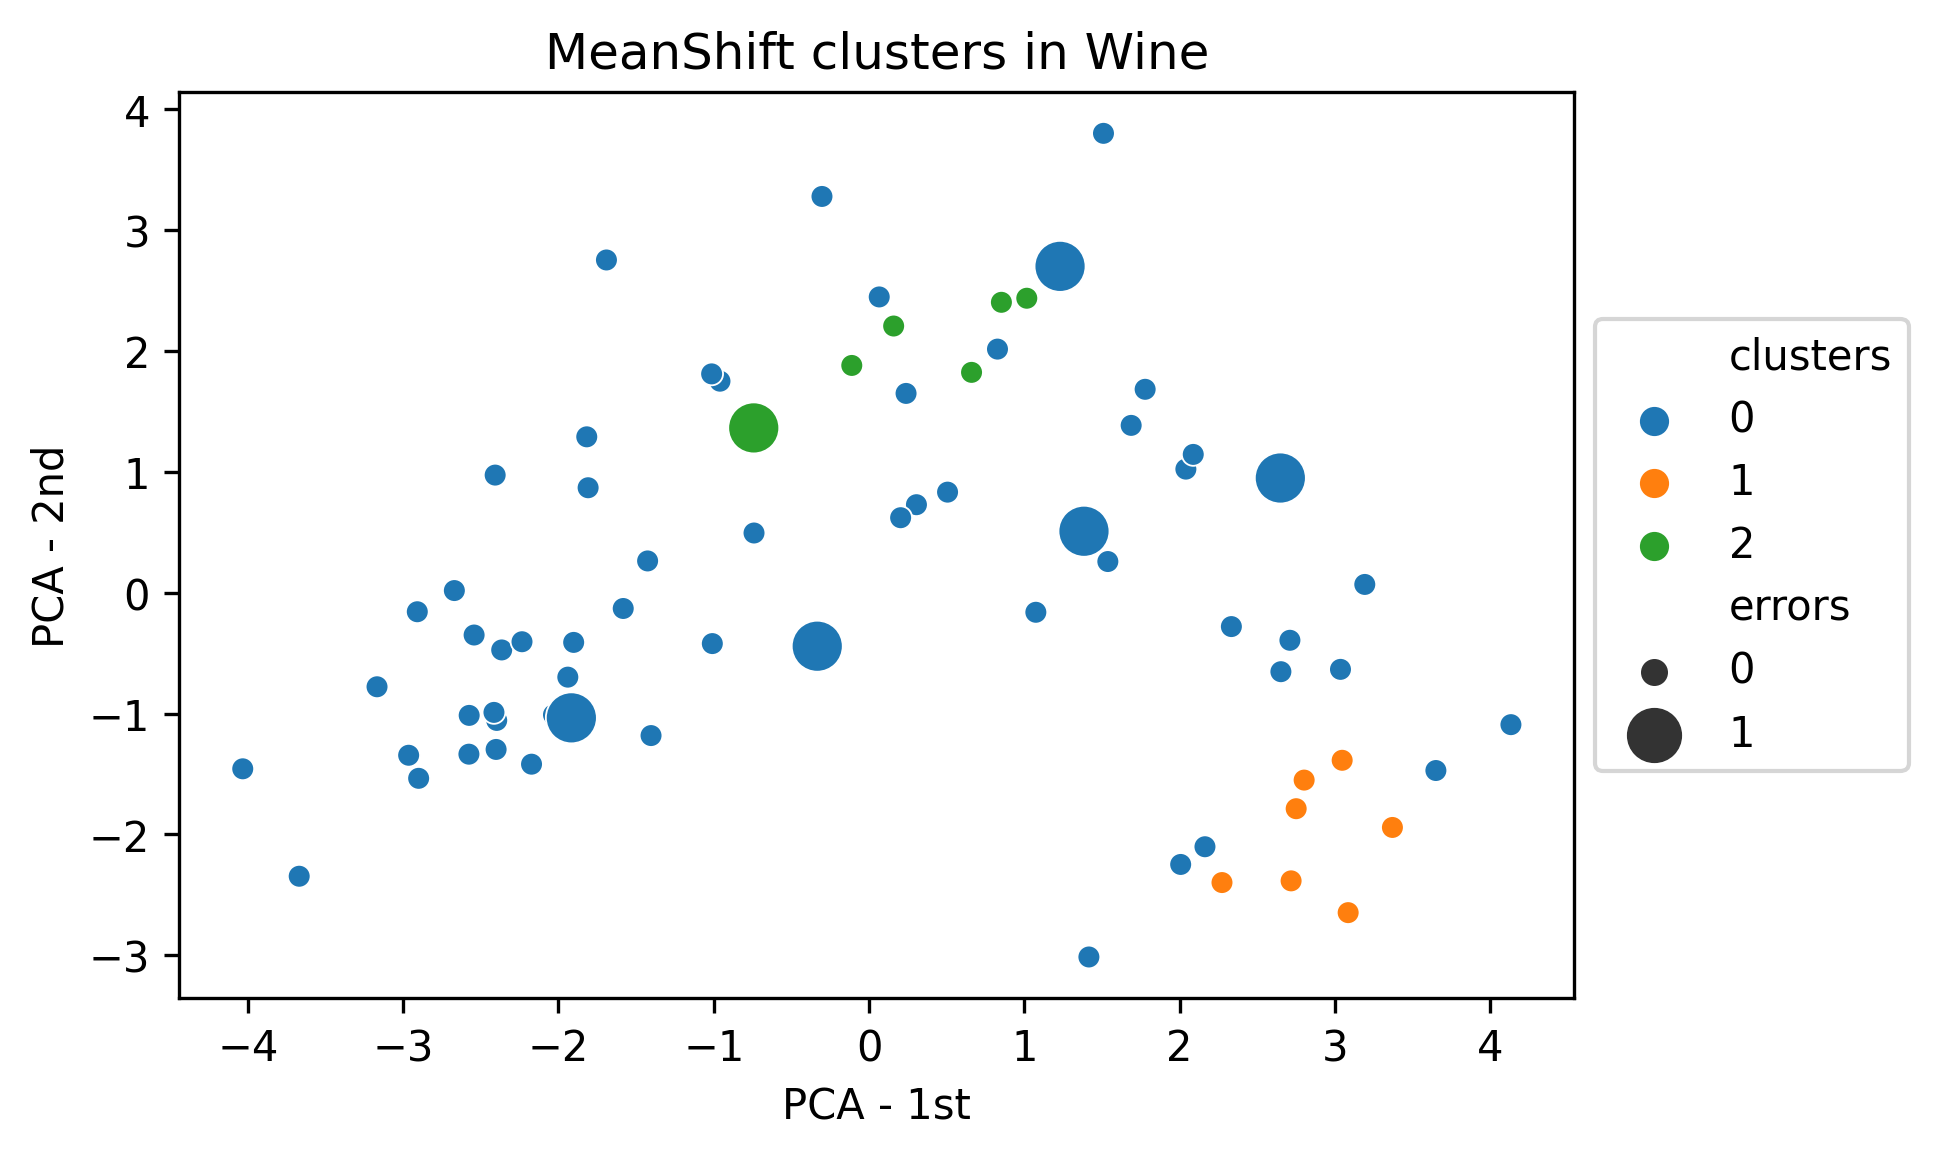

--> Cluster with the highest variance: 2
smallest cluster: 6


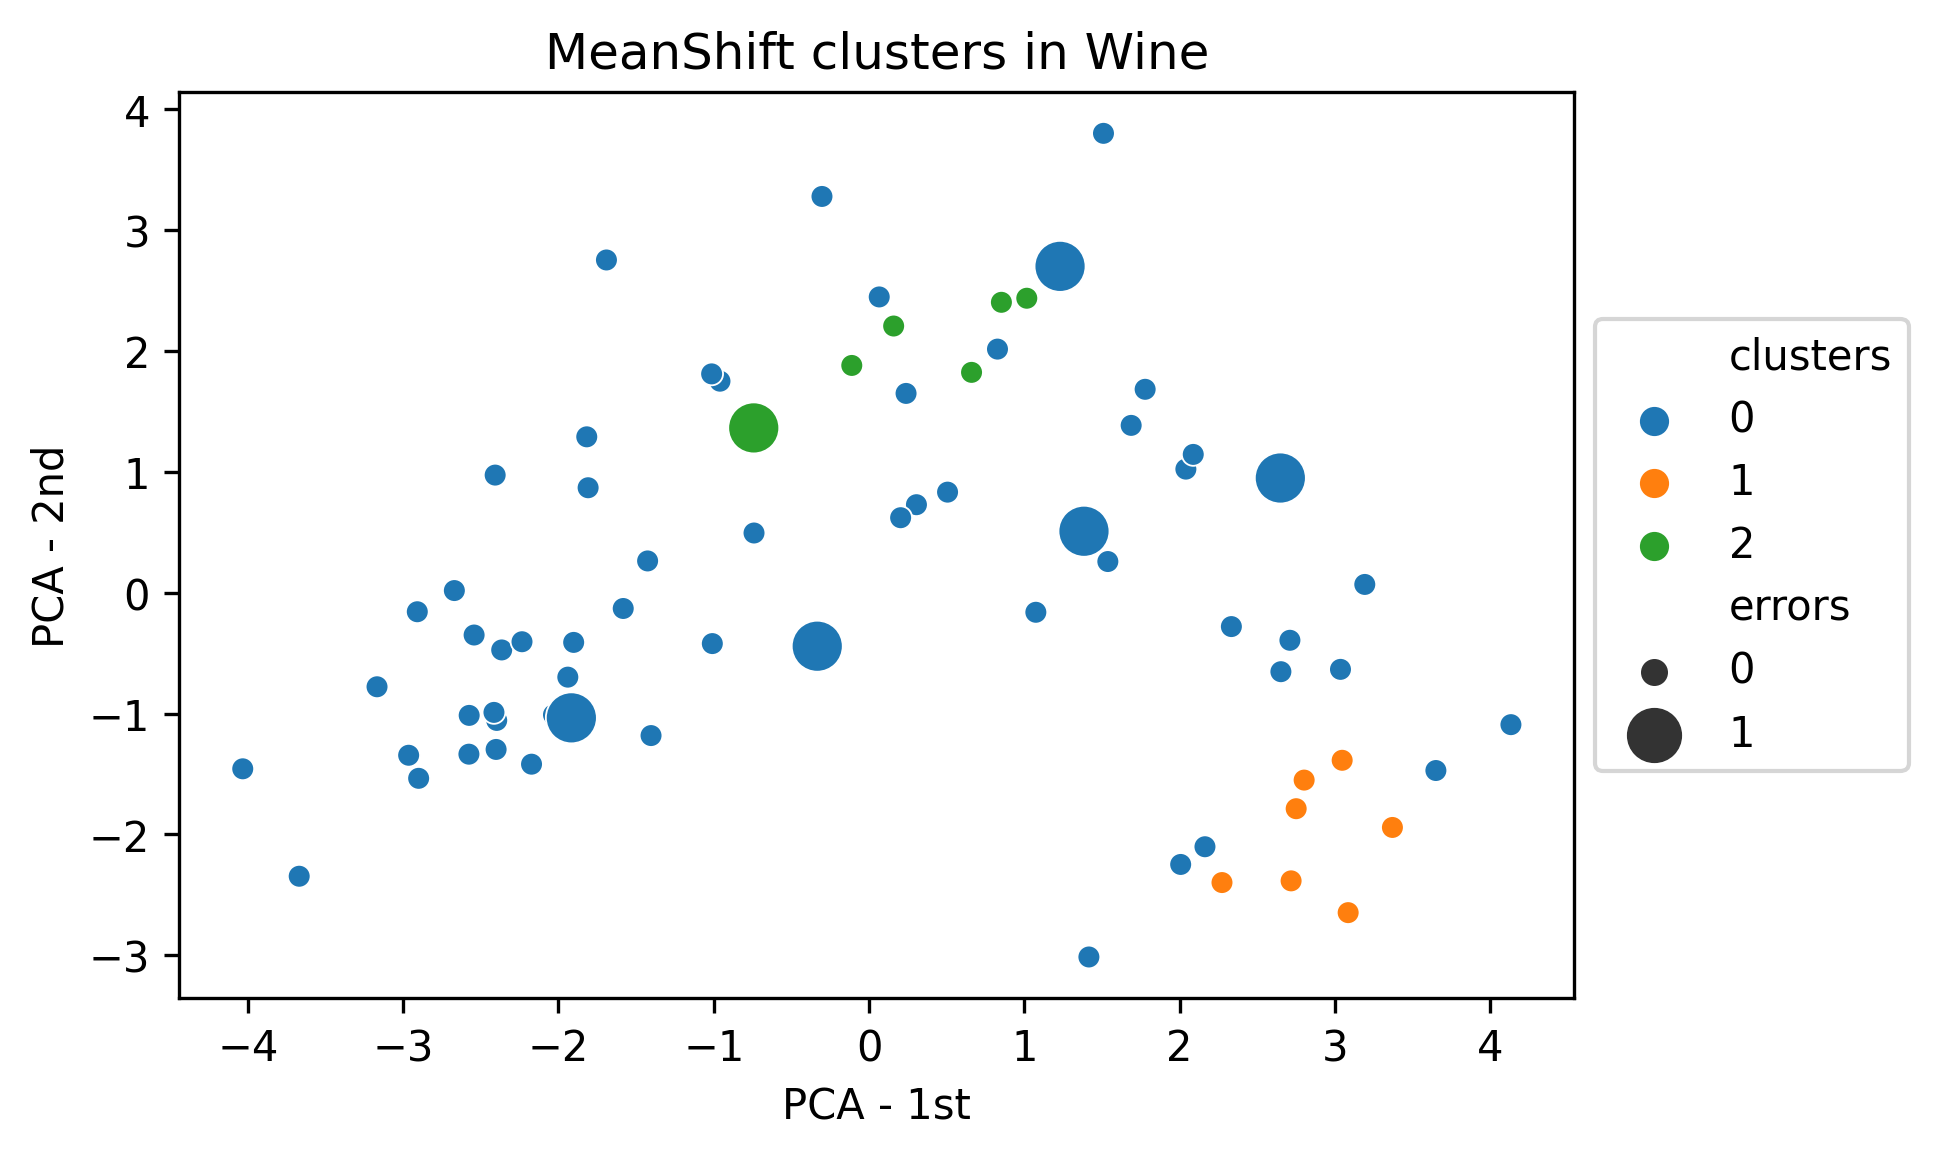

--> Cluster with the highest variance: 2
MAX_ITER
[0.008520710059171599, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764, 0.005610870331762764]


In [131]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
bw1 = 2
# bw1 = estimate_bandwidth(bandwidth_features)
print('estimated bandwidth: ', bw1)
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = round(0.02 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class','true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_neg_bias <= initial_bias) & (min_new_size >= minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

In [128]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_meanshift_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_meanshift_aware)

1 has bias -0.03703703703703709
0 has bias 0.03703703703703709
cluster 1 has the highest negative bias
[1 0]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.03703703703703709


In [129]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 18
Number of errors in discriminated clusters:  2


alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
104 -0.669074   -0.481192 -1.166817           0.461386  -0.963795   
67  -0.847070   -0.970763 -1.370315           0.208443  -1.360004   
101 -0.554648   -0.822143 -1.438148          -0.100709  -0.793991   
91  -1.317487   -0.673524  0.325503           0.882957  -0.907193   
92  -0.440222   -0.656039 -0.217159           0.517596  -1.246801   
103 -1.546339   -0.489935 -1.505980           0.180339  -0.907193   
102 -0.885212    0.148255  0.461168           0.601910  -0.227978   
75  -1.749763   -0.350057 -1.370315          -0.803327  -0.284579   
64  -1.101350   -0.725978  0.698583           0.039815   0.111630   
126 -0.770786   -0.656039 -0.115410           0.742434  -0.907193   
98  -0.847070   -1.058186 -0.759821          -0.100709  -0.793991   
76  -0.007946   -1.206806 -2.082559          -0.803327  -0.907193   
62   0.805749   -0.900824 -1.370315          -0.241232  -0.454383   
81  -0.402080   -0.411254 -0.420657          -0.016394  -0.907193   
80  -1.317487   -1.189321 -1.098984           0.039815  -0.907193   
106 -0.999638   -0.481192 -0.691988           0.039815  -1.246801   
60  -0.897926   -1.031959 -0.149326          -0.803327  -0.058174   
127 -1.584481   -0.131499  1.546492           2.709765  -0.567586   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
104      -0.130285   -0.137723             -0.284577        -0.211402   
67       -0.265798   -0.063096             -0.686333        -0.903977   
101      -1.259563   -0.660111             -0.525631        -0.416026   
91       -1.259563   -0.762724              1.161744         0.024704   
92       -1.364962   -0.566828              1.804554         0.008963   
103       0.321426   -0.398917              0.117179        -0.305844   
102       0.411768    0.039516             -0.123875        -0.478987   
75       -1.018650   -0.464216             -0.123875        -0.730833   
64       -0.597053   -0.296305              0.759988        -0.919717   
126       0.682795    1.009666              0.277881         0.245068   
98        1.857243    1.569368             -0.927387         0.528395   
76       -0.506711   -0.035111             -0.927387        -0.242882   
62       -0.280856   -0.258992             -0.284577        -1.391927   
81       -0.130285    0.431307             -0.766684         0.245068   
80        0.200970    0.179441             -0.445279        -0.290103   
106      -0.958422   -0.035111              0.117179         0.024704   
60       -0.356141   -0.911977              2.206310        -1.895618   
127      -0.235684    0.160785              1.804554         0.229328   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  \
104        -1.025689  0.361193                      1.354564 -0.225753   
67         -0.239382  0.710266                      1.229242 -0.714467   
101        -1.247121  0.361193                      0.240588 -0.557596   
91         -0.727435  0.404827                      0.073491 -0.895472   
92         -0.975980  0.012121                     -0.748066 -0.759718   
103        -1.423362 -0.075148                     -0.218927 -1.001058   
102        -1.088955 -0.686025                      1.089995 -0.931673   
75         -0.637055  1.190241                     -0.636668 -0.961840   
64         -1.021170  2.150191                     -0.511346 -1.182063   
126        -0.573788 -1.166000                      0.338061 -1.191113   
98         -0.320724  0.361193                      0.240588 -0.261954   
76         -0.275534  1.015705                     -0.163228 -1.070443   
62         -0.637055  1.190241                     -0.191078 -0.352457   
81         -0.591864  0.884802                      0.755802 -0.099050   
80         -1.224526  1.844752                      0.727953 -1.414353   
106        -0.817815  0.186657                      0.797576 -0.714467   
60         -0.876562  1.277509                  

In [ ]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance incl errors")

## Baseline Mean Shift

In [121]:
full_data = initialize_dataset(raw_data)
# bandwidth_features = full_data.iloc[: , : 24]
bandwidth_features = full_data.iloc[: , : 14]

In [122]:
# bw1 = estimate_bandwidth(bandwidth_features)
full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=3).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)

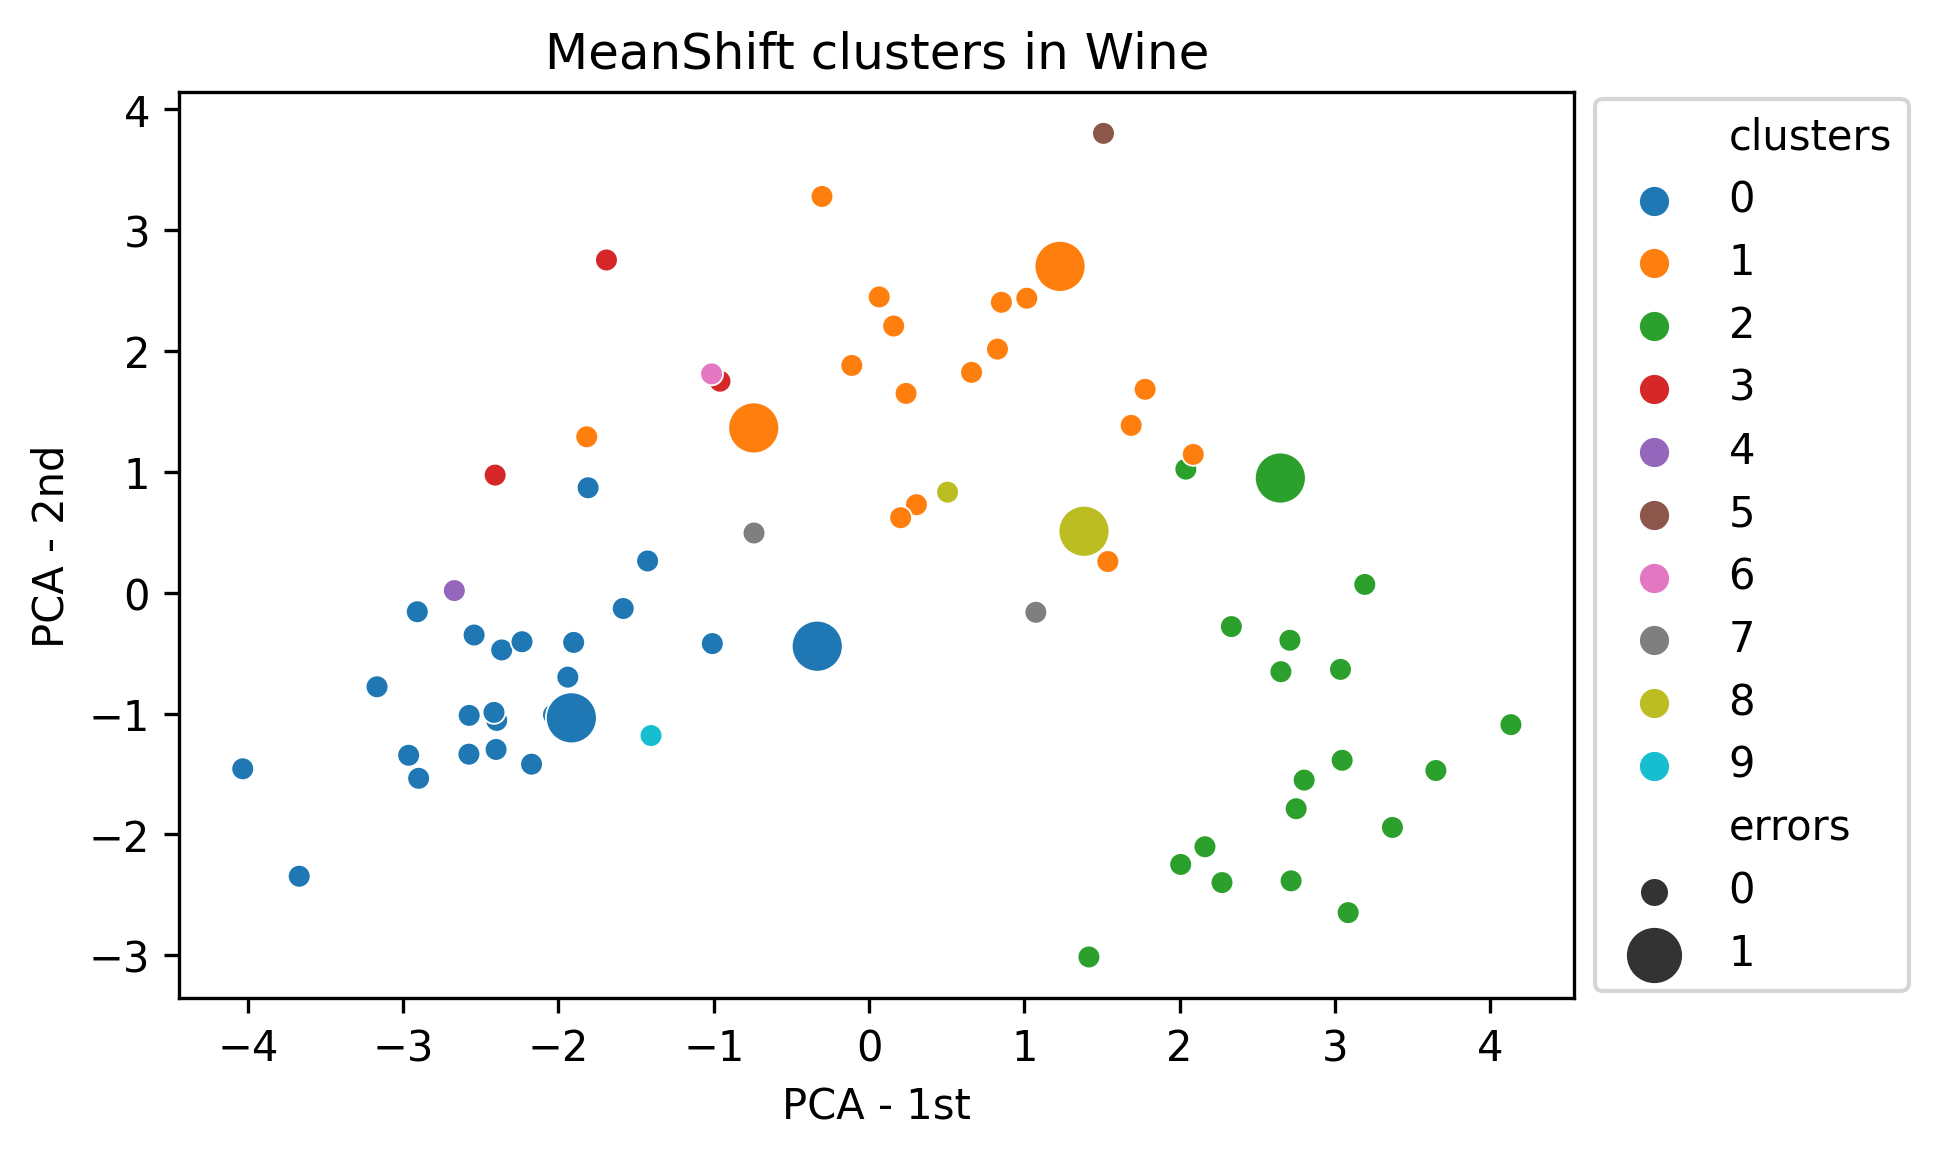

In [123]:
pca_plot(full_data)

In [125]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

1 has bias -0.03703703703703709
2 has bias 0.04170804369414094
0 has bias 0.0
5 has bias 0.08450704225352113
3 has bias 0.08695652173913049
7 has bias 0.08571428571428574
6 has bias 0.08450704225352113
9 has bias 0.08450704225352113
8 has bias -0.4285714285714286
4 has bias 0.08450704225352113
cluster 8 has the highest negative bias
[1 2 0 5 3 7 6 9 8 4]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.4285714285714286


## Goal 1: Comparing Bias-Aware KMeans/DBSCAN/MeanShift with finding the highest negatively biased cluster

In [ ]:
results_array = []

# the minus is to make the values positive, as that makes it easier to find the highest negative biased cluster
results_array.append(-most_biased_cluster_kmeans_aware)
results_array.append(-most_biased_cluster_dbscan_aware)
results_array.append(-most_biased_cluster_meanshift_aware)
results_array.append(-most_biased_cluster_baselinekm)
results_array.append(-most_biased_cluster_baselinemeanshift)


plt.bar(['KMeans', 'DBSCAN', 'MeanShift', 'BaselineKM', 'BaselineMeanShift'], results_array)
